# Classes

In [47]:
class Camera:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return str(self.__dict__)
    
    def covers(self, x, y):
        global RANGE
        return (self.x - x) * (self.x - x) + (self.y - y) * (self.y - y) < RANGE * RANGE
    
    def sq_dist(self, x, y):
        return (self.x - x) * (self.x - x) + (self.y - y) * (self.y - y)
    
    def copy(self):
        return Camera(self.x, self.y)

# Helper functions

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def pick_valid_coord():
    x, y = SIZE/2, SIZE/2
    while check_on_pillar(x, y):
        x, y = random.randint(0, SIZE-1), random.randint(0, SIZE-1)
    return (x, y)

def check_on_pillar(x, y):
    return (x - SIZE/2) ** 2 + (y - SIZE/2) ** 2 < (SIZE/4) ** 2

def check_solution(solution):
    """
    Checks whether a solution is valid
    """
    global N
    global SIZE
    for camera in solution:
        if camera.x < 0 or camera.x >= SIZE or camera.y < 0 or camera.y >= SIZE:
            raise Exception("Camera out of range : ", camera, "for size", SIZE, "in solution", solution)
    
    if len(solution) != N:
        raise Exception("Wrong amount of cameras (", len(cameras), ") expected", N)

eval_registry = []
def eval_solution_with_overlap(solution):
    """
    Evaluate a solution
    """
    global N
    global SIZE
    global eval_registry
    
    check_solution(solution)
    
    score = 0
    field = np.zeros((SIZE, SIZE))
    for camera in solution:
        for x in range(SIZE):
            for y in range(SIZE):
                if camera.covers(x, y) and not check_on_pillar(x, y):
                    field[x, y] += 1                    
                    
    real_score = np.sum(field > 0)
    field[field > 1] = -1
    score_wo = np.sum(field)
    eval_registry.append({'real_score' : real_score, 'score_with_overlap': score_wo, 'index' : len(eval_registry), 'solution':solution})
    
    return score_wo, real_score, field


def new_session():
    """
    Clears session variables
    """
    global eval_registry
    eval_registry = []

def save_solution(solution, file):
    """
    Saves a solution in a file
    """
    global N
    global SIZE
    global eval_registry
    
    check_solution(solution)
    
    with open(file, "w") as f:
        f.write(str(SIZE) + '\n')
        for camera in solution:
            f.write("{} {}\n".format(camera.x, camera.y))
    return score

def histogram_scores():
    """
    Shows the histogram of scores
    """
    global eval_registry
    print("Score histogram")
    scores = np.array([s['real_score'] for s in eval_registry])
    plt.hist(scores)
    plt.show()

def graph_scores():
    """
    Shows the graph of scores
    """
    global eval_registry
    print("Score graph")
    plt.plot([e['real_score'] for e in eval_registry])
    plt.show()

def graph_smooth_scores():
    """
    Shows the smoothed graph of scores
    """
    global eval_registry
    print("Smoothed score graph")
    smooth_factor = 30
    scores = np.array([e['real_score'] for e in eval_registry])
    scores = [scores[i:i+smooth_factor].mean() for i in range(len(scores) - smooth_factor)]
    plt.plot(scores)
    plt.show()

def show_solution(cameras):
    """
    Shows a solution
    """
    global SIZE
    global RANGE
    
    data = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
    for x in range(SIZE):
        for y in range(SIZE):
            covered=False
            on_camera=False
            on_pillar=False
            delta = SIZE * SIZE
            for camera in cameras:
                if camera.x == x and camera.y == y:
                    on_camera = True
                if camera.covers(x, y):
                    covered = True
                    delta = min(camera.sq_dist(x, y), delta)
                on_pillar = check_on_pillar(x, y)
            if on_camera:
                data[x, y] = [0, 0, 0]
            elif on_pillar:
                data[x, y] = [127, 127, 127]
            elif covered:
                data[x, y] = [255, int(128 * (delta) / (RANGE * RANGE)), int(128 * (delta) / (RANGE * RANGE))]
            else:
                data[x, y] = [255, 255, 255]
    plt.imshow(data)
    plt.show()

def solution_in_list(sol, l):
    """
    Checks whether a solution is in a list
    """
    for item in l:
        out_cam = False
        for c in item['solution']:
            found_cam = False
            for c2 in sol:
                if c.x == c2.x and c.y == c2.y:
                    found_cam = True
            if not found_cam:
                out_cam = True
        if not out_cam:
            return True
    return False
            
    
def session_info(session_name):
    """
    Shows info from current session
    """
    print("Session info for session :", session_name)
    best = sorted(eval_registry, key=lambda k:k['real_score'], reverse=True)[0]
    show_solution(best['solution'])
    save_solution(best['solution'], "./{}_{}.txt".format(session_name, best['real_score']))
    print("Max score :", best['real_score'])
    print("Max score with overlap : ", best['score_with_overlap'])
    histogram_scores()
    graph_scores()
    graph_smooth_scores()

In [88]:
def display_pop(population):
    """
    Displays a population (25 best individuals)
    """
    sorted_population = sorted(population, key=lambda i:i['score_with_overlap'], reverse=True)
    global SIZE
    global RANGE
    plt.figure(1, figsize = (50, 50))
    for i in range(5):
        for j in range(5):
            plt.subplot(5, 5, 1+i+5*j)
    
            data = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            for x in range(SIZE):
                for y in range(SIZE):
                    covered=False
                    on_camera=False
                    delta = SIZE * SIZE
                    for camera in sorted_population[i+5*j]['solution']:
                        if camera.x == x and camera.y == y:
                            on_camera = True
                        if camera.covers(x, y):
                            covered = True
                            delta = min(camera.sq_dist(x, y), delta)
                        on_pillar = check_on_pillar(x, y)
                    if on_camera:
                        data[x, y] = [0, 0, 0]
                    elif on_pillar:
                        data[x, y] = [127, 127, 127]
                    elif covered:
                        data[x, y] = [255, int(128 * (delta) / (RANGE * RANGE)), int(128 * (delta) / (RANGE * RANGE))]
                    else:
                        data[x, y] = [255, 255, 255]
            plt.imshow(data)
    plt.show()

# Parameters

In [89]:
SIZE = 100
N = 30
RANGE = 10

# Solutions en dur

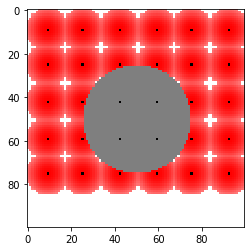

Real score : 6122
Score with overlap: 4458.0


In [90]:
import math

new_session()
def even_square():
    """
    Make a square out of the solution
    """
    global N
    global SIZE
    sol = []
    tot = 0
    side = math.ceil(math.sqrt(N))
    for i in range(side):
        for j in range(side):
            if tot == N:
                break
            sol.append(Camera(math.ceil((i + 0.5) * SIZE / side), math.ceil((j + 0.5) * SIZE / side)))
            tot += 1
    return sol


cameras = even_square()
score_with_overlap, real_score, field = eval_solution_with_overlap(cameras)

save_solution(cameras, "./square.txt")
show_solution(cameras)
print("Real score :", real_score)
print("Score with overlap:", score_with_overlap)

# Recherche Aléatoire 

In [91]:
RANDOM_STEPS = 10

import random
new_session()

solutions = []

for step in range(RANDOM_STEPS):
    # if (step % (RANDOM_STEPS // 100) == 0):
    #    print("Step", step)
    cameras = []
    
    # Place N random cameras
    for i in range(N):
        x, y = SIZE/2, SIZE/2
        while check_on_pillar(x, y):
            x, y = random.randint(0, SIZE-1), random.randint(0, SIZE-1)
        
        cameras.append(Camera(x, y))
    
    # Eval
    score_with_overlap, real_score, field = eval_solution_with_overlap(cameras)
    
    solutions.append({'solution' : cameras, 'real_score' : score, 'score_with_overlap' : true_score})

Session info for session : random_search


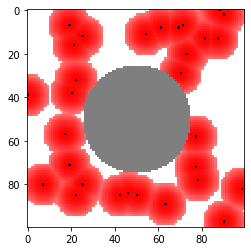

Max score : 5130
Max score with overlap :  428.0
Score histogram


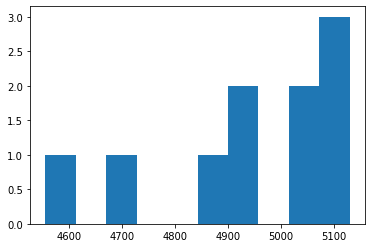

Score graph


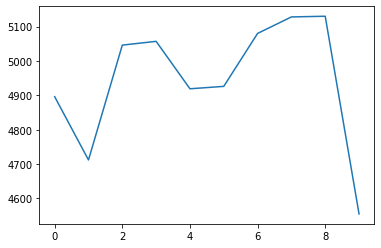

Smoothed score graph


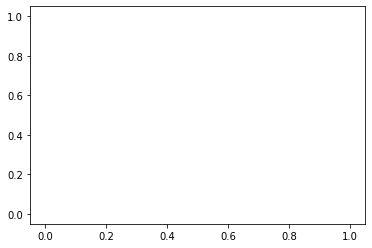

In [92]:
session_info("random_search")

# Algo genetique

In [105]:
# POP_SIZE > 25 for display purpose
POP_SIZE = 50
GENERATIONS = 20
MUTATE_PB = 0.05

#% Best individuals kept at each generation
KEEP_BEST = 10

#% Individuals dismissed
DISMISS_WORSE = 25

Draw random initial population

In [110]:
new_session()
current_population = []

# Init pop
for i in range(POP_SIZE):
    cameras = []
    for i in range(N):
        x, y = SIZE/2, SIZE/2
        while check_on_pillar(x, y):
            x, y = random.randint(0, SIZE-1), random.randint(0, SIZE-1)
        cameras.append(Camera(x, y))
    score_with_overlap, real_score, field = eval_solution_with_overlap(cameras)
    
    current_population.append({'solution' : cameras, 'real_score' : real_score, 'score_with_overlap': score_with_overlap})

In [111]:
def combine_parents(parent1, parent2):
    """
    Combine two parents
    """
    global N
    
    cameras = []
    for i in range(N):
        if random.random() < 0.5:
            cameras.append(parent1['solution'][i].copy())
        else:
            cameras.append(parent2['solution'][i].copy())
    
    return cameras

In [112]:
def mutate(individual):
    """
    Applies a mutation
    """
    global MUTATE_PB
    
    new_individual = []
    for i in range(N):
        x = individual[i].x
        y = individual[i].y
        if random.random() < MUTATE_PB:
            x = random.randint(0, SIZE-1)
            while check_on_pillar(x, y):
                x = random.randint(0, SIZE-1)
        if random.random() < MUTATE_PB:
            y = random.randint(0, SIZE-1)
            while check_on_pillar(x, y):
                y = random.randint(0, SIZE-1)
        new_individual.append(Camera(x, y))
    return new_individual

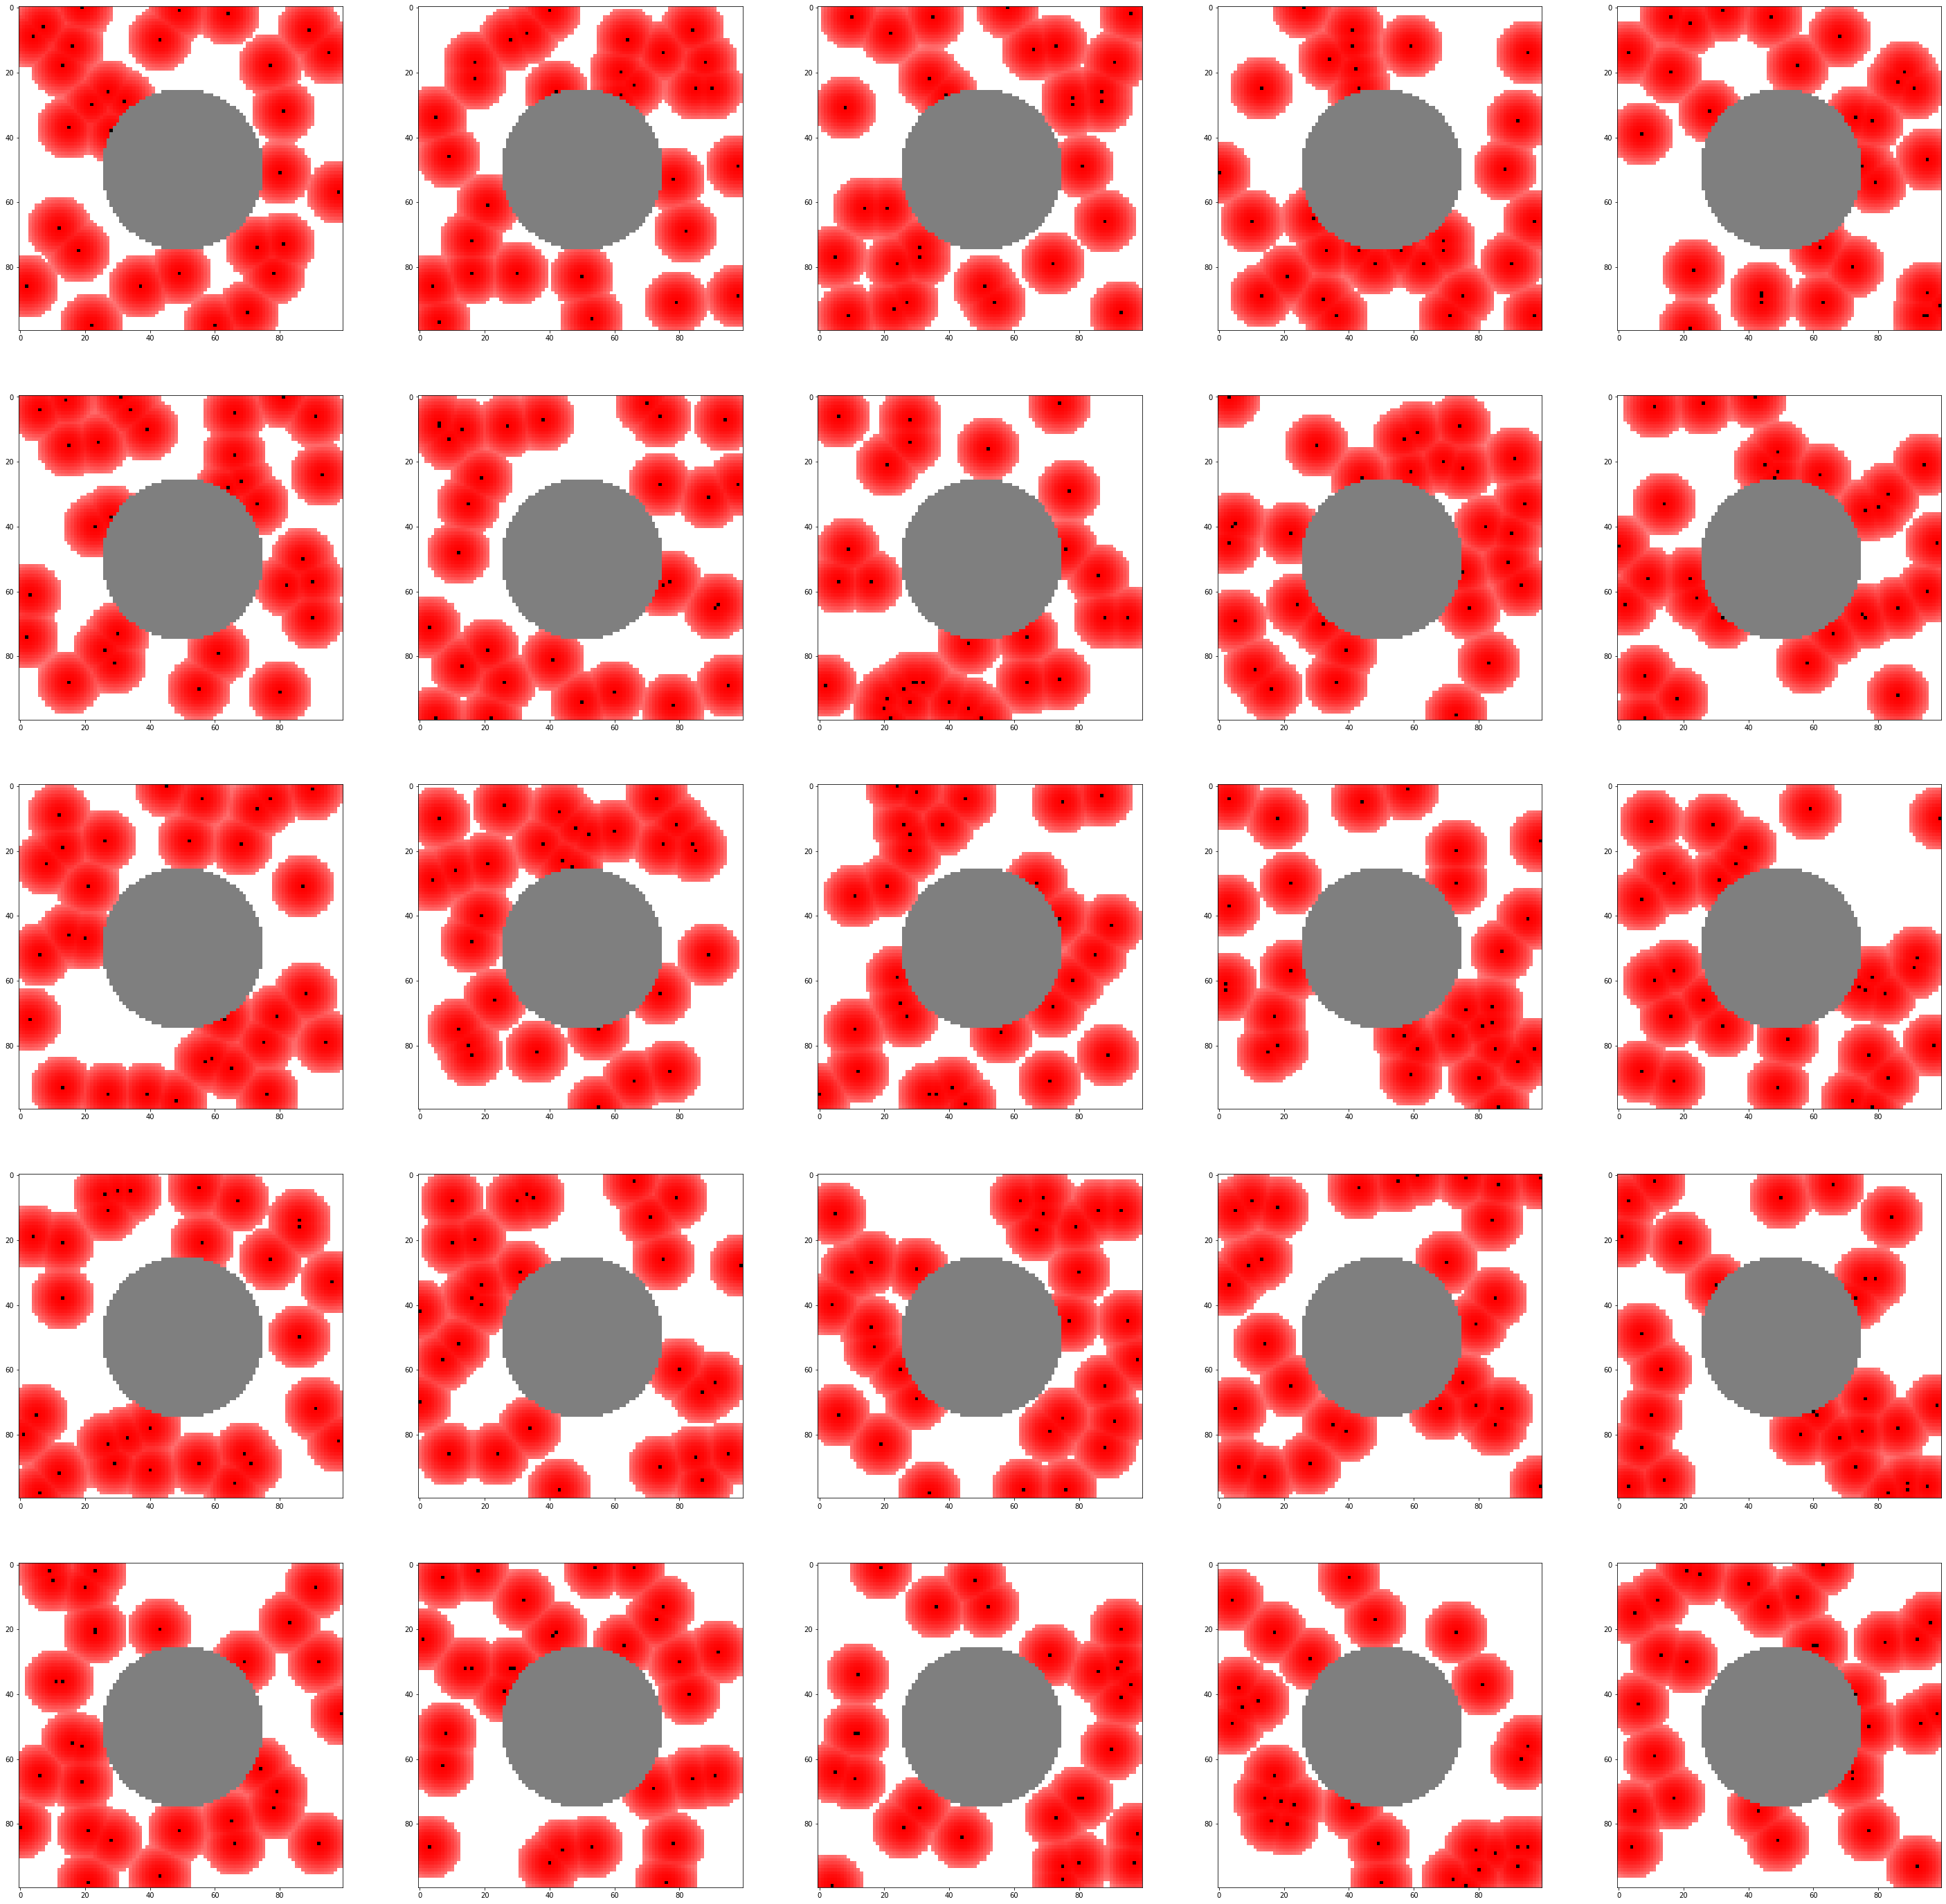

Generation 1
[5608 5546 5481 5454 5444 5418 5388 5323 5311 5307 5304 5240 5237 5222
 5221 5213 5190 5168 5164 5160 5154 5125 5112 5076 5019]
Previous generation score average 5275.4
[0.09168609 0.08205128 0.07195027 0.06775447 0.06620047 0.06216006
 0.05749806 0.04739705 0.04553225 0.04491064 0.04444444 0.03449883
 0.03403263 0.03170163 0.03154623 0.03030303 0.02672883 0.02331002
 0.02268842 0.02206682 0.02113442 0.01662782 0.01460761 0.00901321
 0.0001554 ]


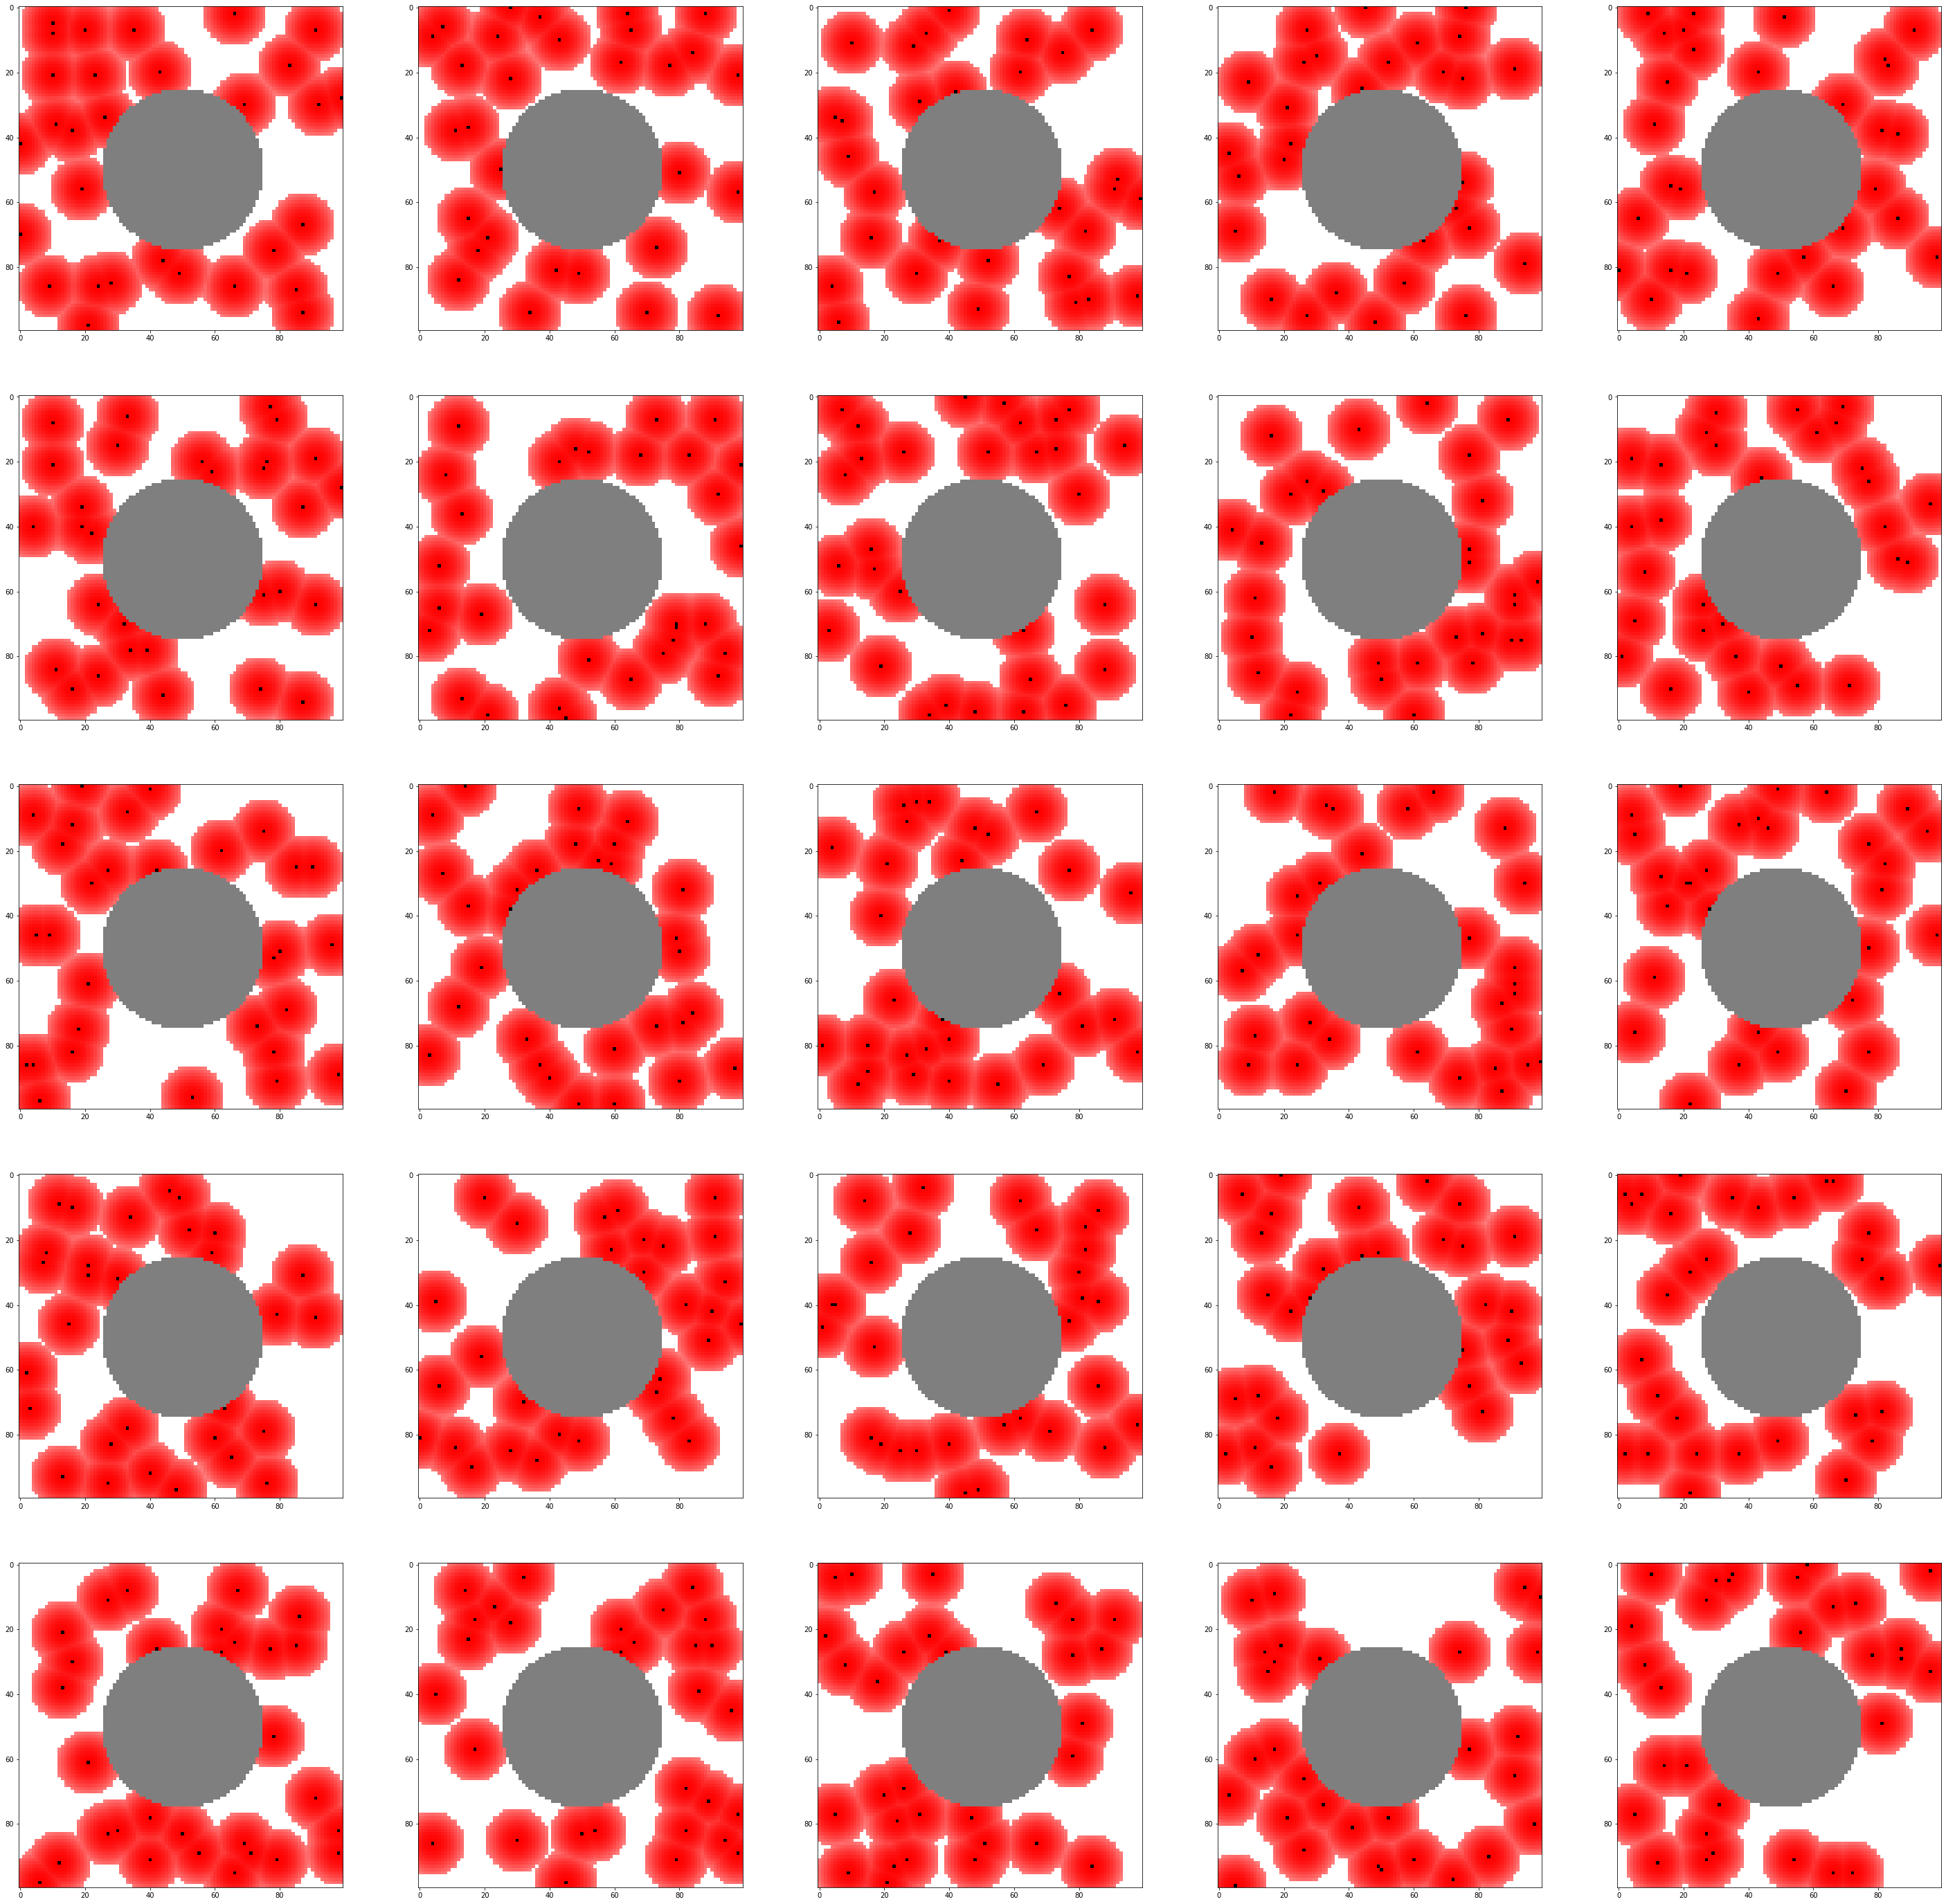

Generation 2
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 1850. 1757.
 1618. 1553. 1528. 1515. 1456. 1437. 1406. 1322. 1094. 1079. 1067. 1052.
 1050.]
Previous generation score average 3002.56
[9.33475296e-02 9.20780524e-02 9.07471488e-02 9.01943119e-02
 8.99895575e-02 8.94571961e-02 8.88429329e-02 8.75120293e-02
 8.72663240e-02 8.71844223e-02 1.64008272e-02 1.44966113e-02
 1.16505252e-02 1.03196216e-02 9.80773562e-03 9.54155490e-03
 8.33350396e-03 7.94447061e-03 7.30973198e-03 5.58979504e-03
 9.21394787e-04 6.14263191e-04 3.68557915e-04 6.14263191e-05
 2.04754397e-05]


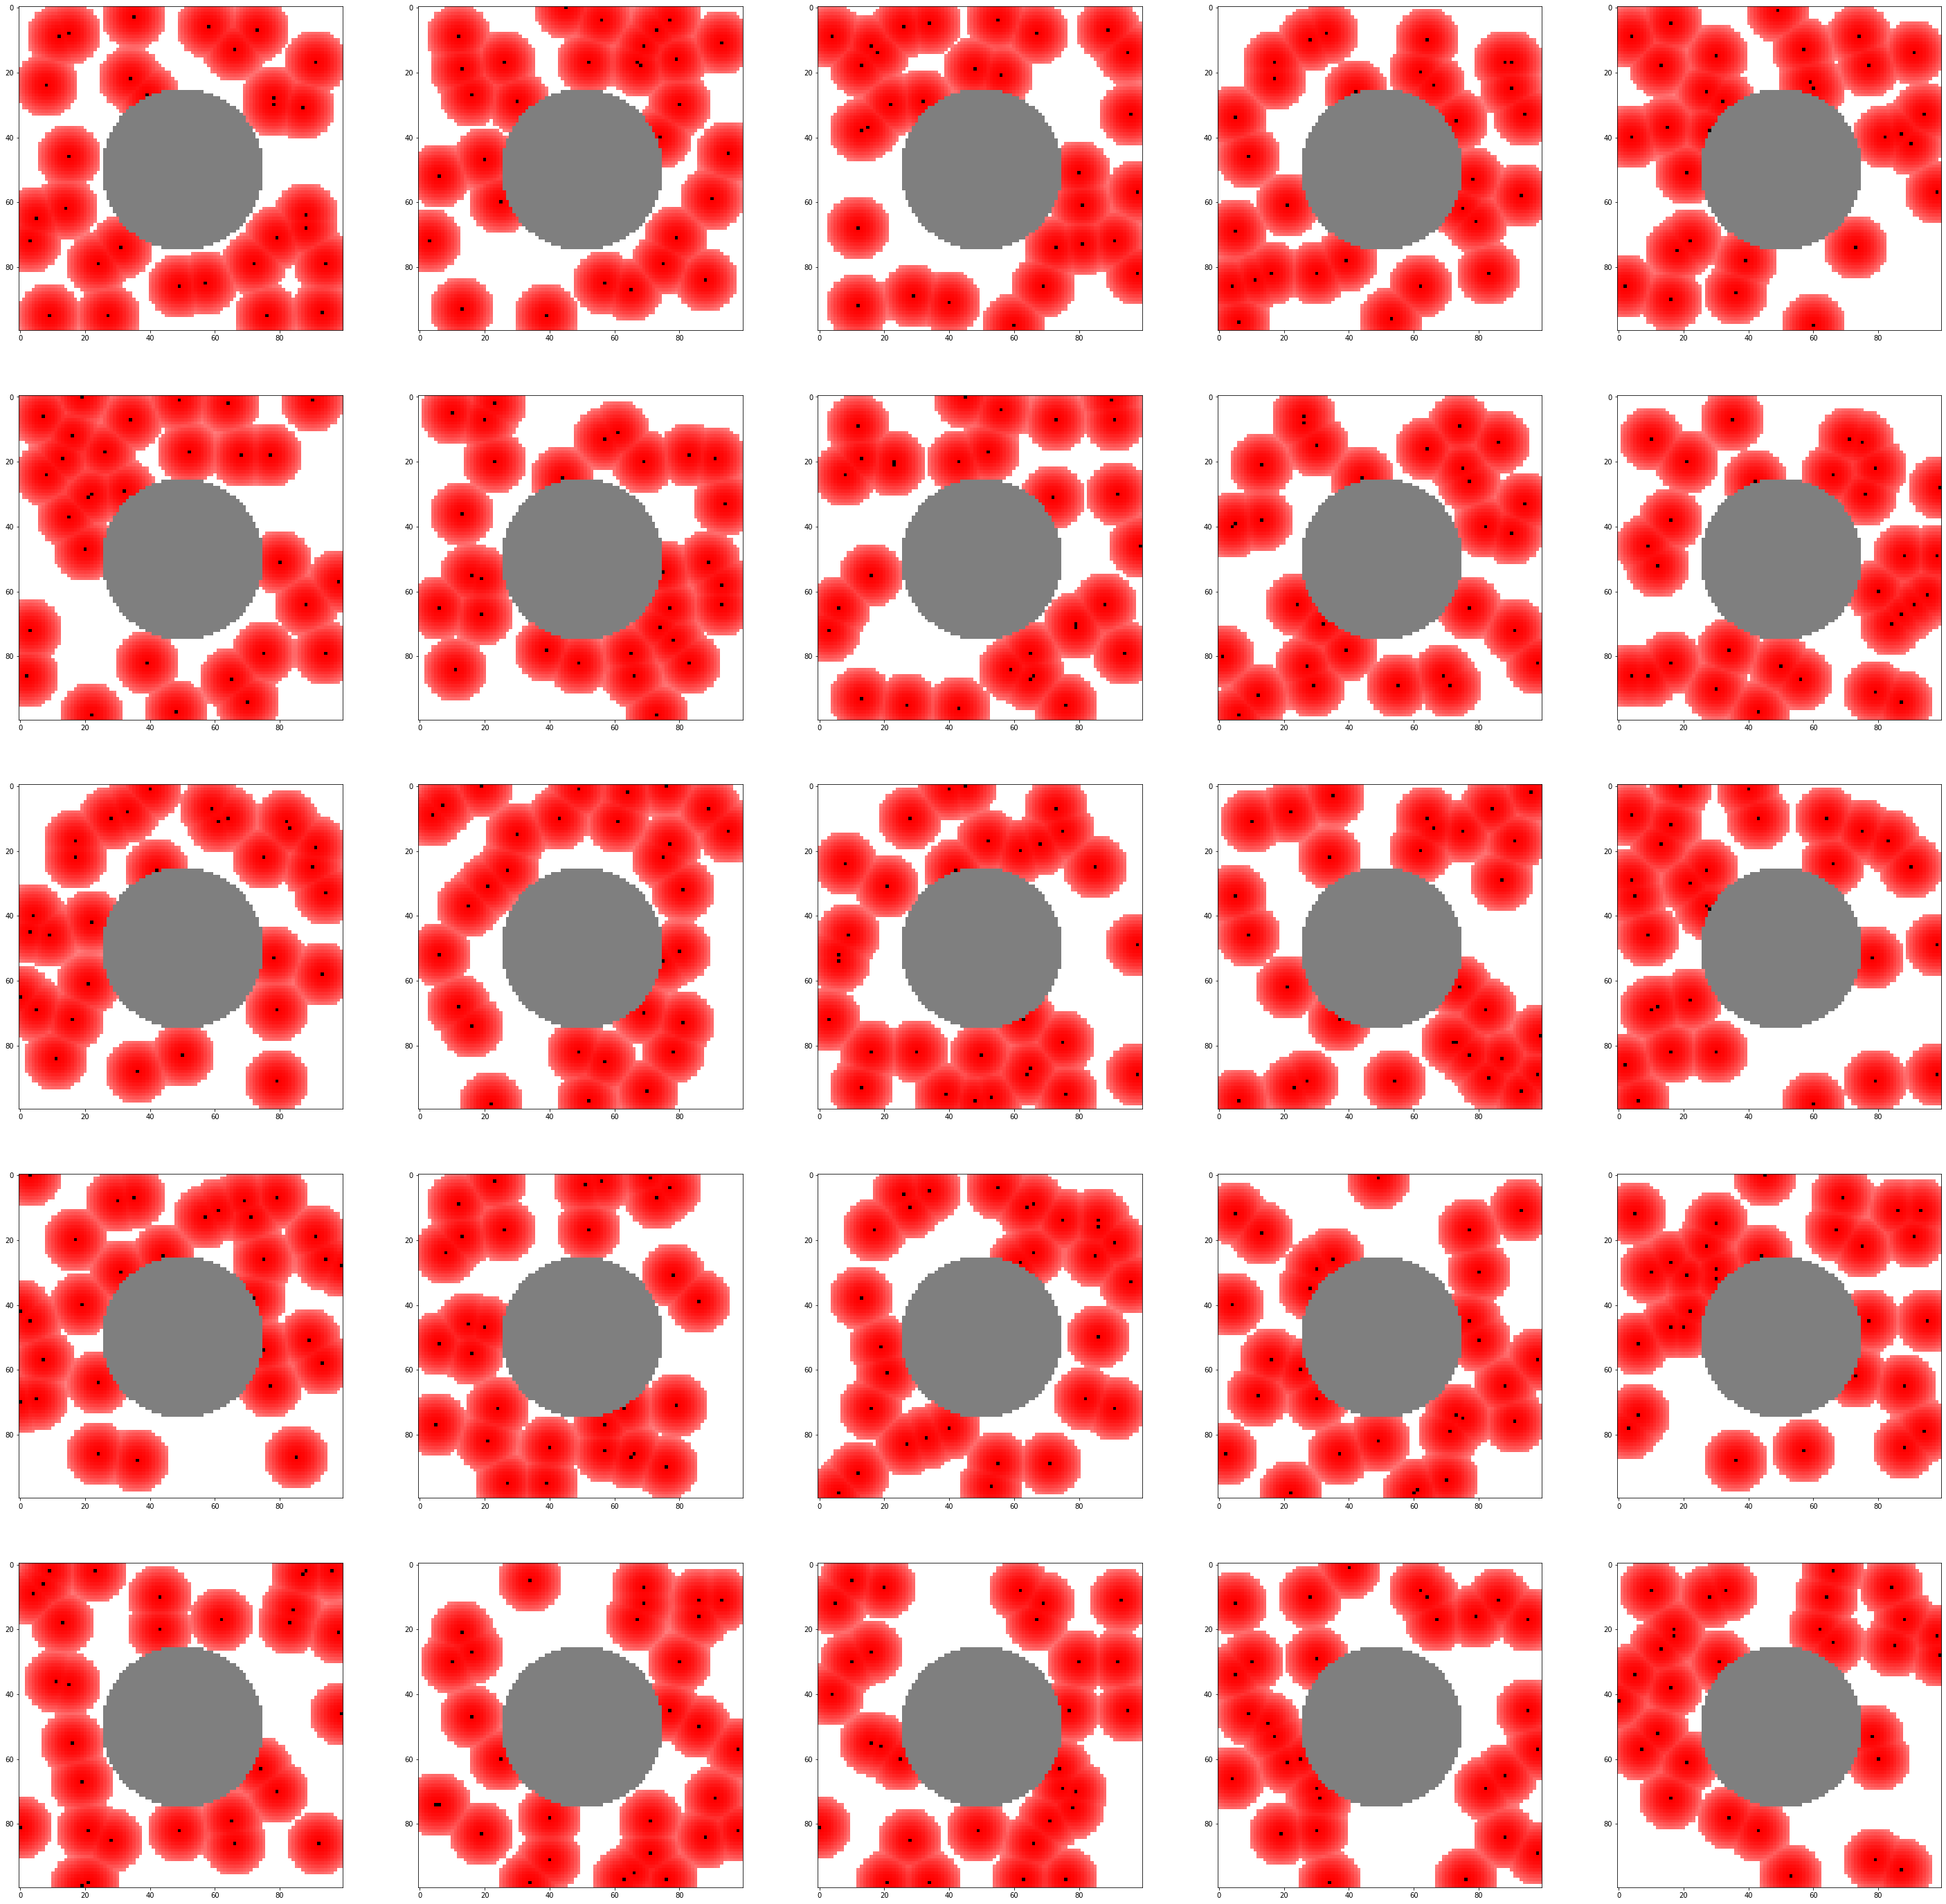

Generation 3
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2248. 2178.
 1852. 1761. 1690. 1682. 1576. 1561. 1555. 1522. 1499. 1467. 1401. 1317.
 1283.]
Previous generation score average 3154.88
[9.23924651e-02 9.10683012e-02 8.96800649e-02 8.91034129e-02
 8.88898381e-02 8.83345436e-02 8.76938191e-02 8.63055828e-02
 8.60492931e-02 8.59638631e-02 2.06313272e-02 1.91363034e-02
 1.21737645e-02 1.02302337e-02 8.71385246e-03 8.54299261e-03
 6.27909957e-03 5.95873735e-03 5.83059246e-03 5.12579557e-03
 4.63457349e-03 3.95113408e-03 2.54154030e-03 7.47511853e-04
 2.13574815e-05]


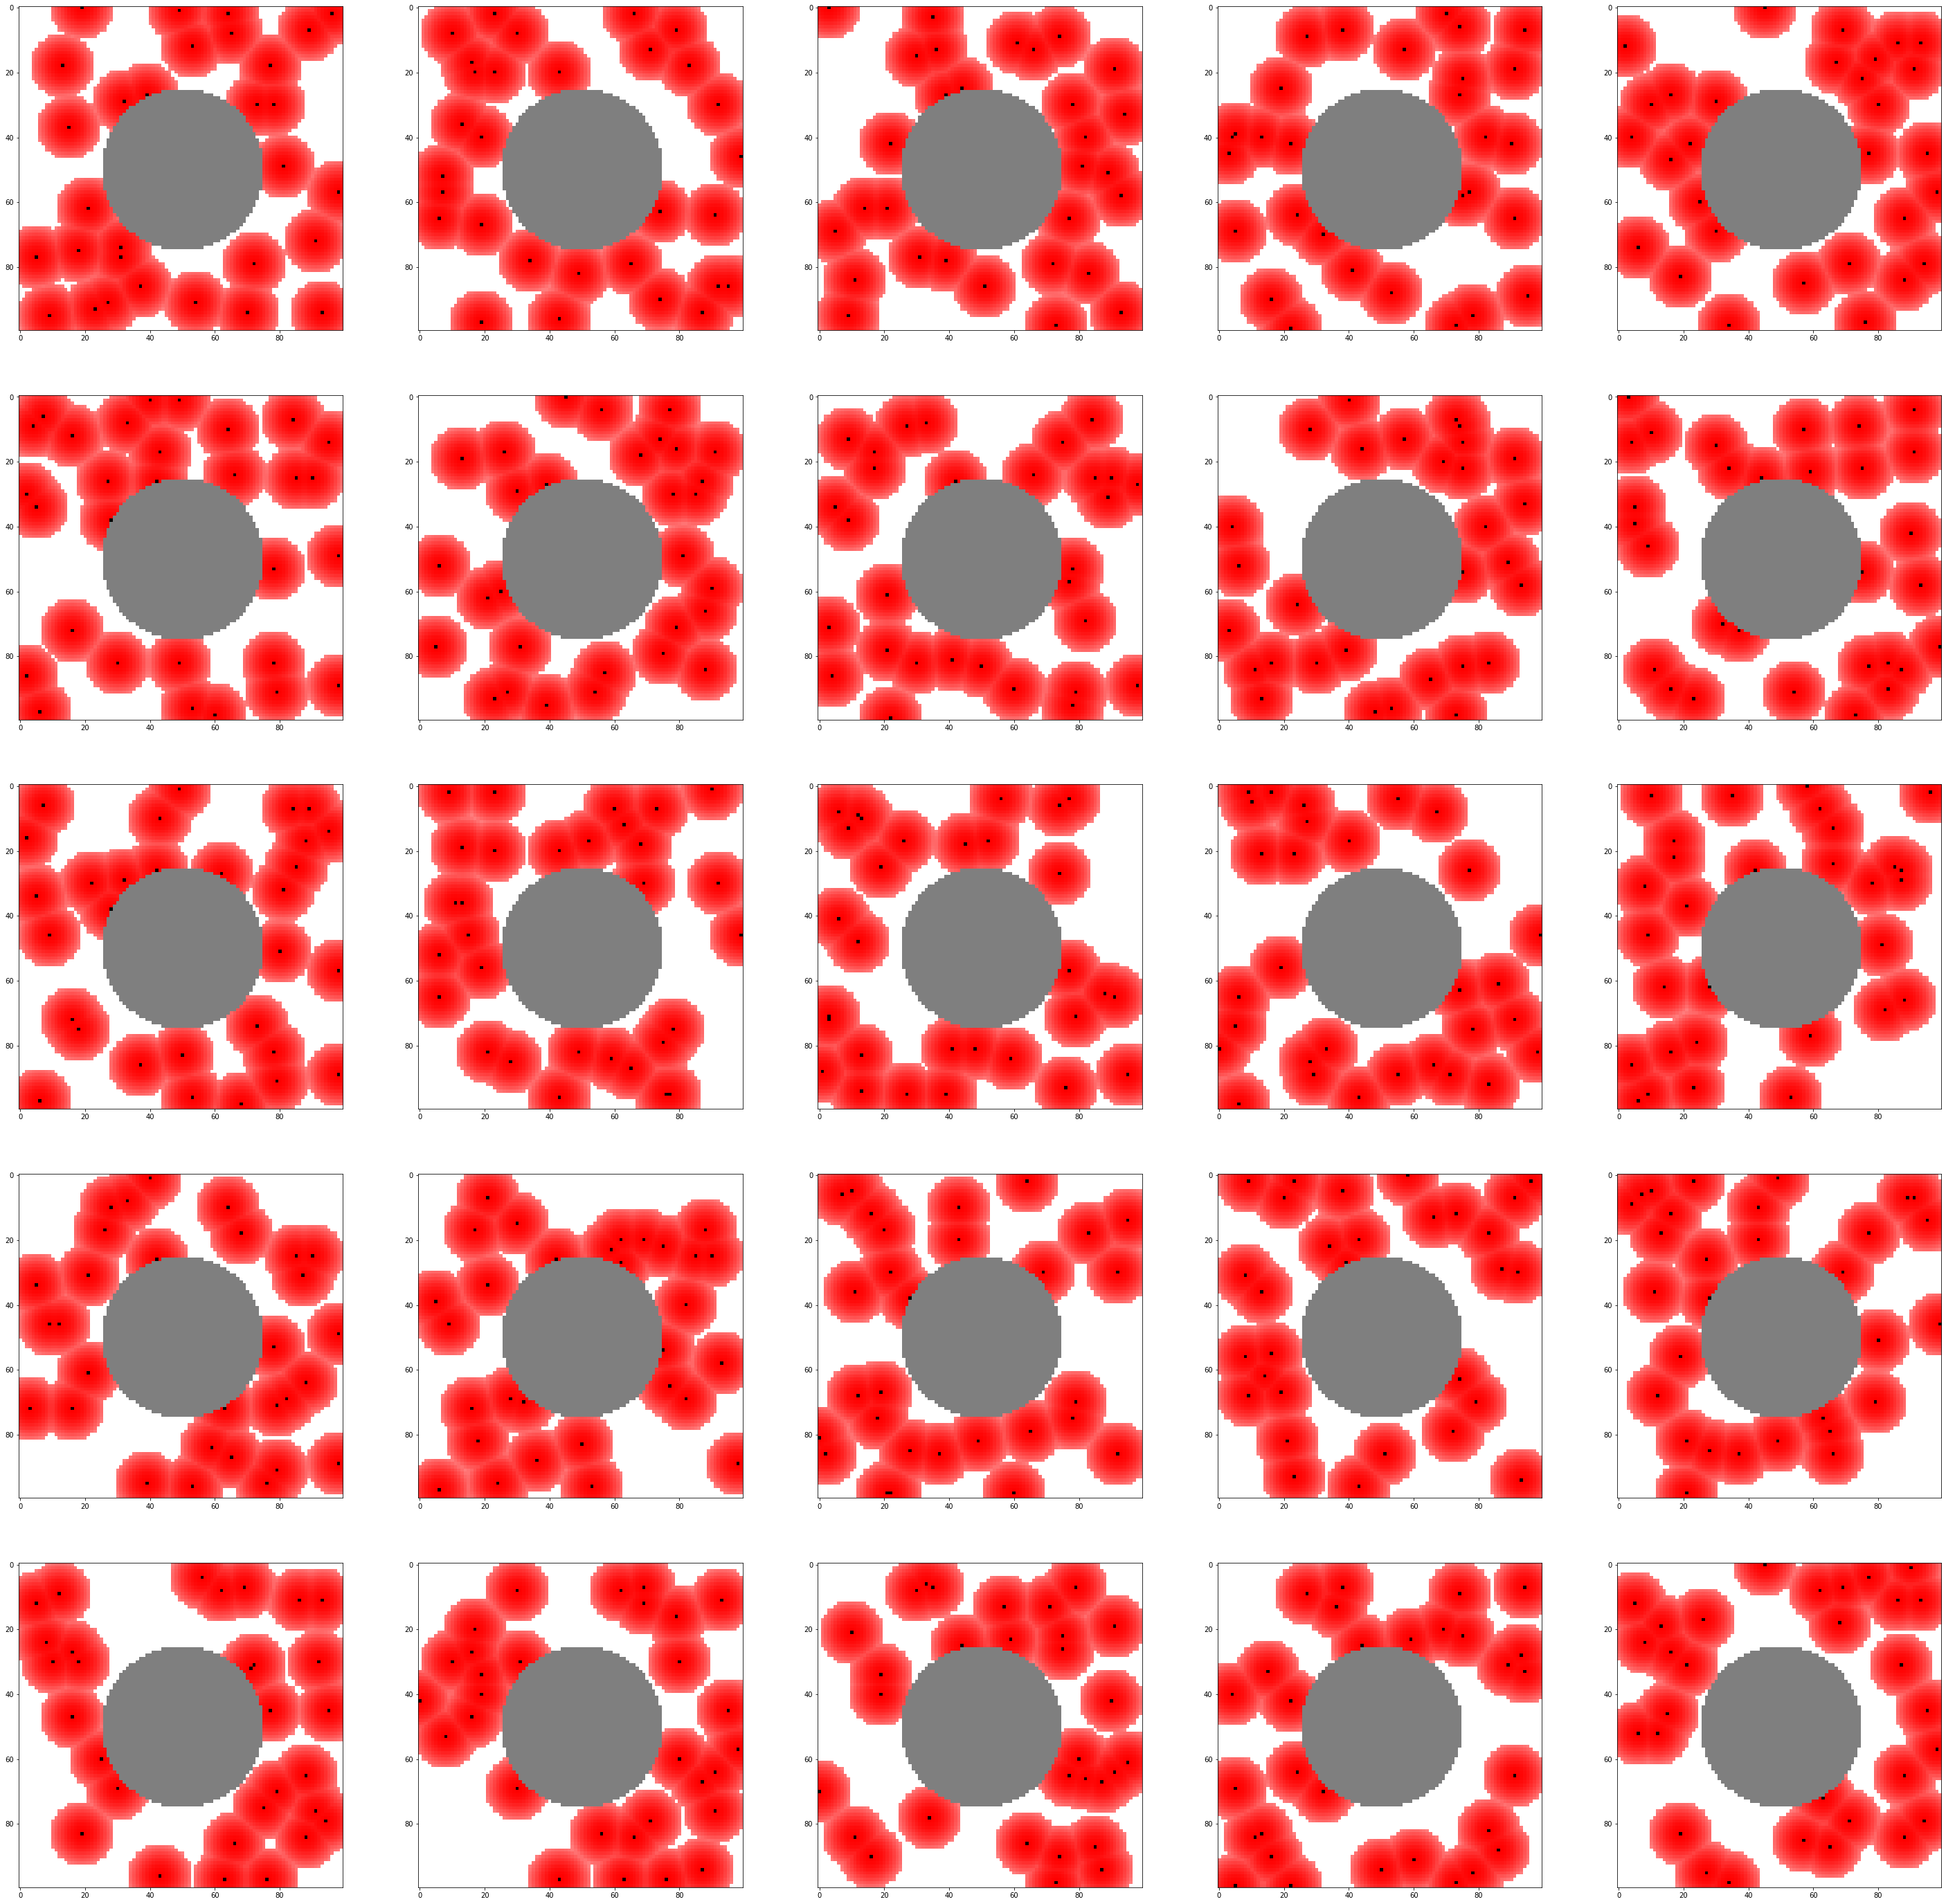

Generation 4
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2408. 2216.
 1954. 1932. 1916. 1747. 1716. 1701. 1571. 1517. 1507. 1448. 1384. 1257.
 1214.]
Previous generation score average 3190.72
[8.88902372e-02 8.76362680e-02 8.63216229e-02 8.57755395e-02
 8.55732864e-02 8.50474284e-02 8.44406691e-02 8.31260239e-02
 8.28833202e-02 8.28024189e-02 2.41692454e-02 2.02859859e-02
 1.49869547e-02 1.45419979e-02 1.42183929e-02 1.08003155e-02
 1.01733309e-02 9.86995126e-03 7.24066096e-03 6.14849423e-03
 5.94624113e-03 4.75294784e-03 3.45852800e-03 8.89913638e-04
 2.02253100e-05]


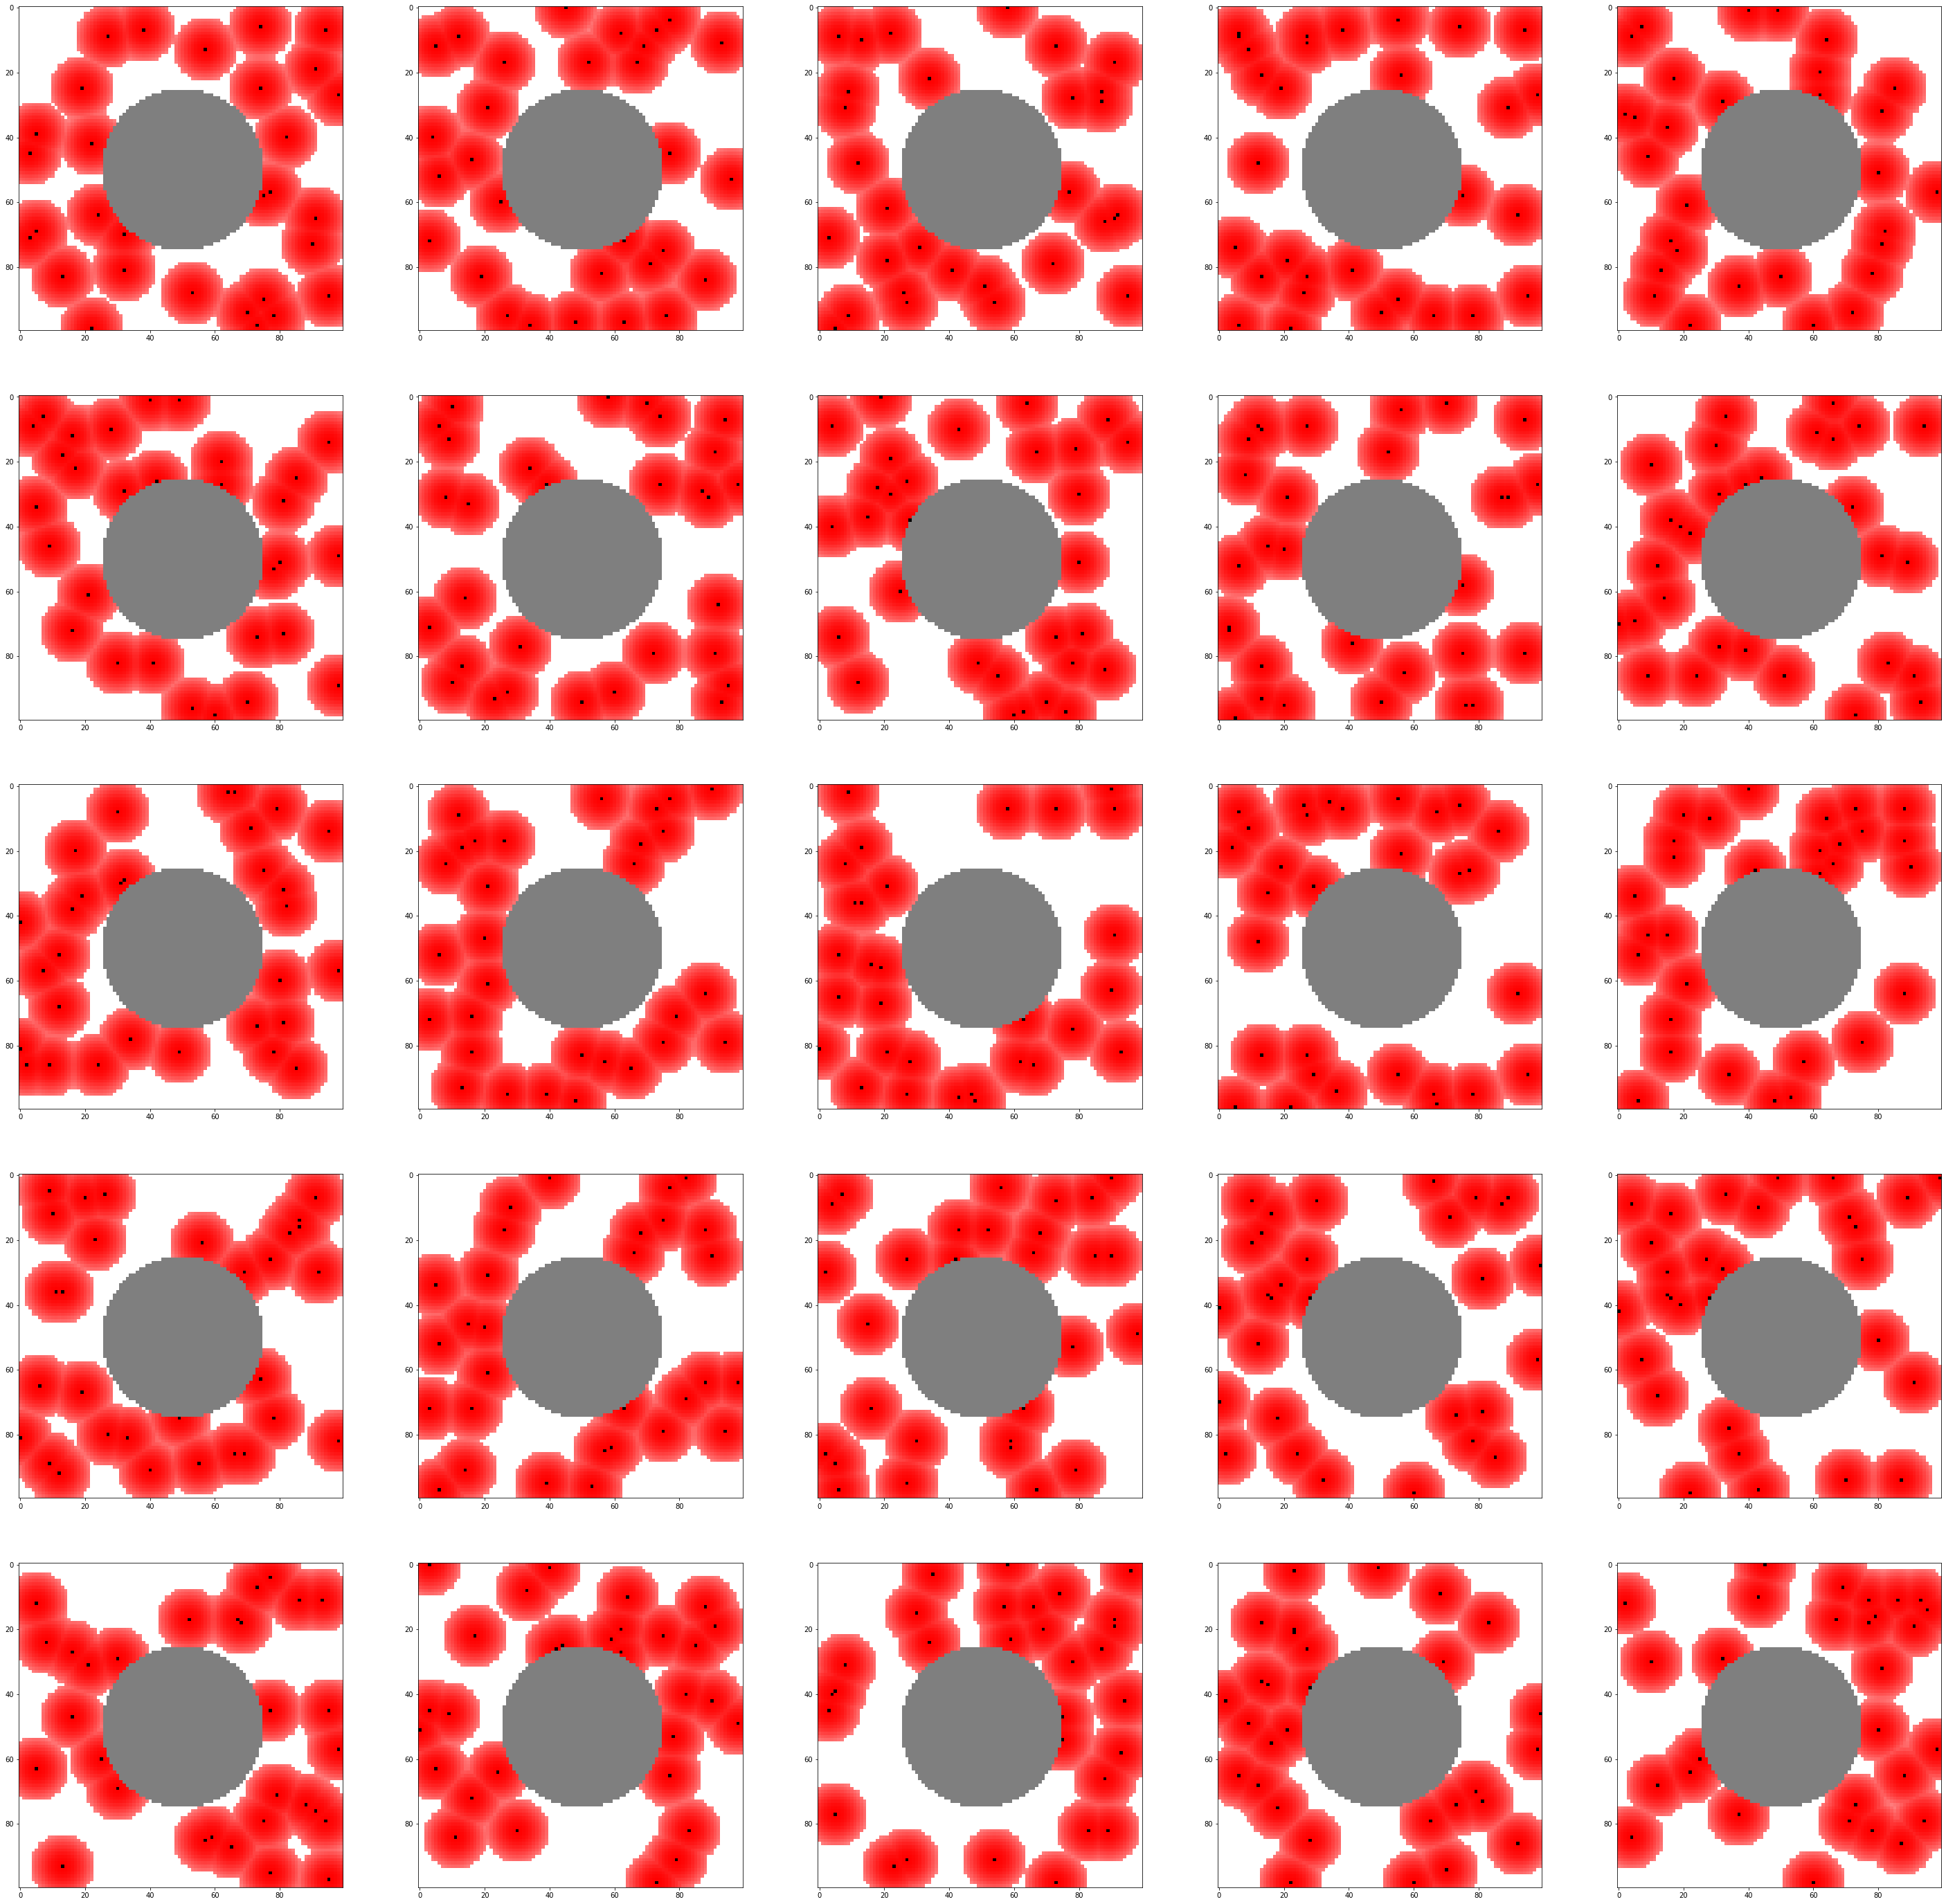

Generation 5
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2732. 2297.
 1859. 1820. 1548. 1519. 1512. 1505. 1461. 1405. 1299. 1291. 1261. 1248.
 1240.]
Previous generation score average 3131.08
[9.23639592e-02 9.10532324e-02 8.96790833e-02 8.91082829e-02
 8.88968754e-02 8.83472158e-02 8.77129931e-02 8.63388440e-02
 8.60851550e-02 8.60005919e-02 3.15631474e-02 2.23669189e-02
 1.31072682e-02 1.22827787e-02 6.53249334e-03 5.91941144e-03
 5.77142616e-03 5.62344087e-03 4.69324764e-03 3.50936535e-03
 1.26844531e-03 1.09931927e-03 4.65096613e-04 1.90266796e-04
 2.11407551e-05]


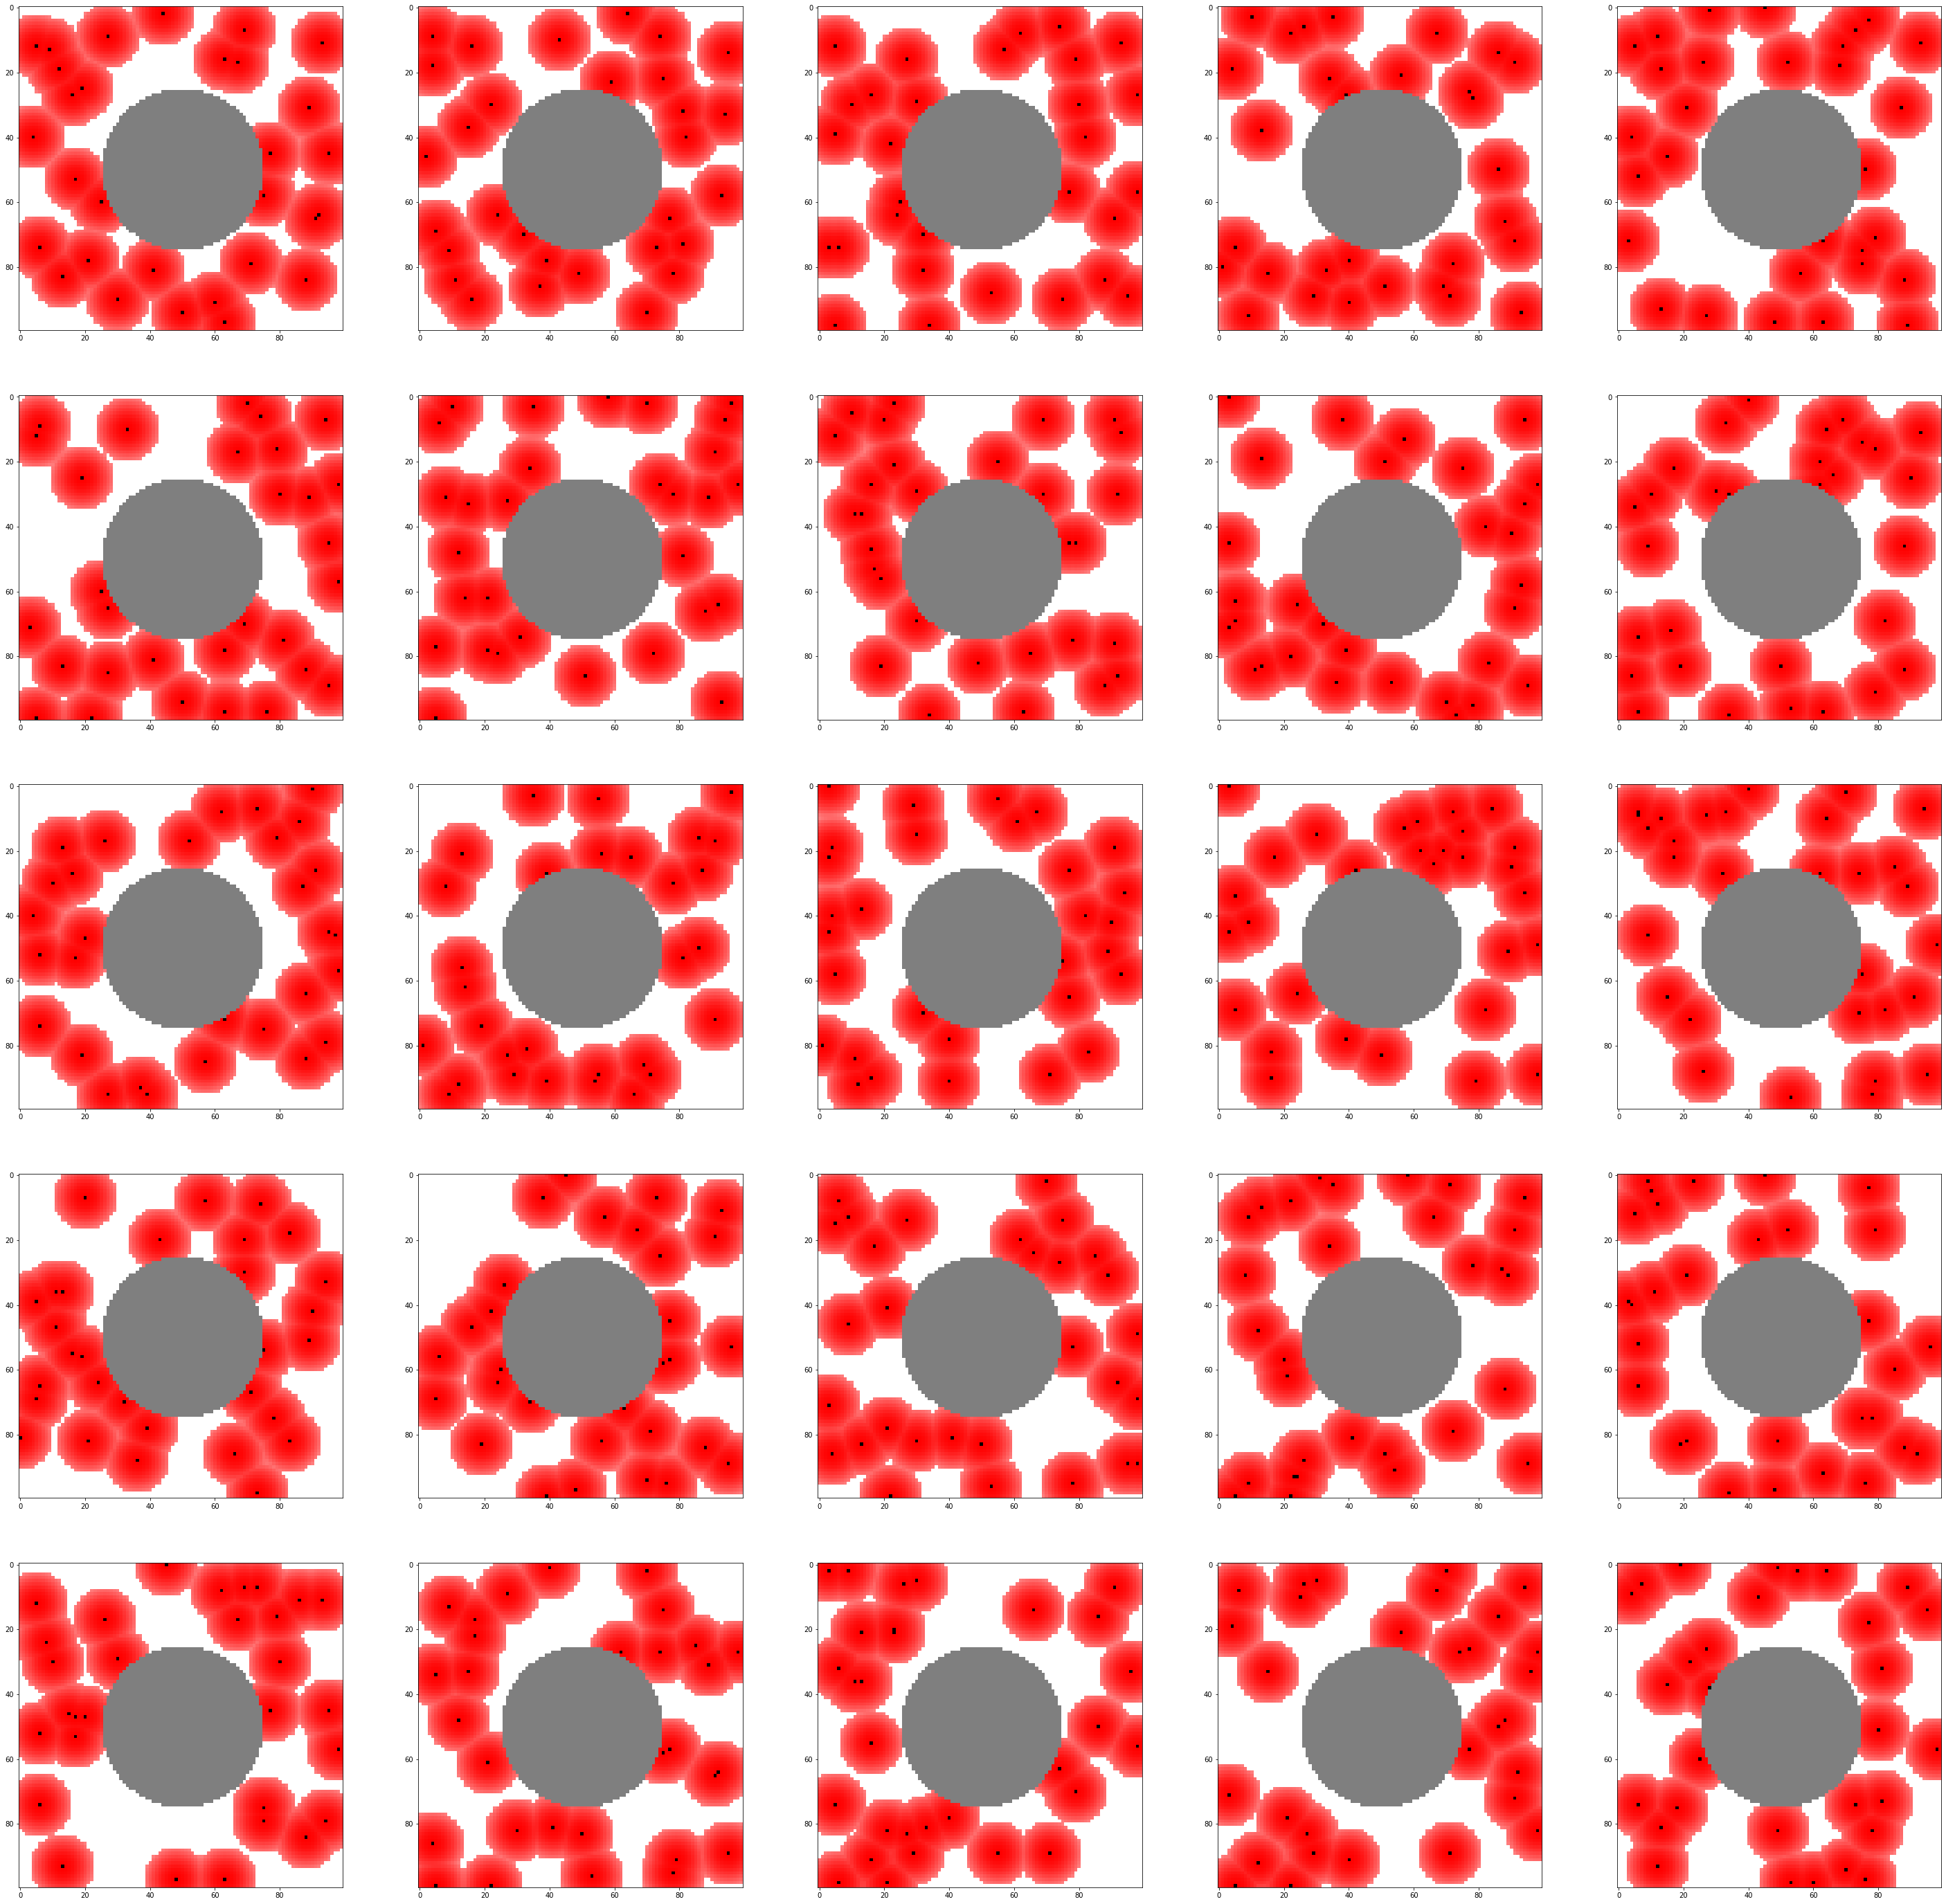

Generation 6
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2401. 2174.
 2014. 2009. 1979. 1765. 1724. 1472. 1447. 1437. 1420. 1406. 1377. 1371.
 1368.]
Previous generation score average 3185.76
[9.32723394e-02 9.19087730e-02 9.04792276e-02 8.98854164e-02
 8.96654864e-02 8.90936682e-02 8.84338780e-02 8.70043326e-02
 8.67404165e-02 8.66524445e-02 2.27407684e-02 1.77483560e-02
 1.42294750e-02 1.41195100e-02 1.34597198e-02 8.75321648e-03
 7.85150322e-03 2.30926565e-03 1.75944050e-03 1.53951044e-03
 1.16562933e-03 8.57727243e-04 2.19930062e-04 8.79720249e-05
 2.19930062e-05]


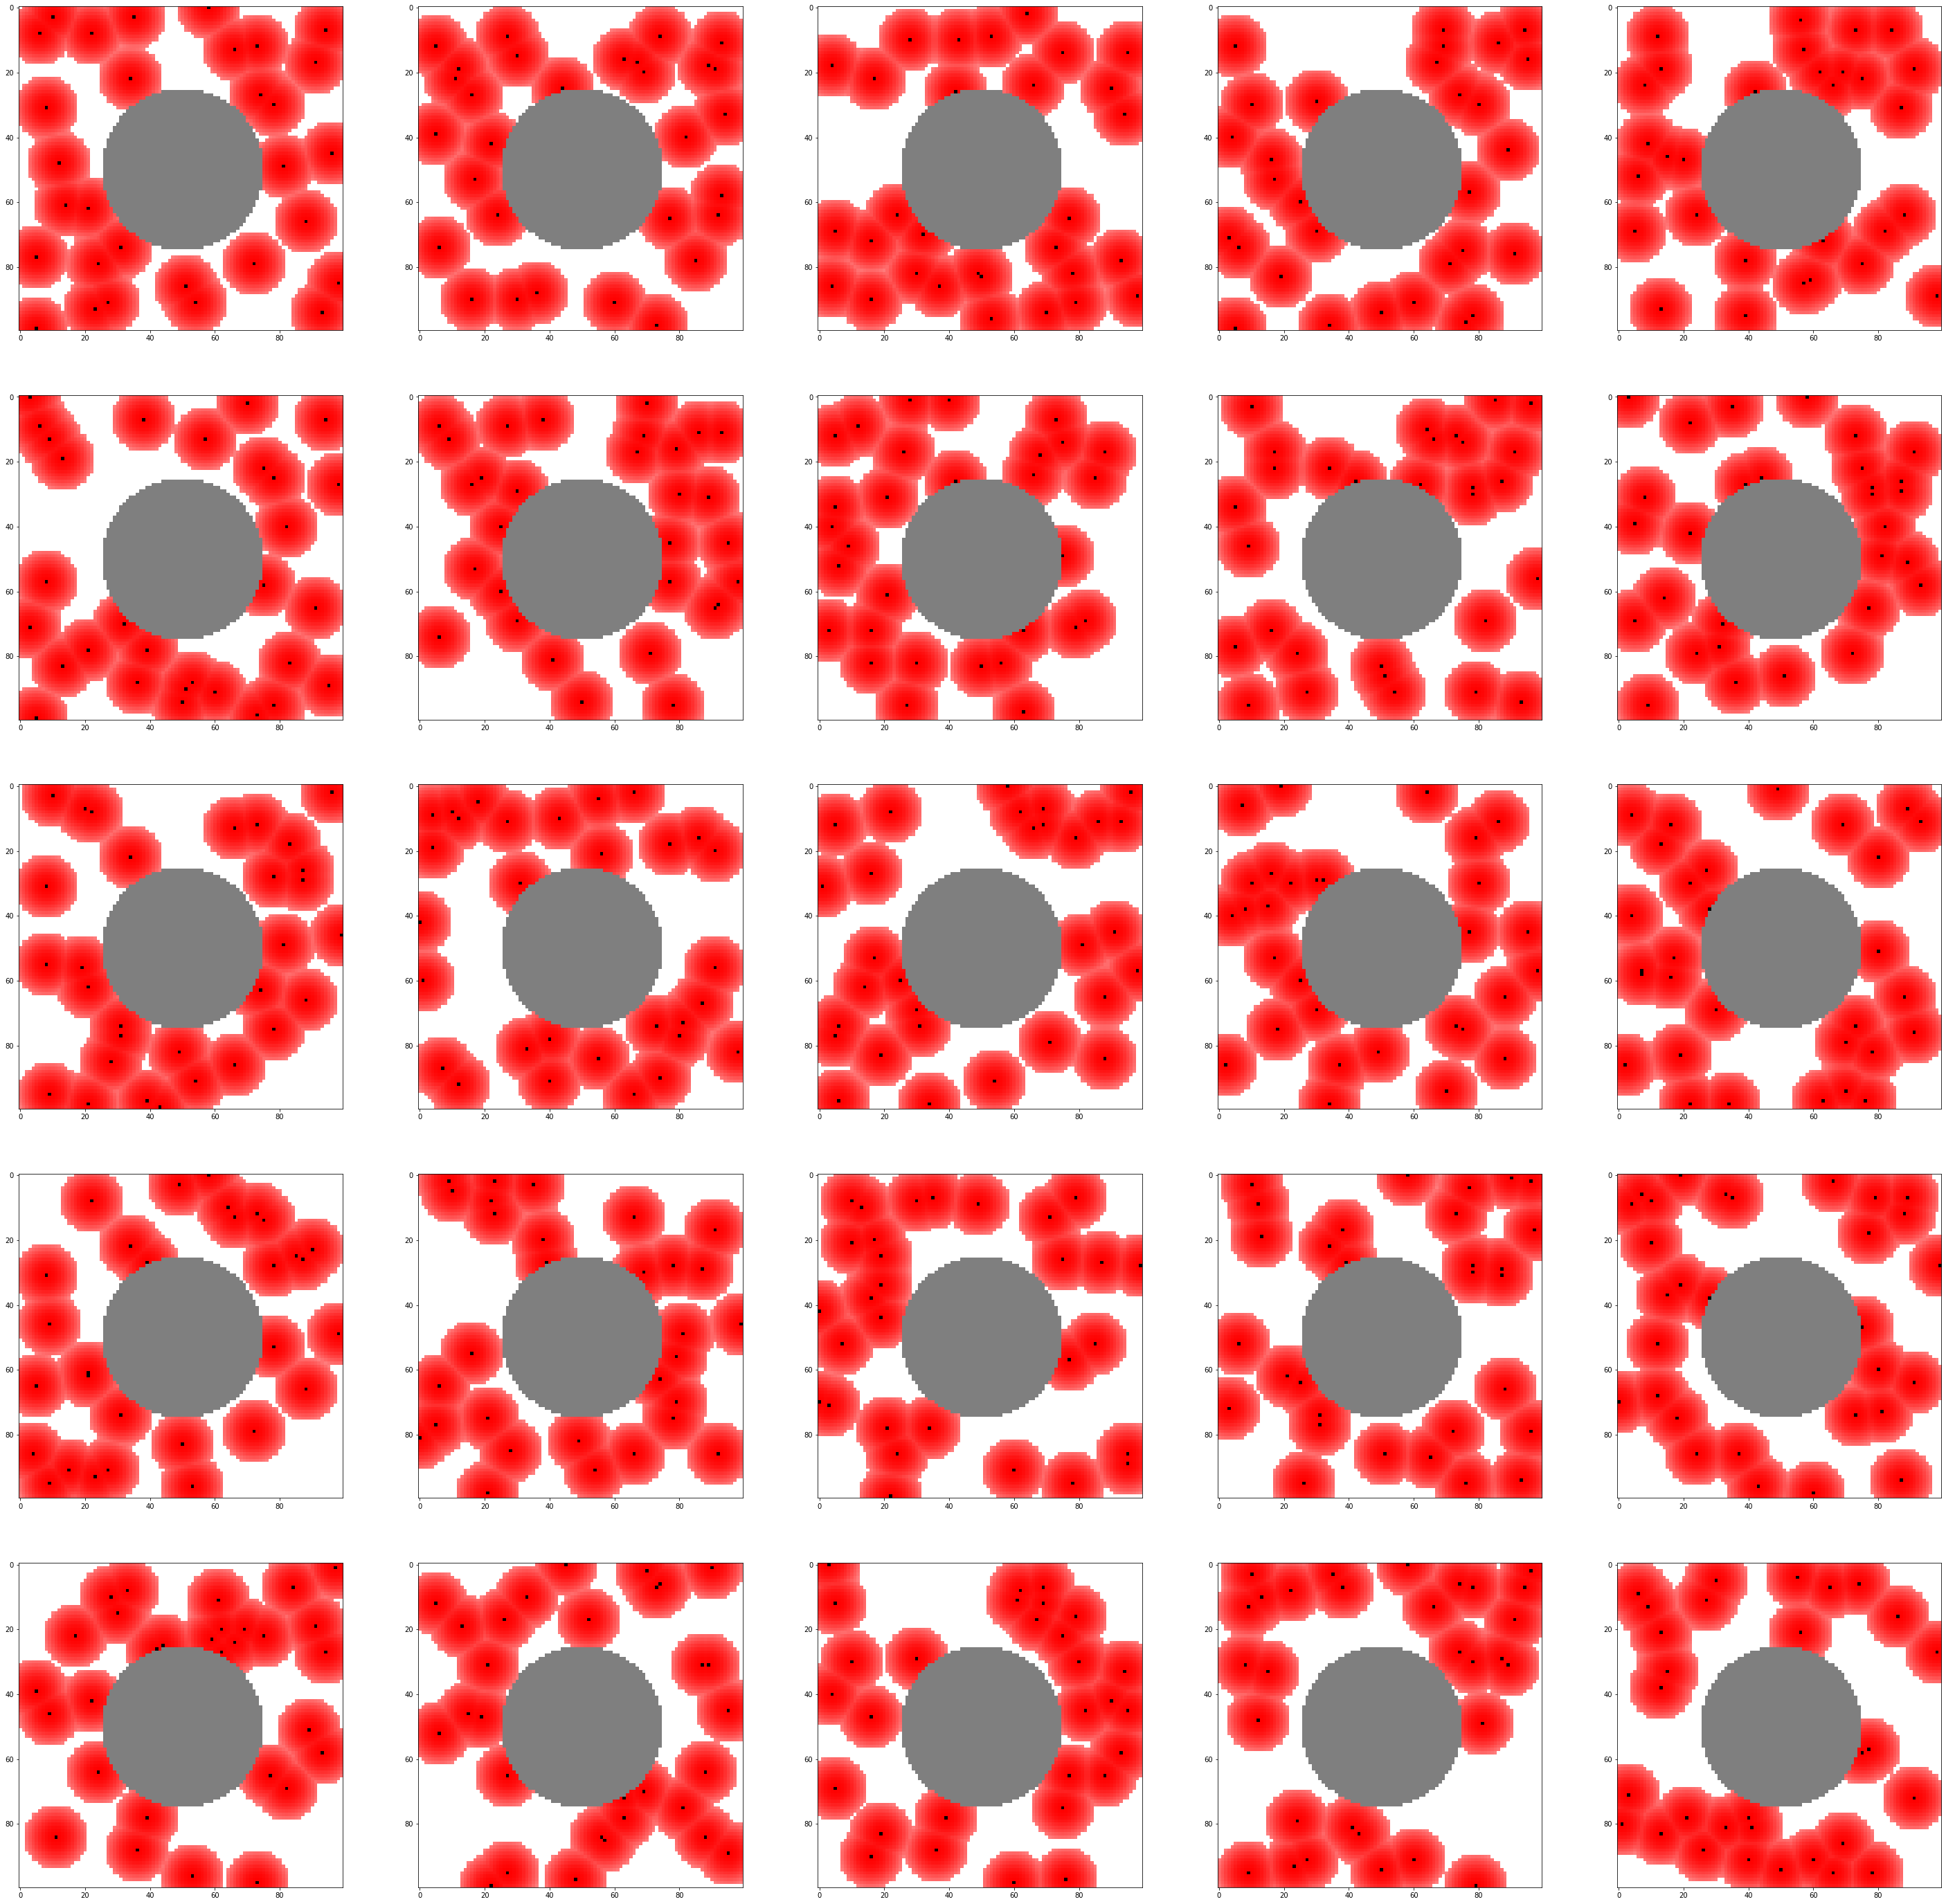

Generation 7
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2462. 2026.
 1871. 1825. 1812. 1649. 1586. 1472. 1457. 1445. 1388. 1381. 1368. 1336.
 1316.]
Previous generation score average 3146.96
[9.37356711e-02 9.23819297e-02 9.09626848e-02 9.03731523e-02
 9.01548069e-02 8.95871089e-02 8.89320728e-02 8.75128278e-02
 8.72508133e-02 8.71634752e-02 2.50442149e-02 1.55243564e-02
 1.21400031e-02 1.11356143e-02 1.08517653e-02 7.29273565e-03
 5.91715976e-03 3.42802245e-03 3.10050438e-03 2.83848992e-03
 1.59392126e-03 1.44107950e-03 1.15723051e-03 4.58525295e-04
 2.18345379e-05]


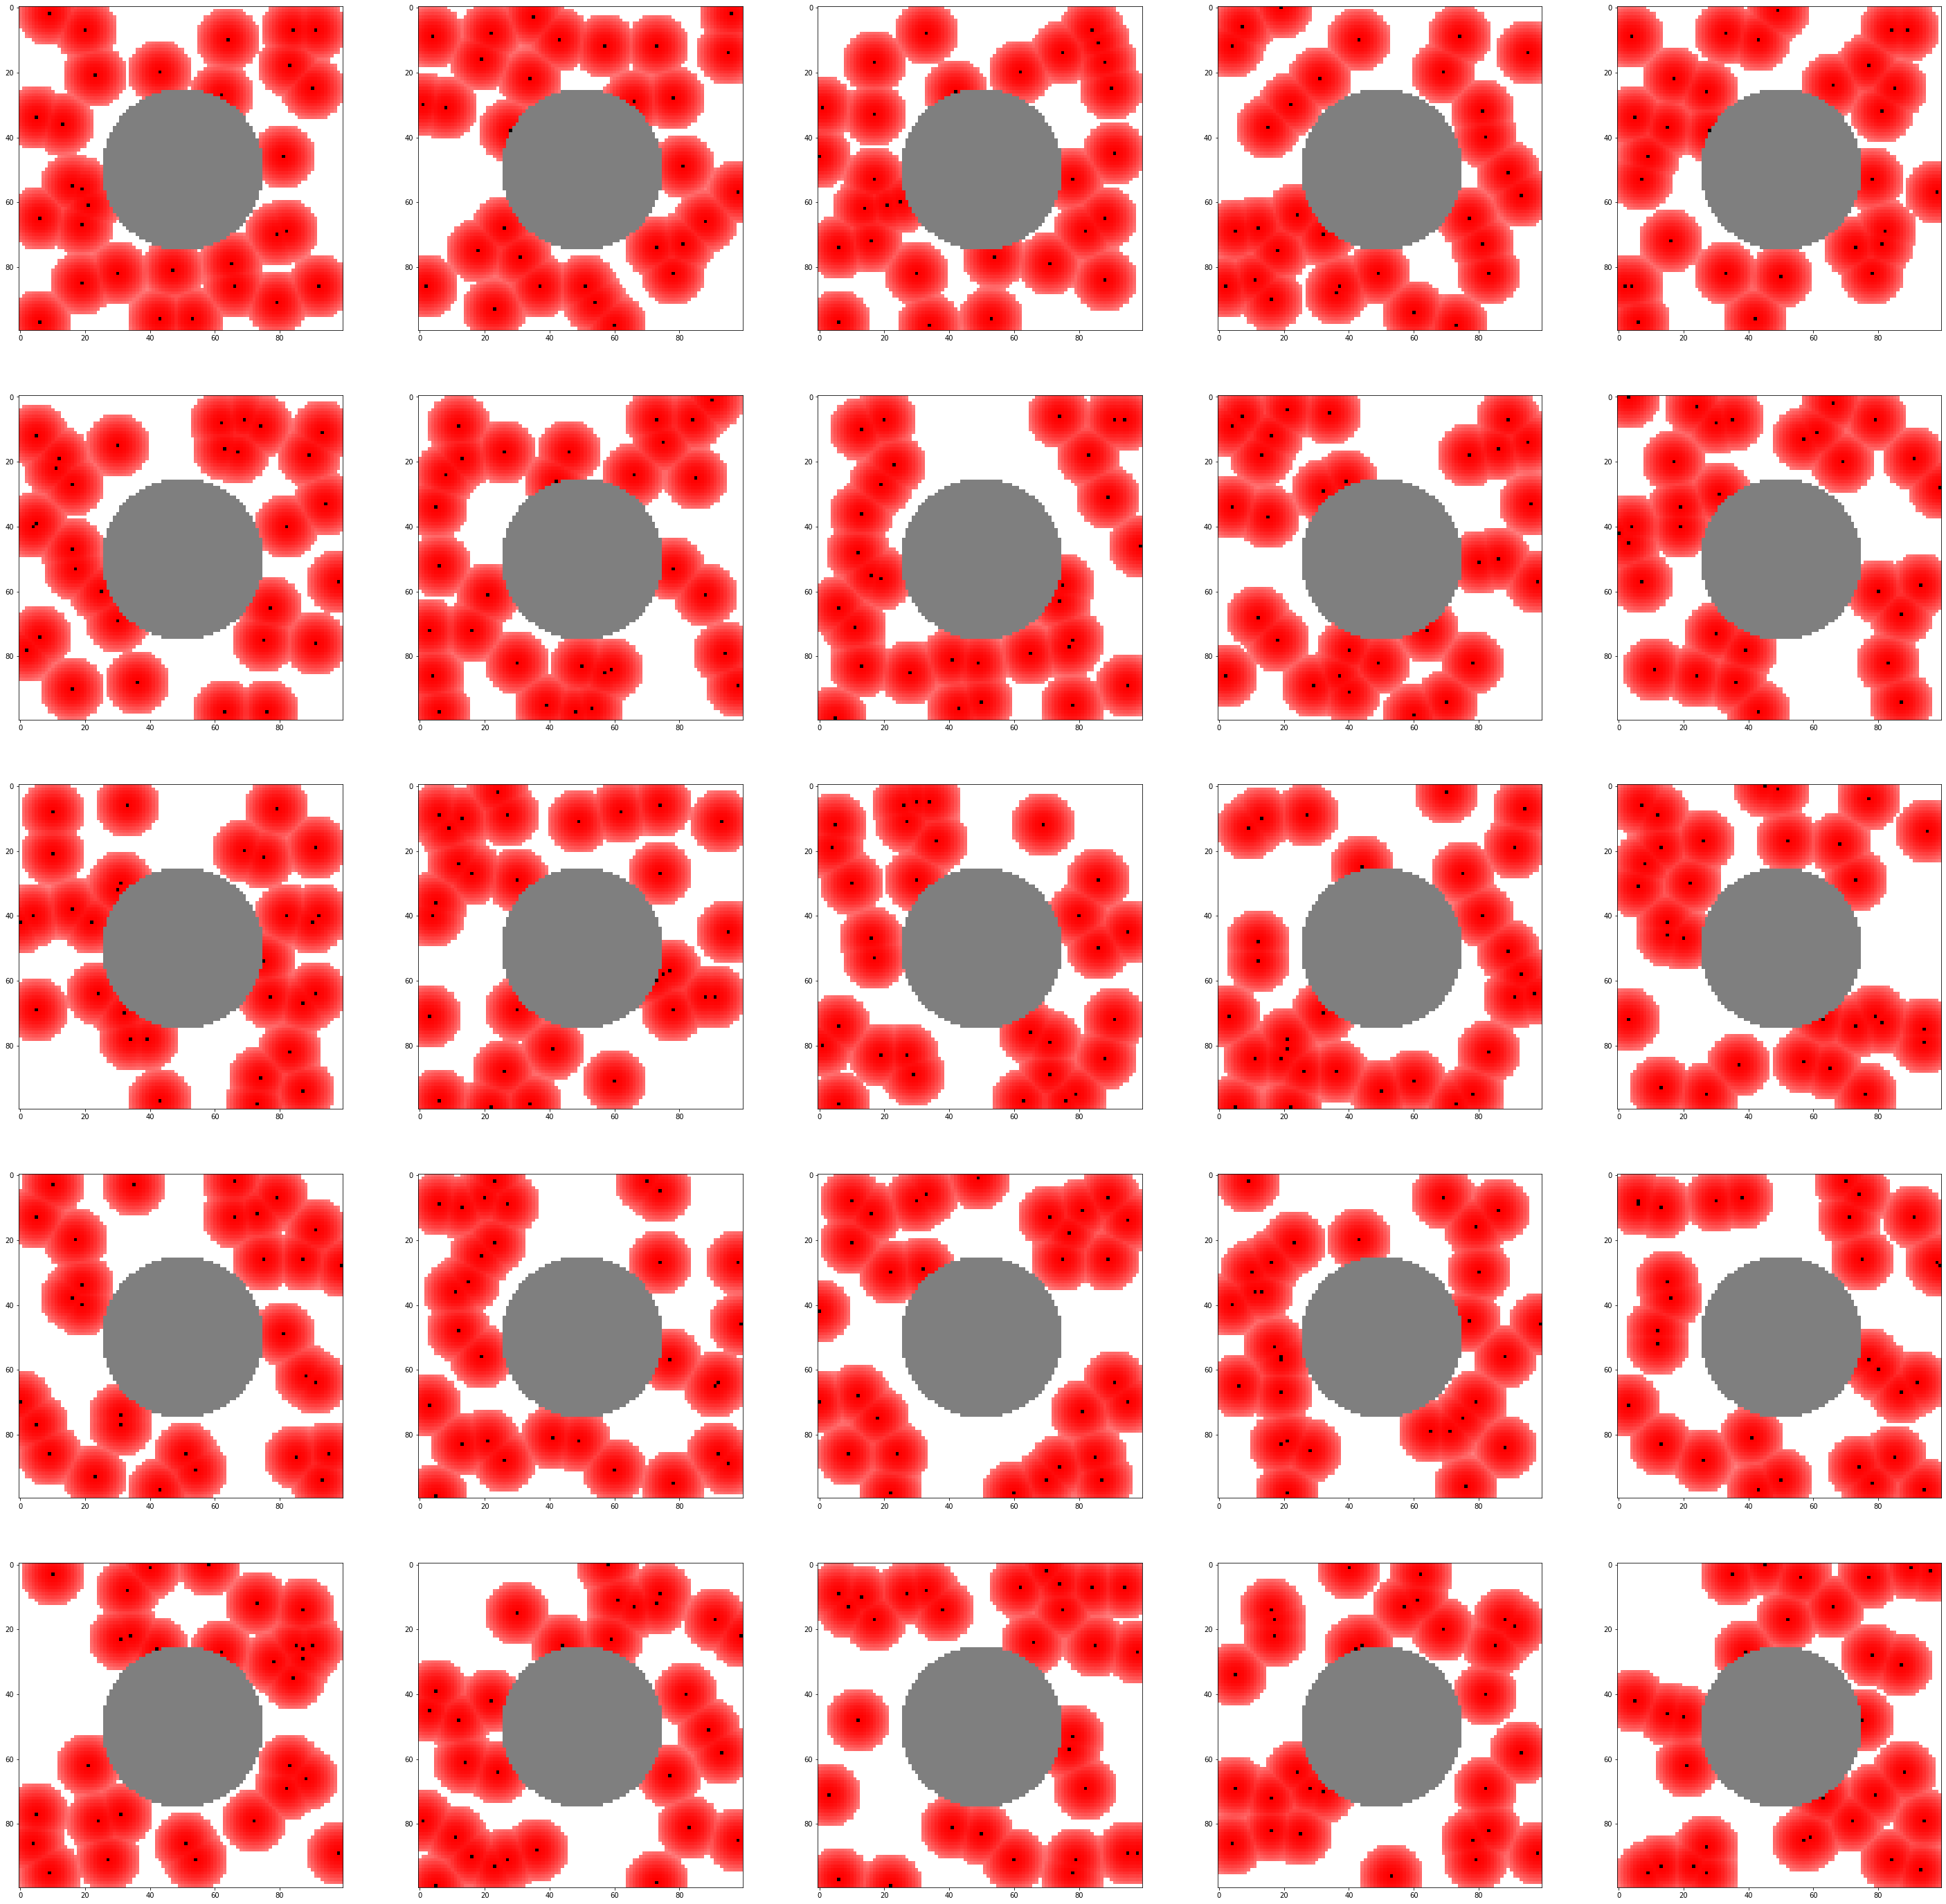

Generation 8
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2613. 2233.
 1985. 1694. 1558. 1542. 1504. 1327. 1310. 1291. 1196. 1193. 1181. 1133.
  958.]
Previous generation score average 3079.92
[8.76340135e-02 8.64658112e-02 8.52410830e-02 8.47323498e-02
 8.45439301e-02 8.40540388e-02 8.34887796e-02 8.22640514e-02
 8.20379477e-02 8.19625798e-02 3.12023063e-02 2.40423568e-02
 1.93695476e-02 1.38865336e-02 1.13240254e-02 1.10225538e-02
 1.03065589e-02 6.97152978e-03 6.65121625e-03 6.29321877e-03
 4.50323140e-03 4.44670548e-03 4.22060181e-03 3.31618714e-03
 1.88419724e-05]


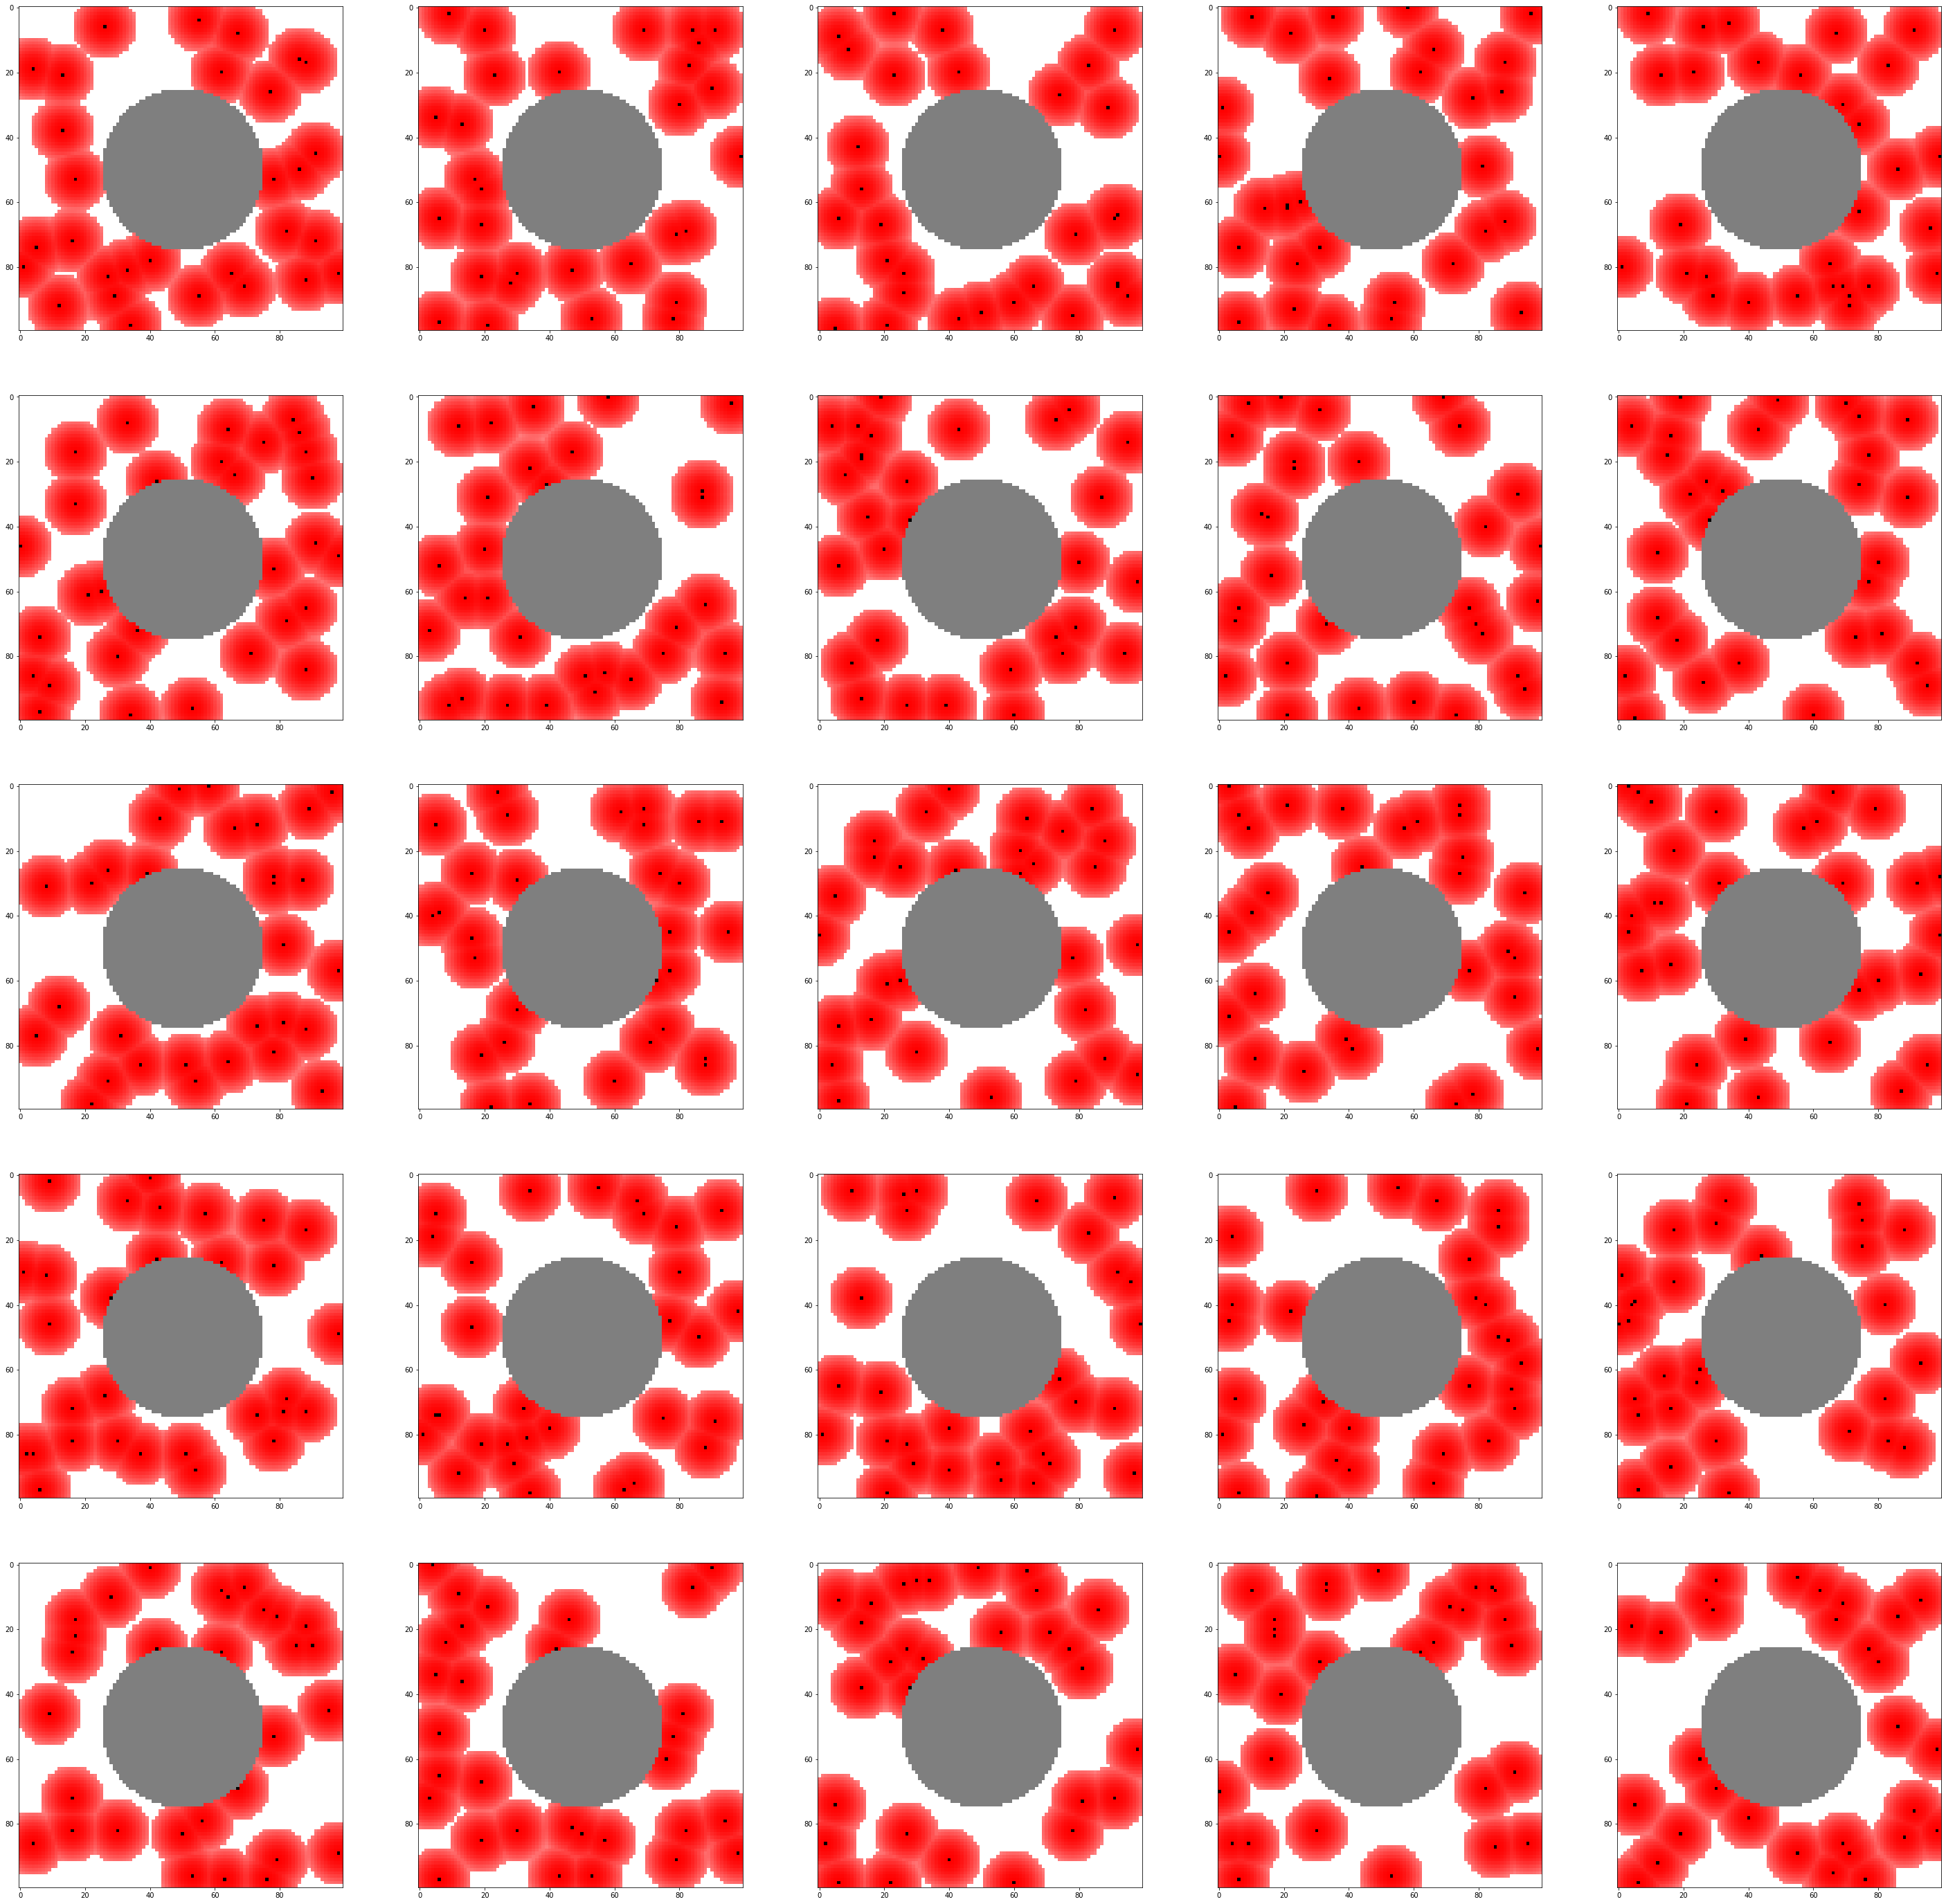

Generation 9
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2324. 2270.
 2092. 1833. 1832. 1769. 1534. 1518. 1485. 1381. 1377. 1359. 1346. 1311.
 1297.]
Previous generation score average 3160.32
[9.25163062e-02 9.11860625e-02 8.97914521e-02 8.92121524e-02
 8.89975970e-02 8.84397528e-02 8.77960865e-02 8.64014761e-02
 8.61440096e-02 8.60581874e-02 2.20562993e-02 2.08977000e-02
 1.70786131e-02 1.15216272e-02 1.15001716e-02 1.01484724e-02
 5.10641950e-03 4.76313079e-03 4.05509784e-03 1.82372125e-03
 1.73789907e-03 1.35169928e-03 1.07277721e-03 3.21833162e-04
 2.14555441e-05]


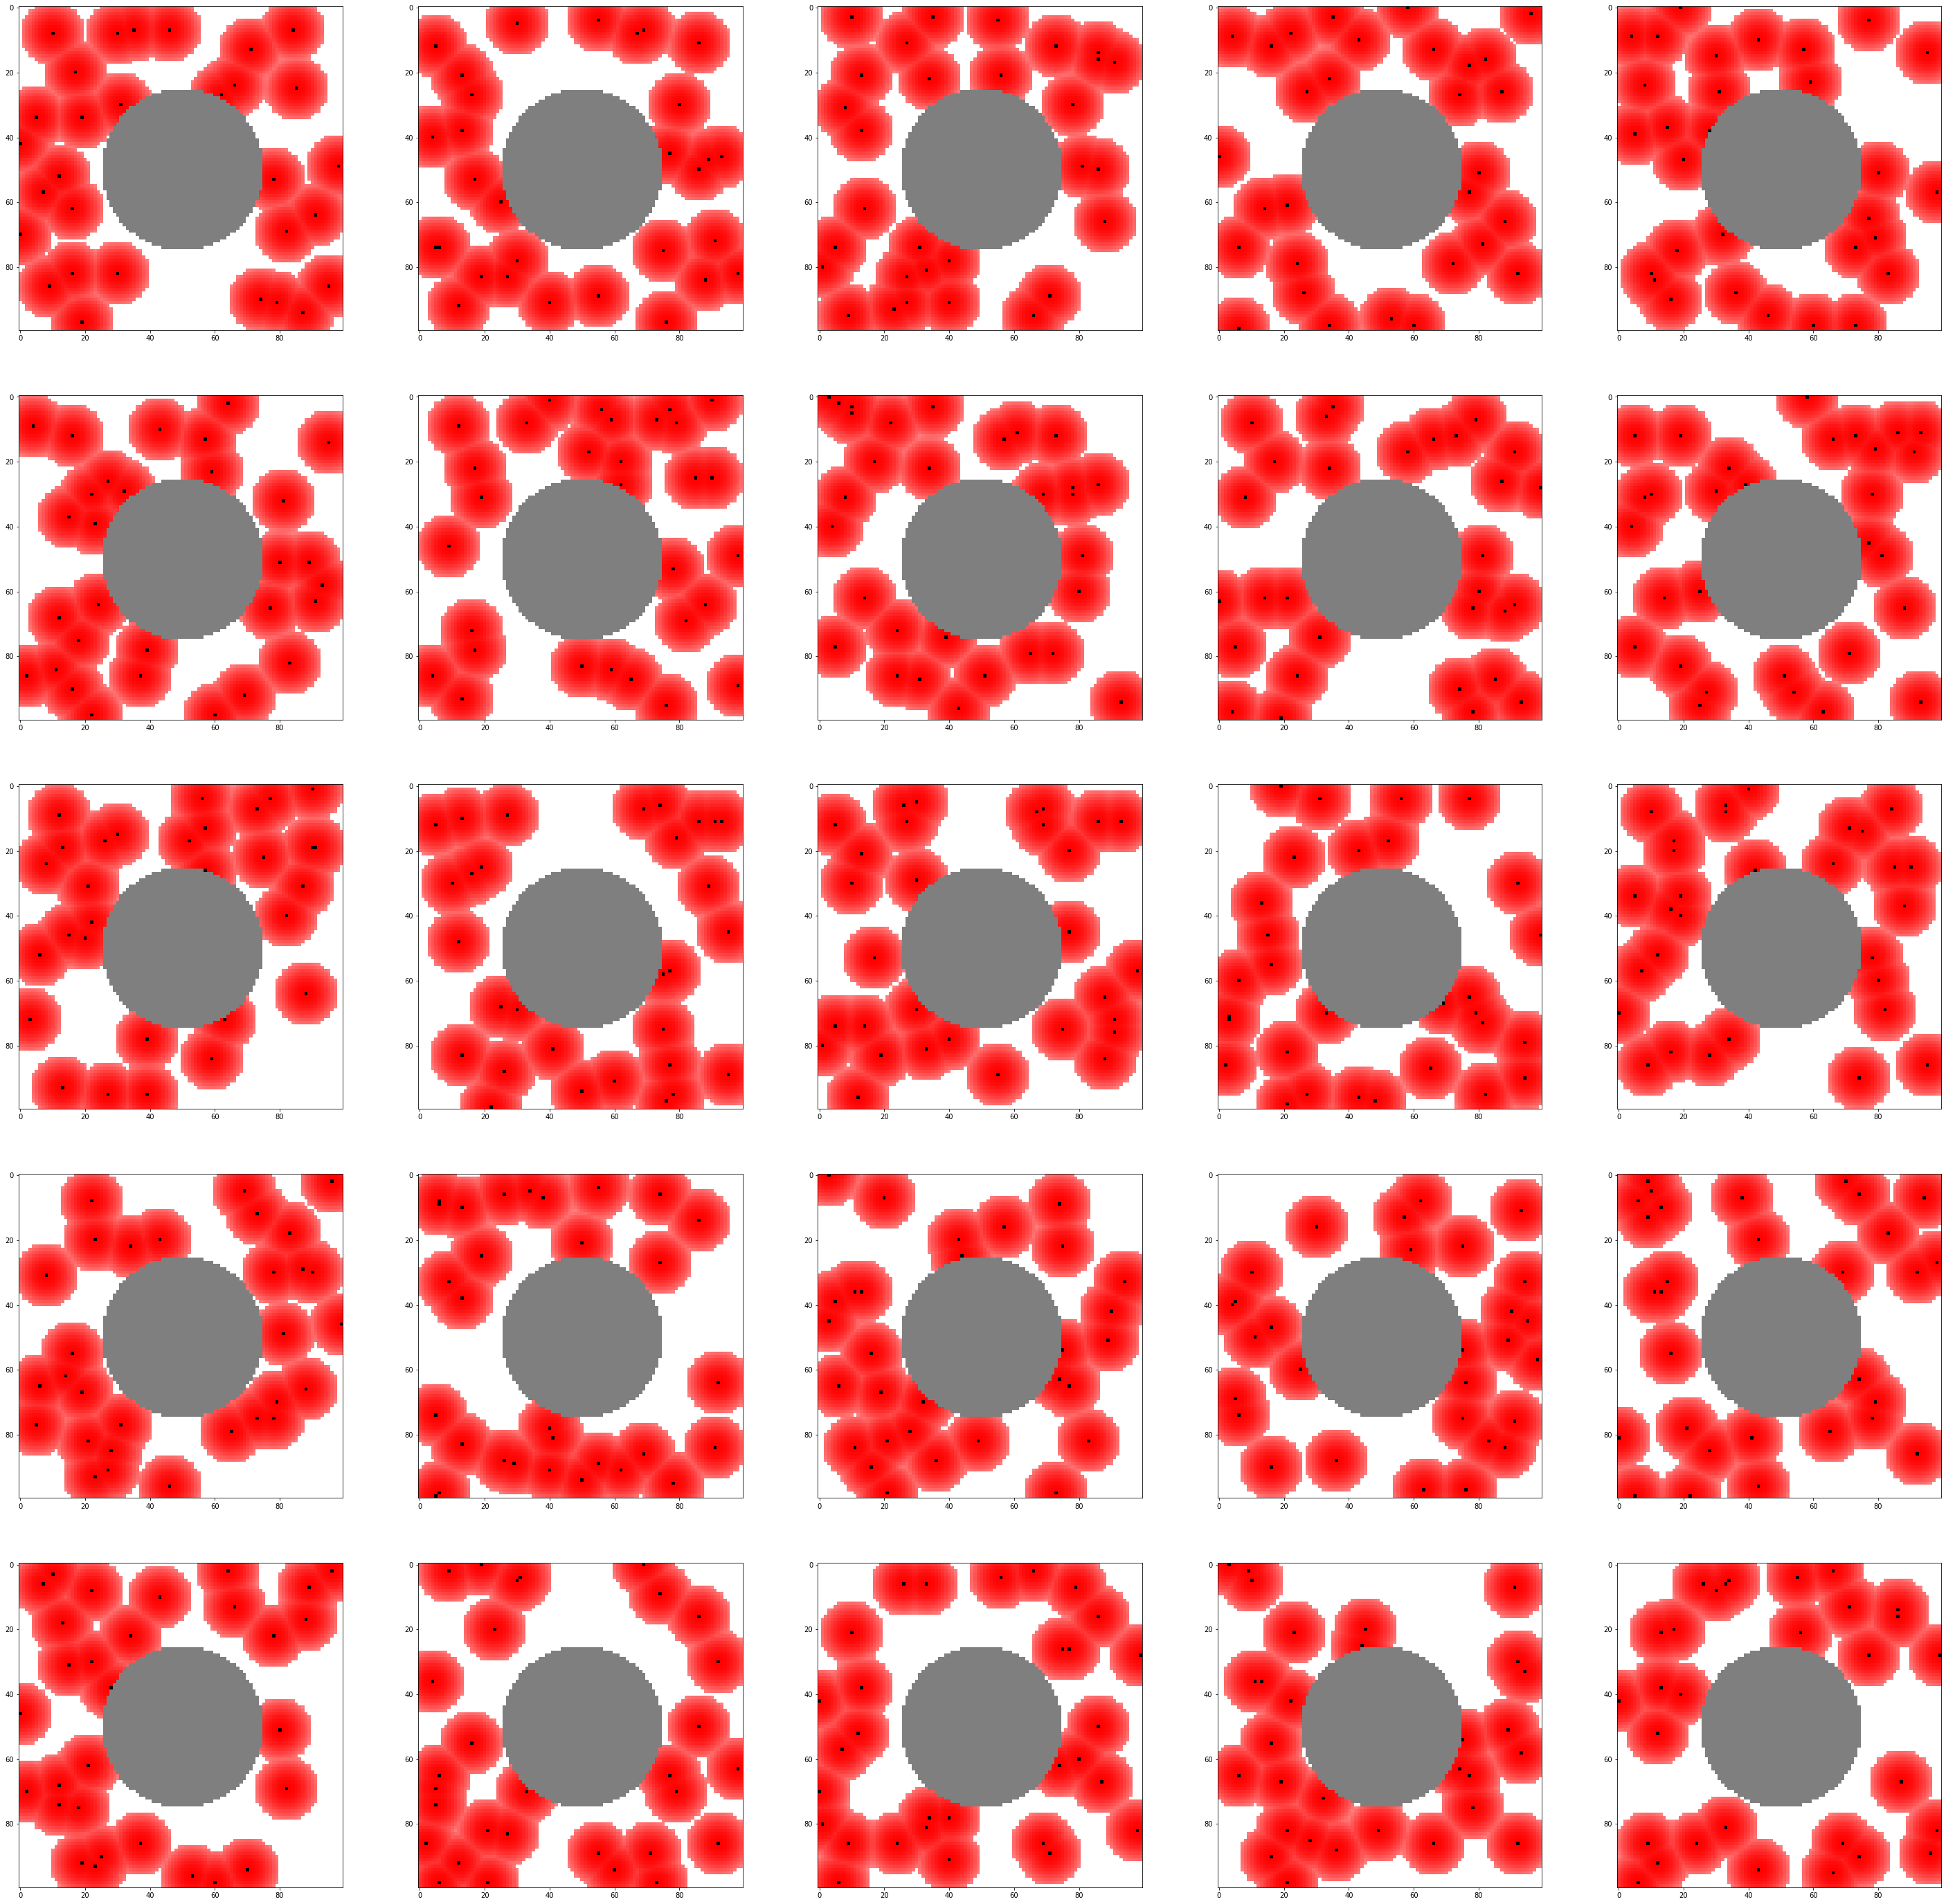

Generation 10
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 1956. 1791.
 1786. 1783. 1717. 1565. 1517. 1502. 1431. 1332. 1297. 1279. 1256. 1166.
 1154.]
Previous generation score average 3072.48
[9.28376435e-02 9.15456269e-02 9.01910934e-02 8.96284410e-02
 8.94200513e-02 8.88782379e-02 8.82530685e-02 8.68985350e-02
 8.66484673e-02 8.65651114e-02 1.67336987e-02 1.32952675e-02
 1.31910726e-02 1.31285557e-02 1.17531832e-02 8.58565862e-03
 7.58538771e-03 7.27280305e-03 5.79323567e-03 3.73017692e-03
 3.00081272e-03 2.62571113e-03 2.14641465e-03 2.70906704e-04
 2.08389772e-05]


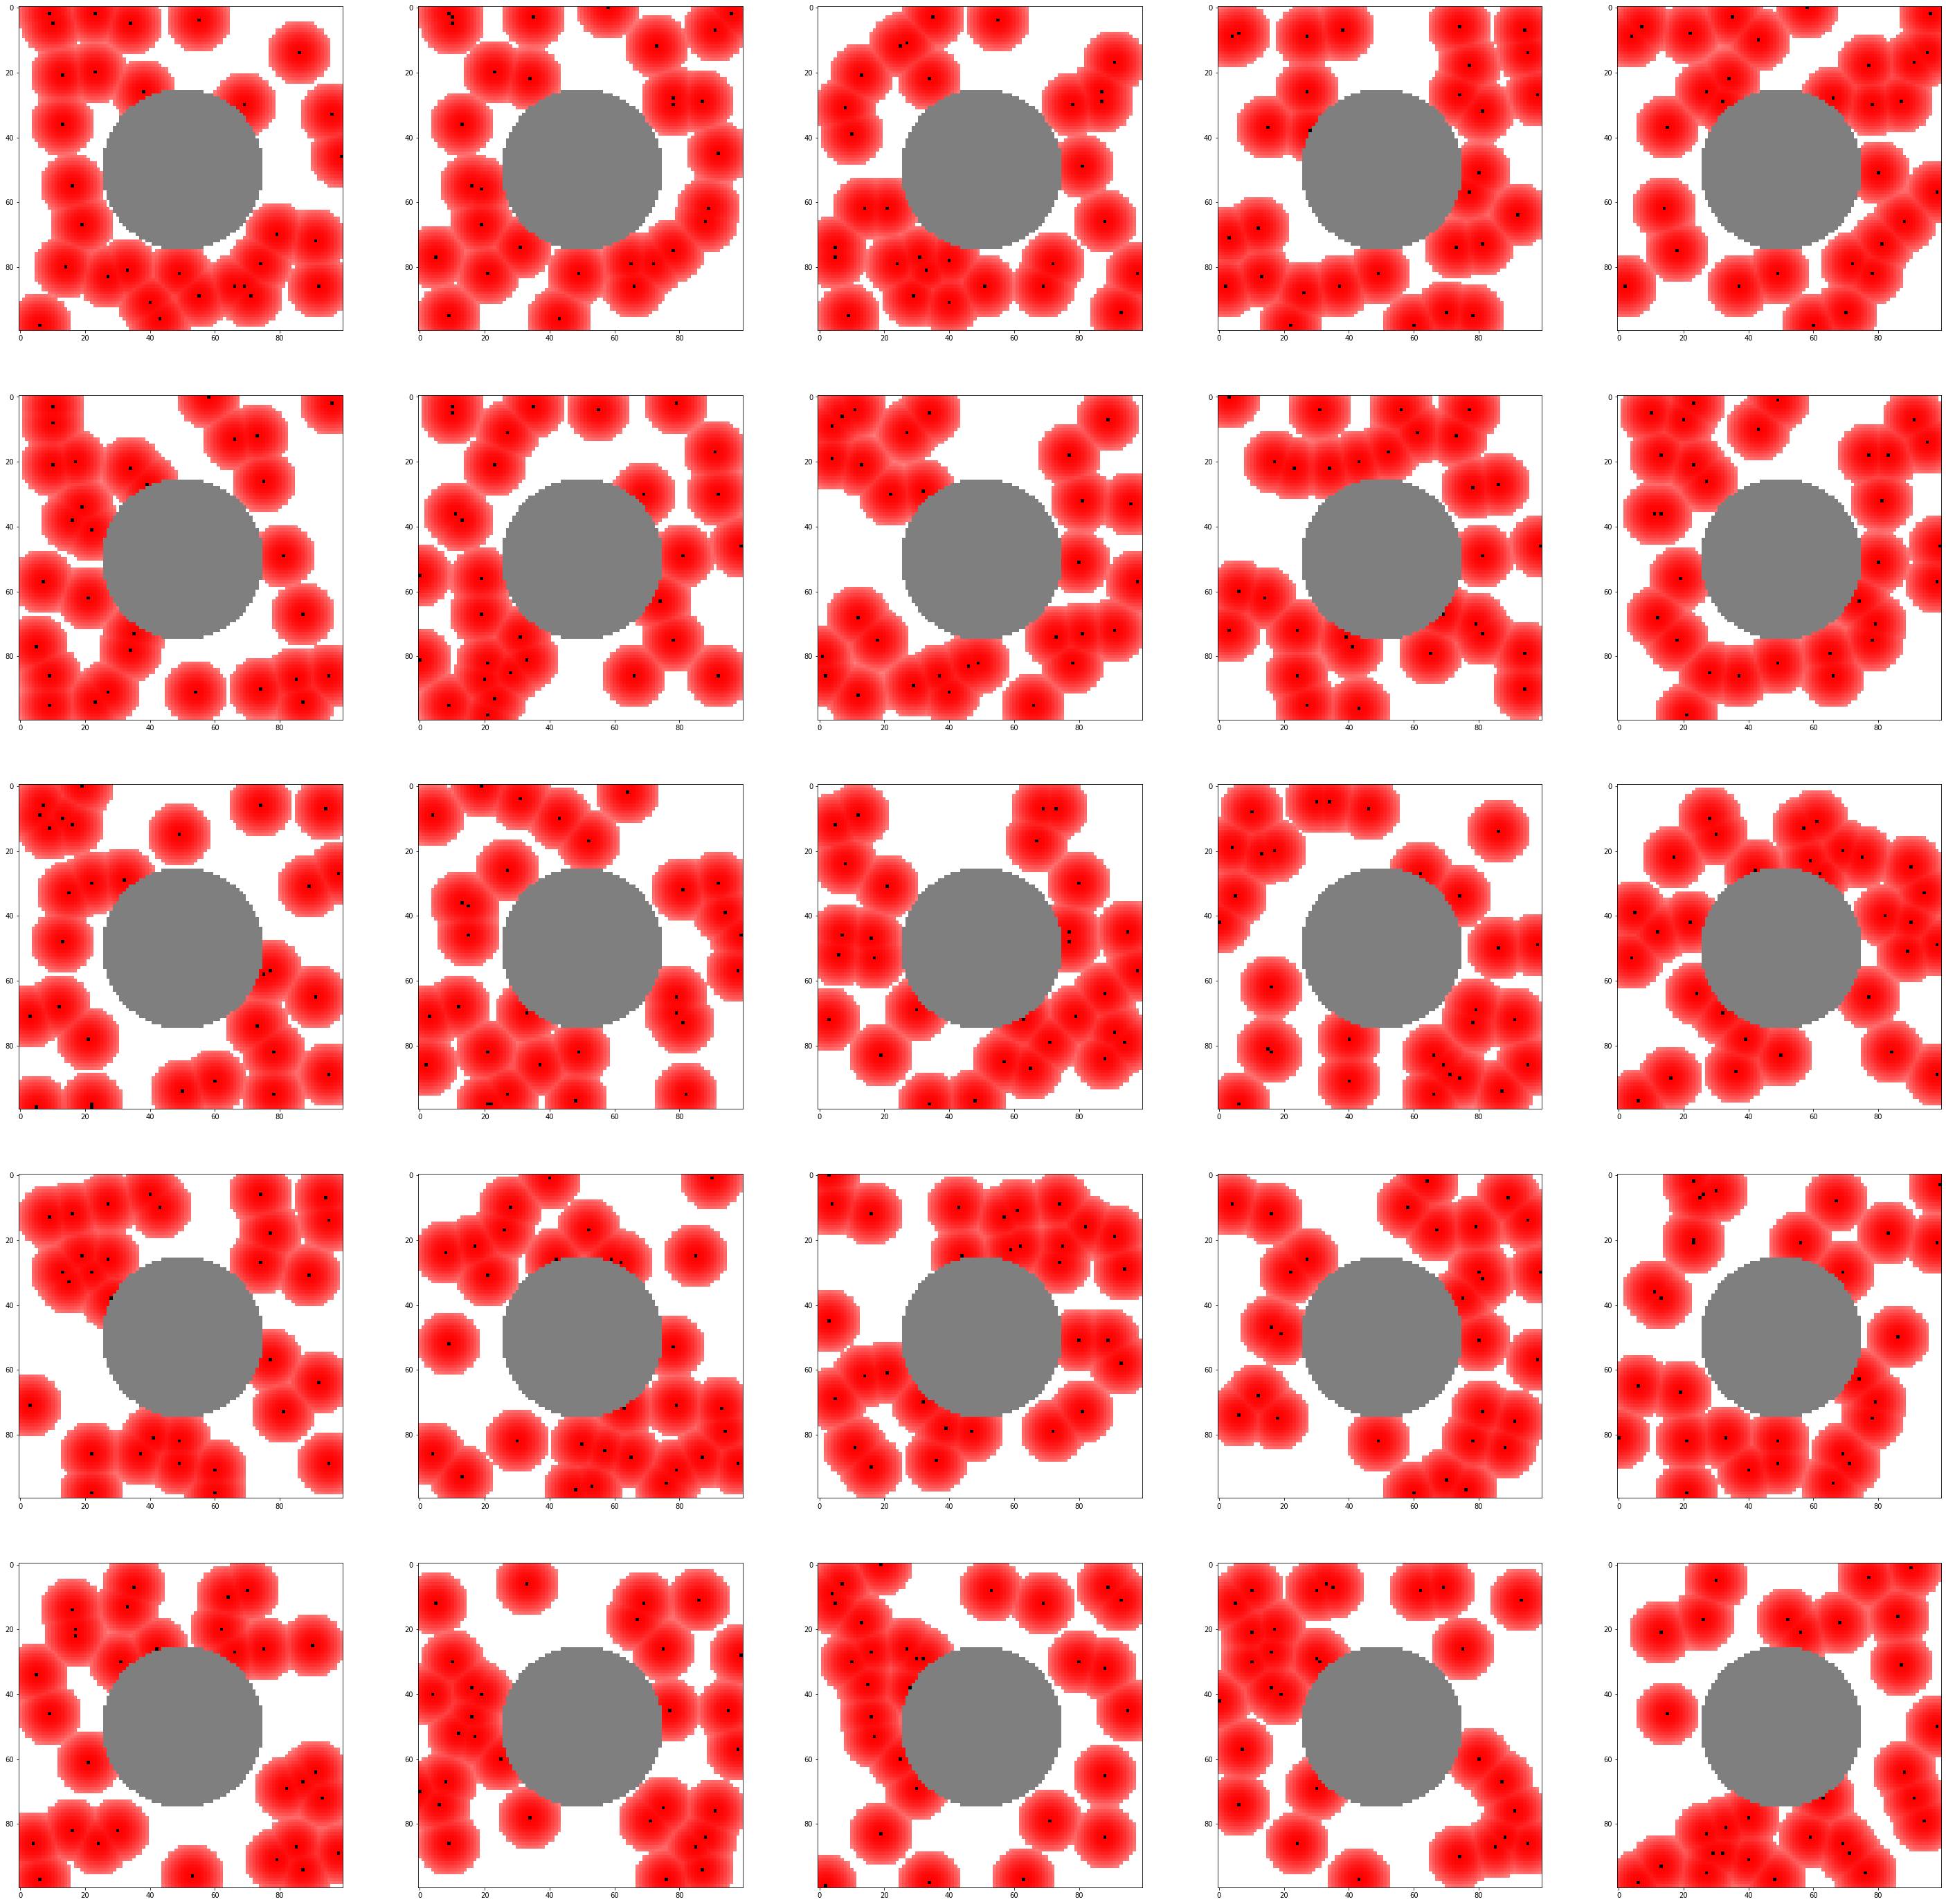

Generation 11
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2007. 1840.
 1803. 1714. 1682. 1648. 1520. 1360. 1351. 1329. 1322. 1236. 1169. 1165.
 1153.]
Previous generation score average 3063.16
[9.32627305e-02 9.19650893e-02 9.06046590e-02 9.00395571e-02
 8.98302602e-02 8.92860880e-02 8.86581971e-02 8.72977668e-02
 8.70466104e-02 8.69628916e-02 1.78948911e-02 1.43996316e-02
 1.36252328e-02 1.17624898e-02 1.10927395e-02 1.03811298e-02
 7.70212855e-03 4.35337701e-03 4.16500973e-03 3.70455640e-03
 3.55804852e-03 1.75809456e-03 3.55804852e-04 2.72086063e-04
 2.09296971e-05]


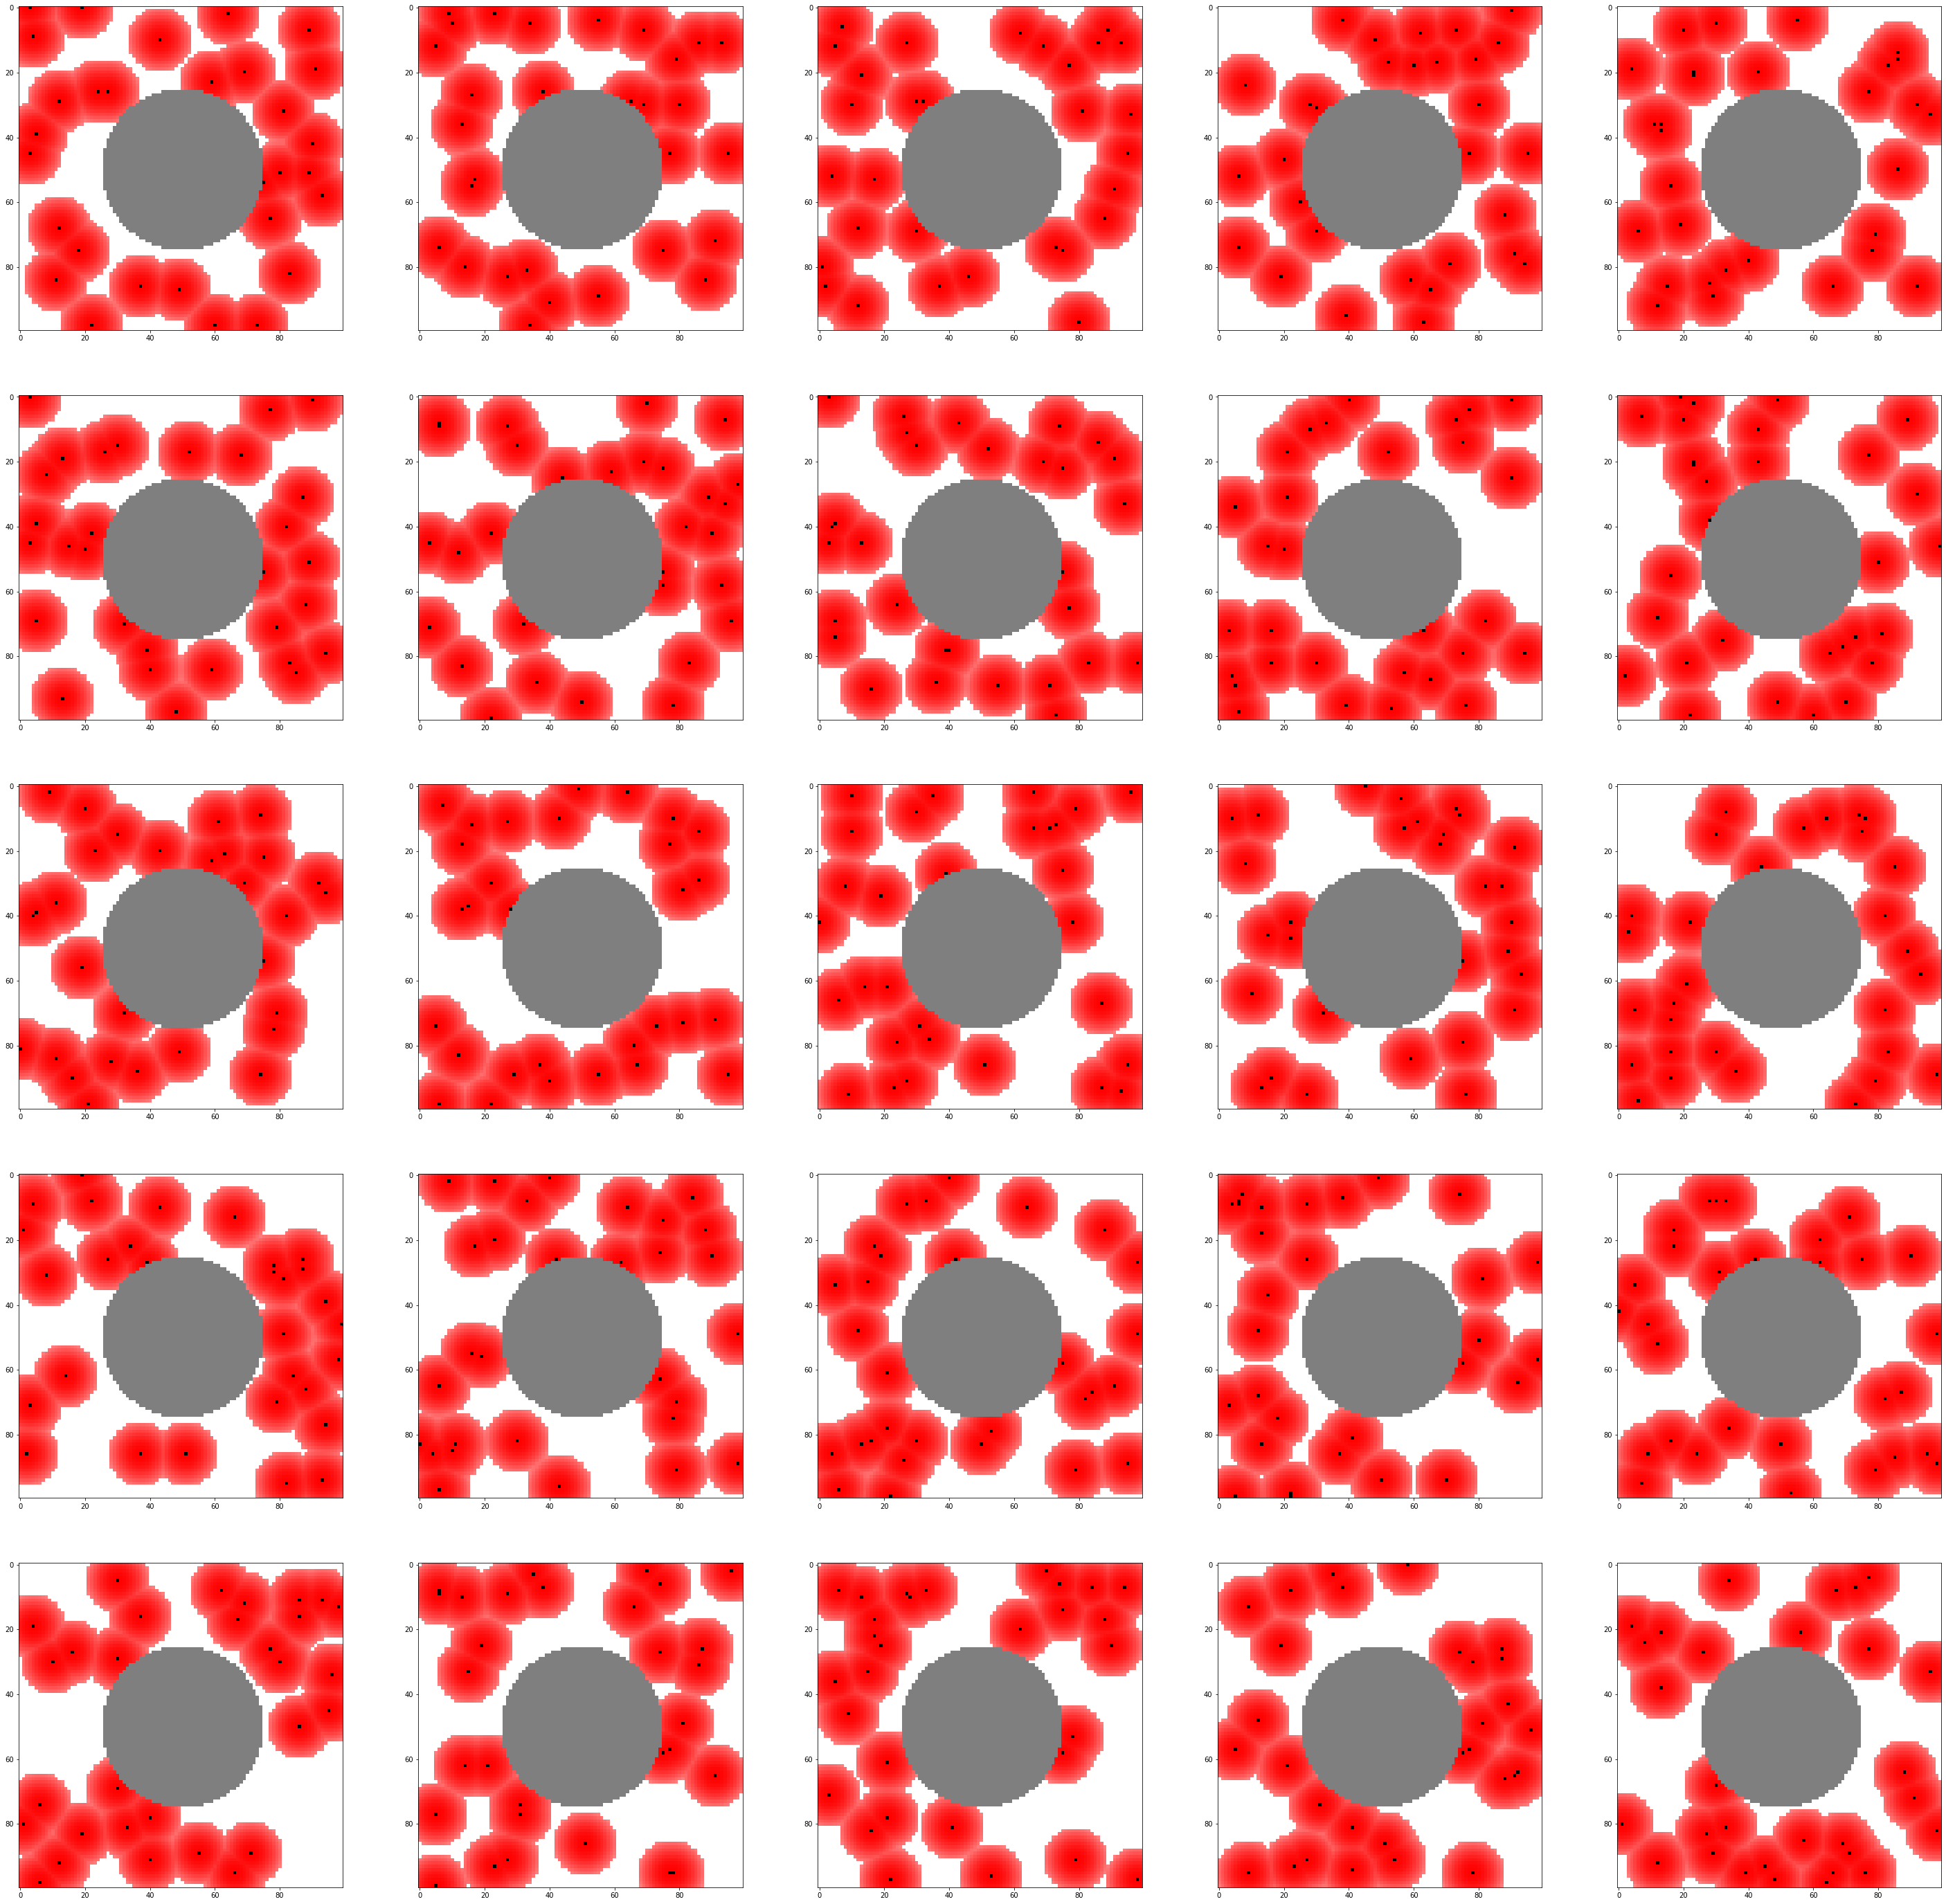

Generation 12
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2159. 1968.
 1833. 1747. 1559. 1466. 1463. 1463. 1445. 1443. 1397. 1240. 1197. 1148.
 1131.]
Previous generation score average 3077.56
[9.19714925e-02 9.06981043e-02 8.93631005e-02 8.88085605e-02
 8.86031753e-02 8.80691737e-02 8.74530181e-02 8.61180143e-02
 8.58715521e-02 8.57893980e-02 2.11341371e-02 1.72112798e-02
 1.44385796e-02 1.26722668e-02 8.81102508e-03 6.90094272e-03
 6.83932716e-03 6.83932716e-03 6.46963380e-03 6.42855676e-03
 5.48378484e-03 2.25923720e-03 1.37608084e-03 3.69693360e-04
 2.05385200e-05]


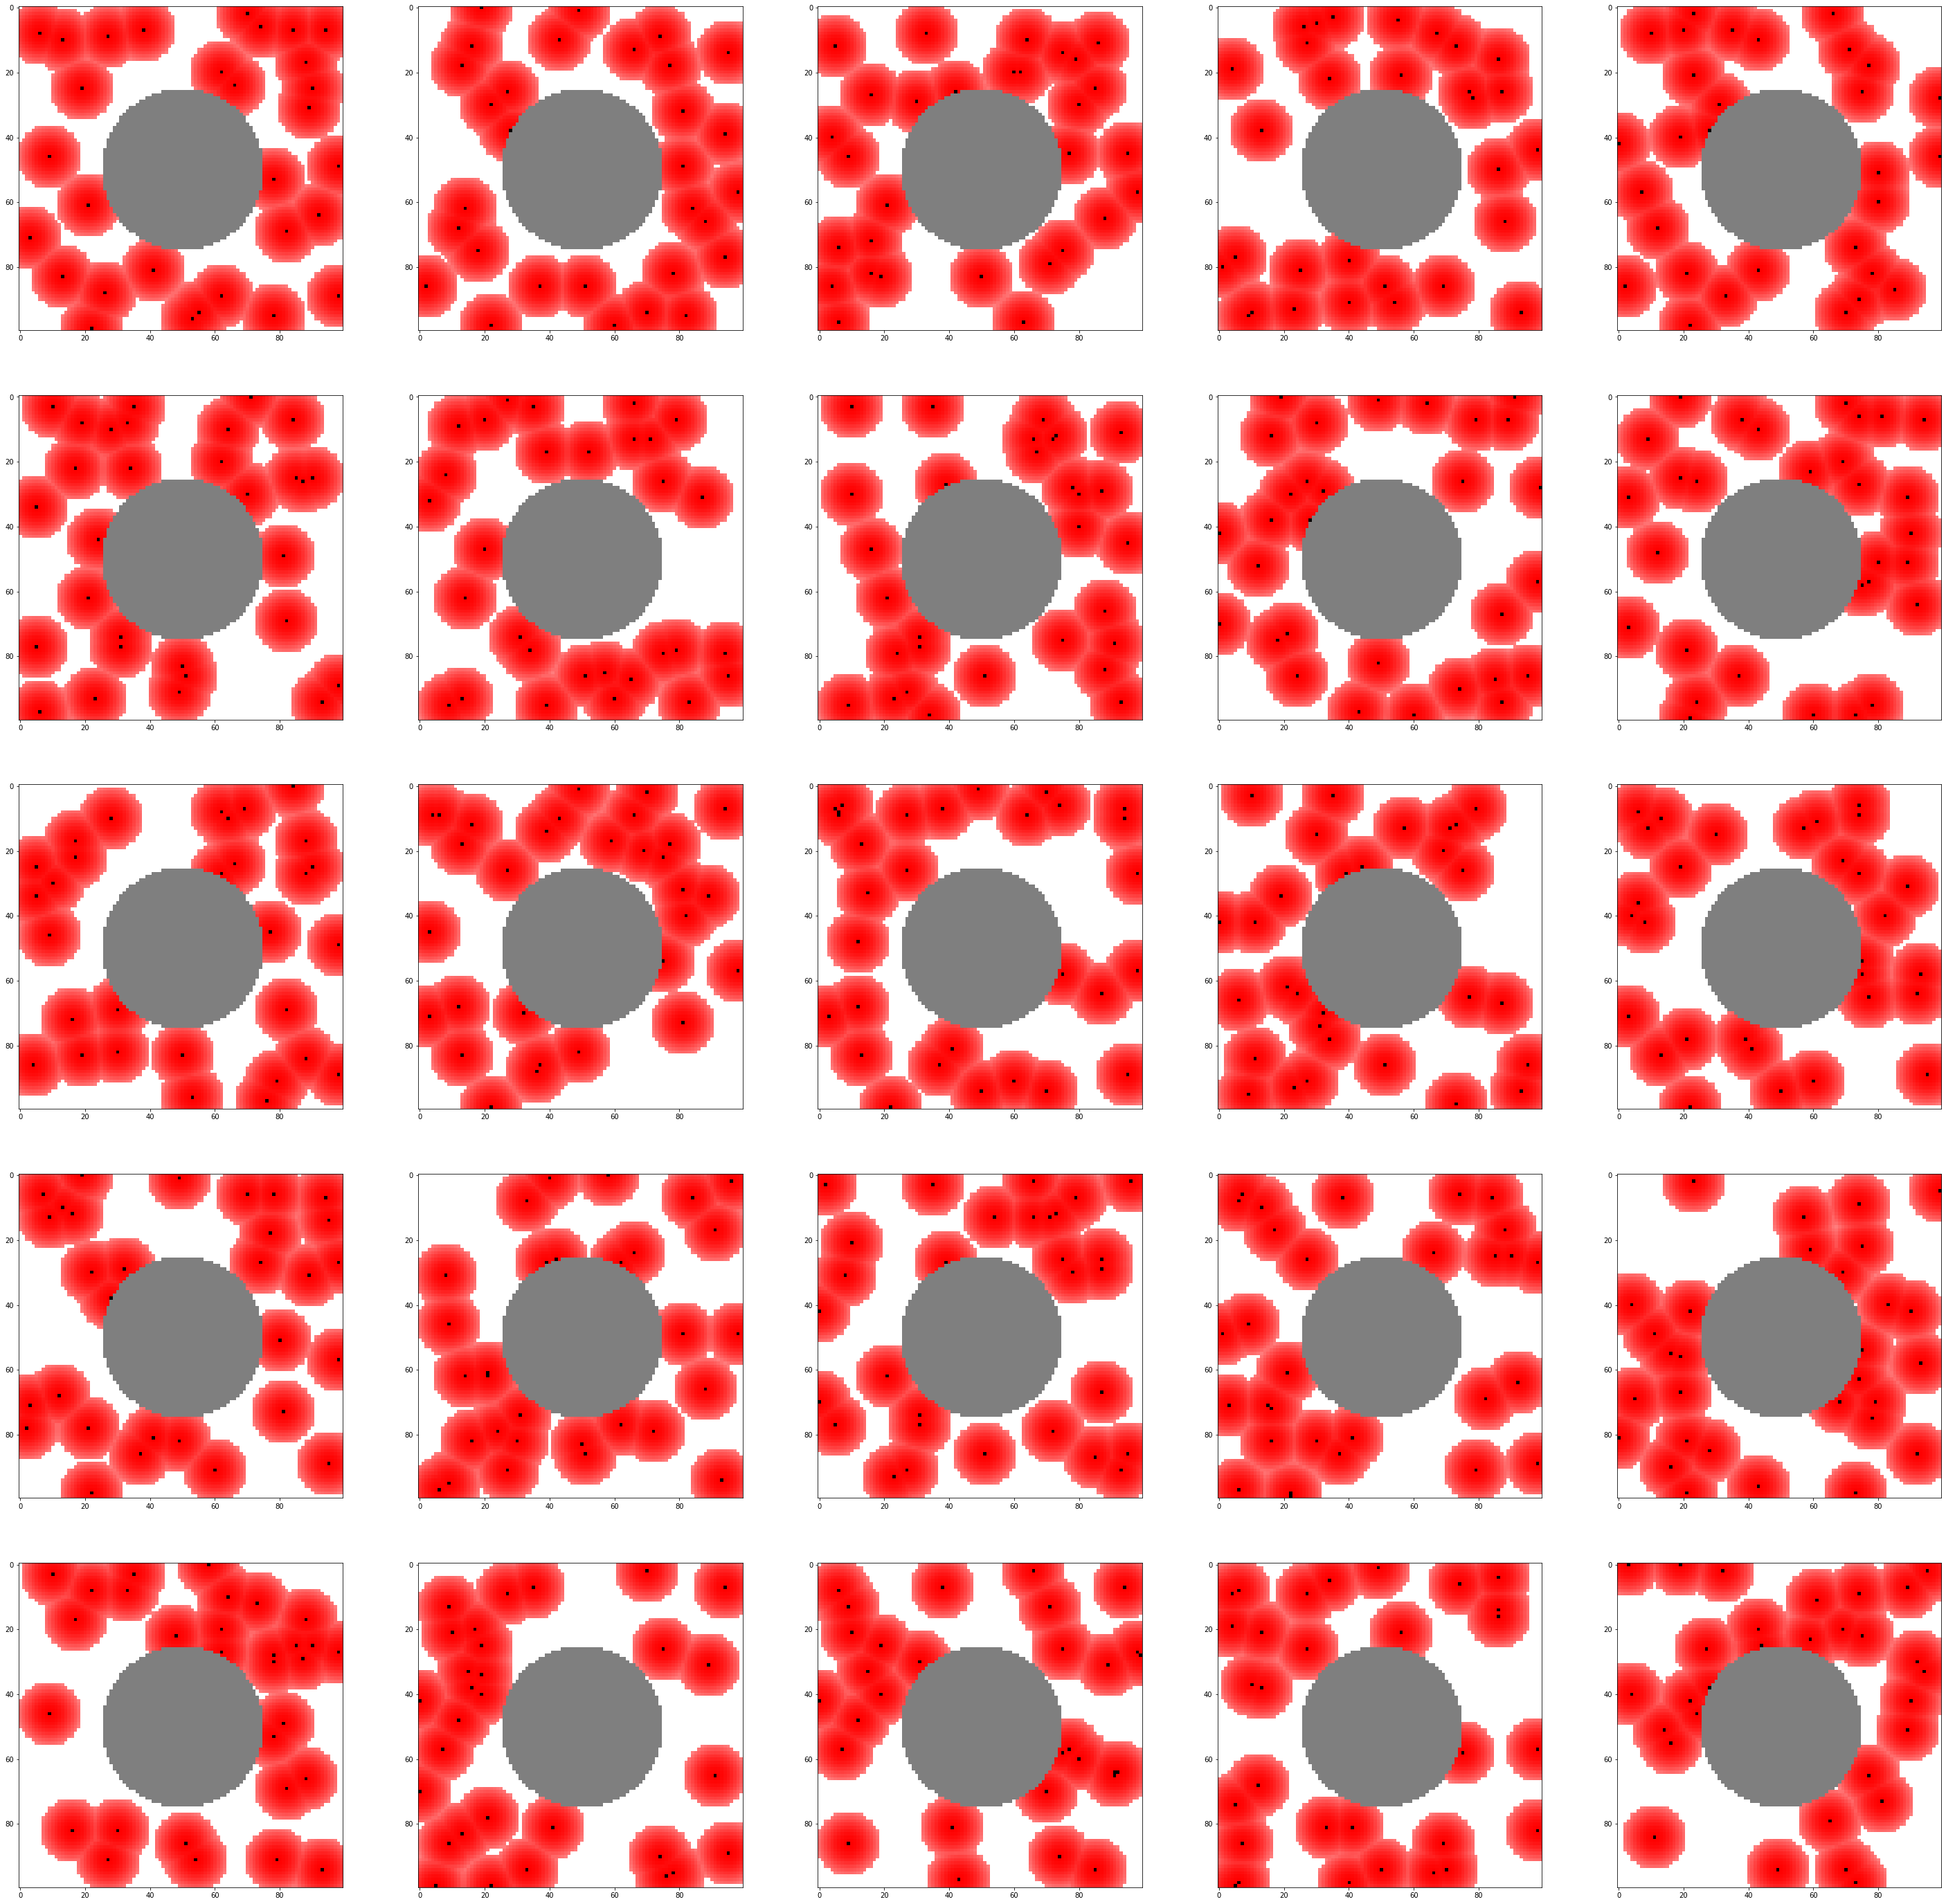

Generation 13
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2195. 2115.
 1857. 1785. 1622. 1607. 1607. 1539. 1482. 1477. 1413. 1393. 1380. 1358.
 1327.]
Previous generation score average 3137.48
[9.45525206e-02 9.31834743e-02 9.17481838e-02 9.11519862e-02
 9.09311723e-02 9.03570561e-02 8.96946143e-02 8.82593239e-02
 8.79943472e-02 8.79060216e-02 1.91887297e-02 1.74222183e-02
 1.17252192e-02 1.01353589e-02 6.53609204e-03 6.20487116e-03
 6.20487116e-03 4.70333650e-03 3.44469715e-03 3.33429019e-03
 1.92108110e-03 1.47945326e-03 1.19239517e-03 7.06604544e-04
 2.20813920e-05]


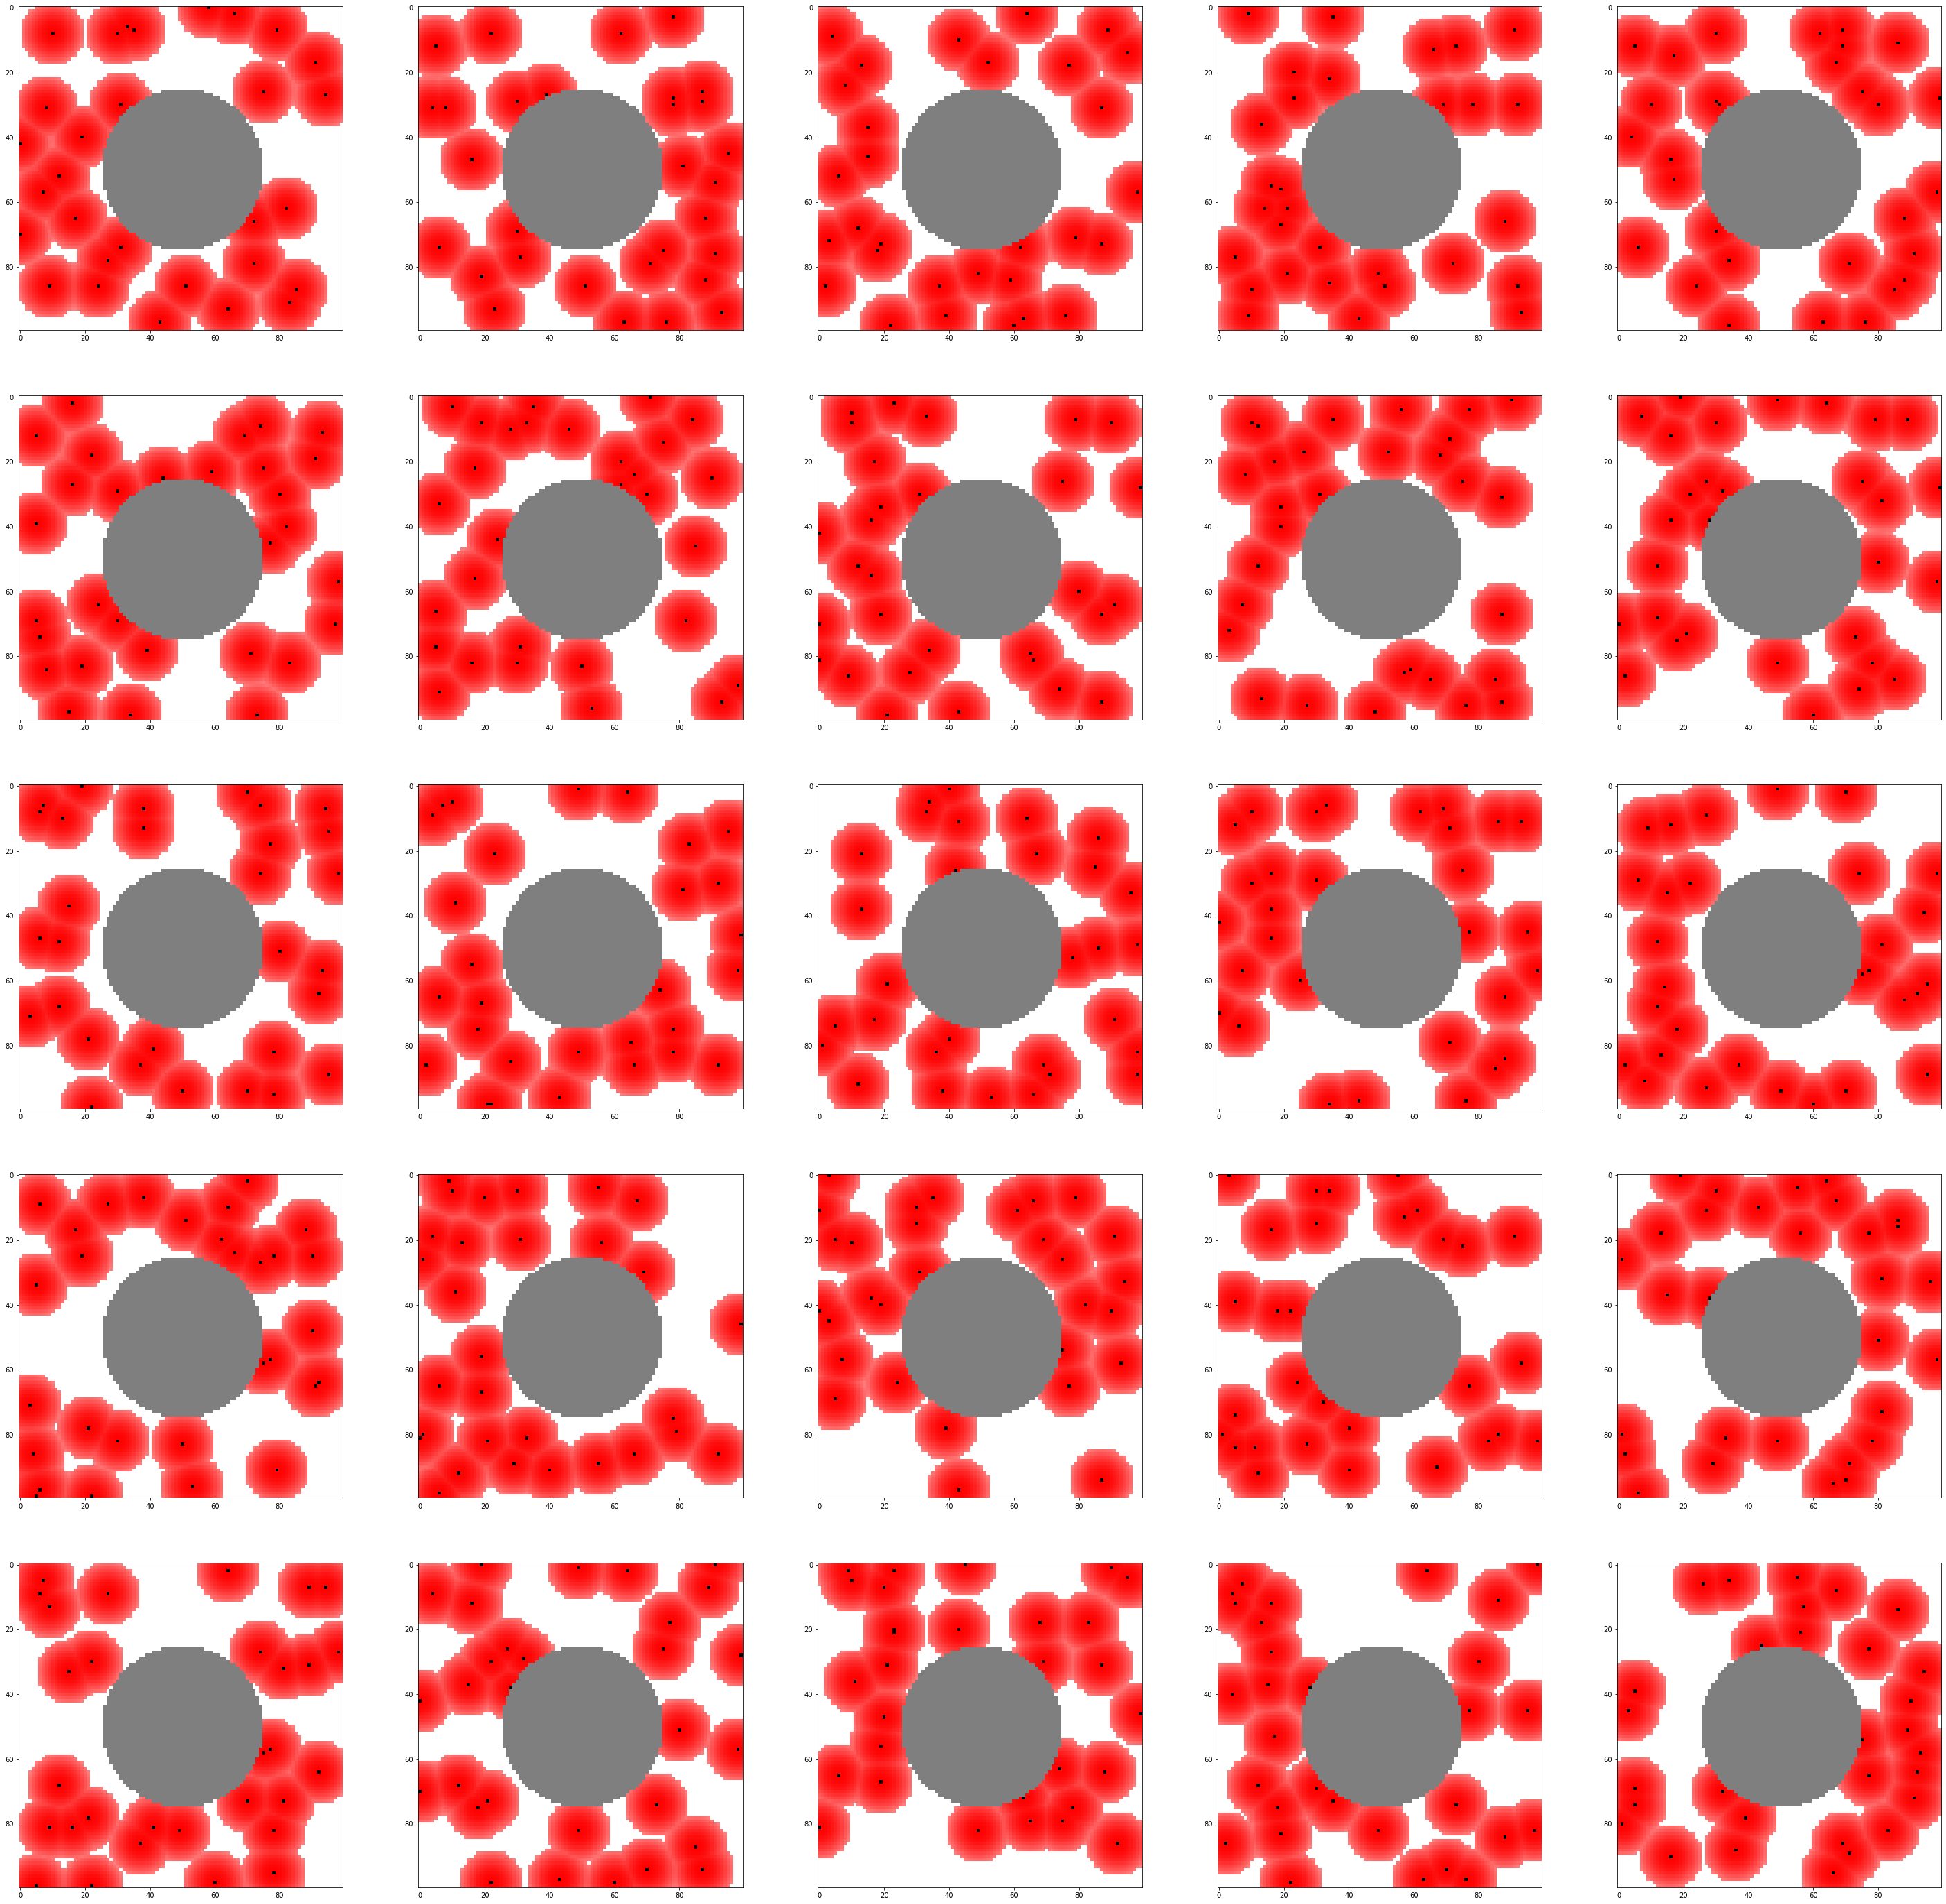

Generation 14
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2058. 1952.
 1952. 1864. 1820. 1747. 1703. 1700. 1673. 1516. 1452. 1392. 1366. 1359.
 1356.]
Previous generation score average 3167.6
[9.38541322e-02 9.24859318e-02 9.10515282e-02 9.04556990e-02
 9.02350215e-02 8.96612601e-02 8.89992276e-02 8.75648240e-02
 8.73000110e-02 8.72117400e-02 1.55136268e-02 1.31744455e-02
 1.31744455e-02 1.12324837e-02 1.02615028e-02 8.65055721e-03
 7.67957630e-03 7.61337306e-03 7.01754386e-03 3.55290743e-03
 2.14057155e-03 8.16506675e-04 2.42745228e-04 8.82709919e-05
 2.20677480e-05]


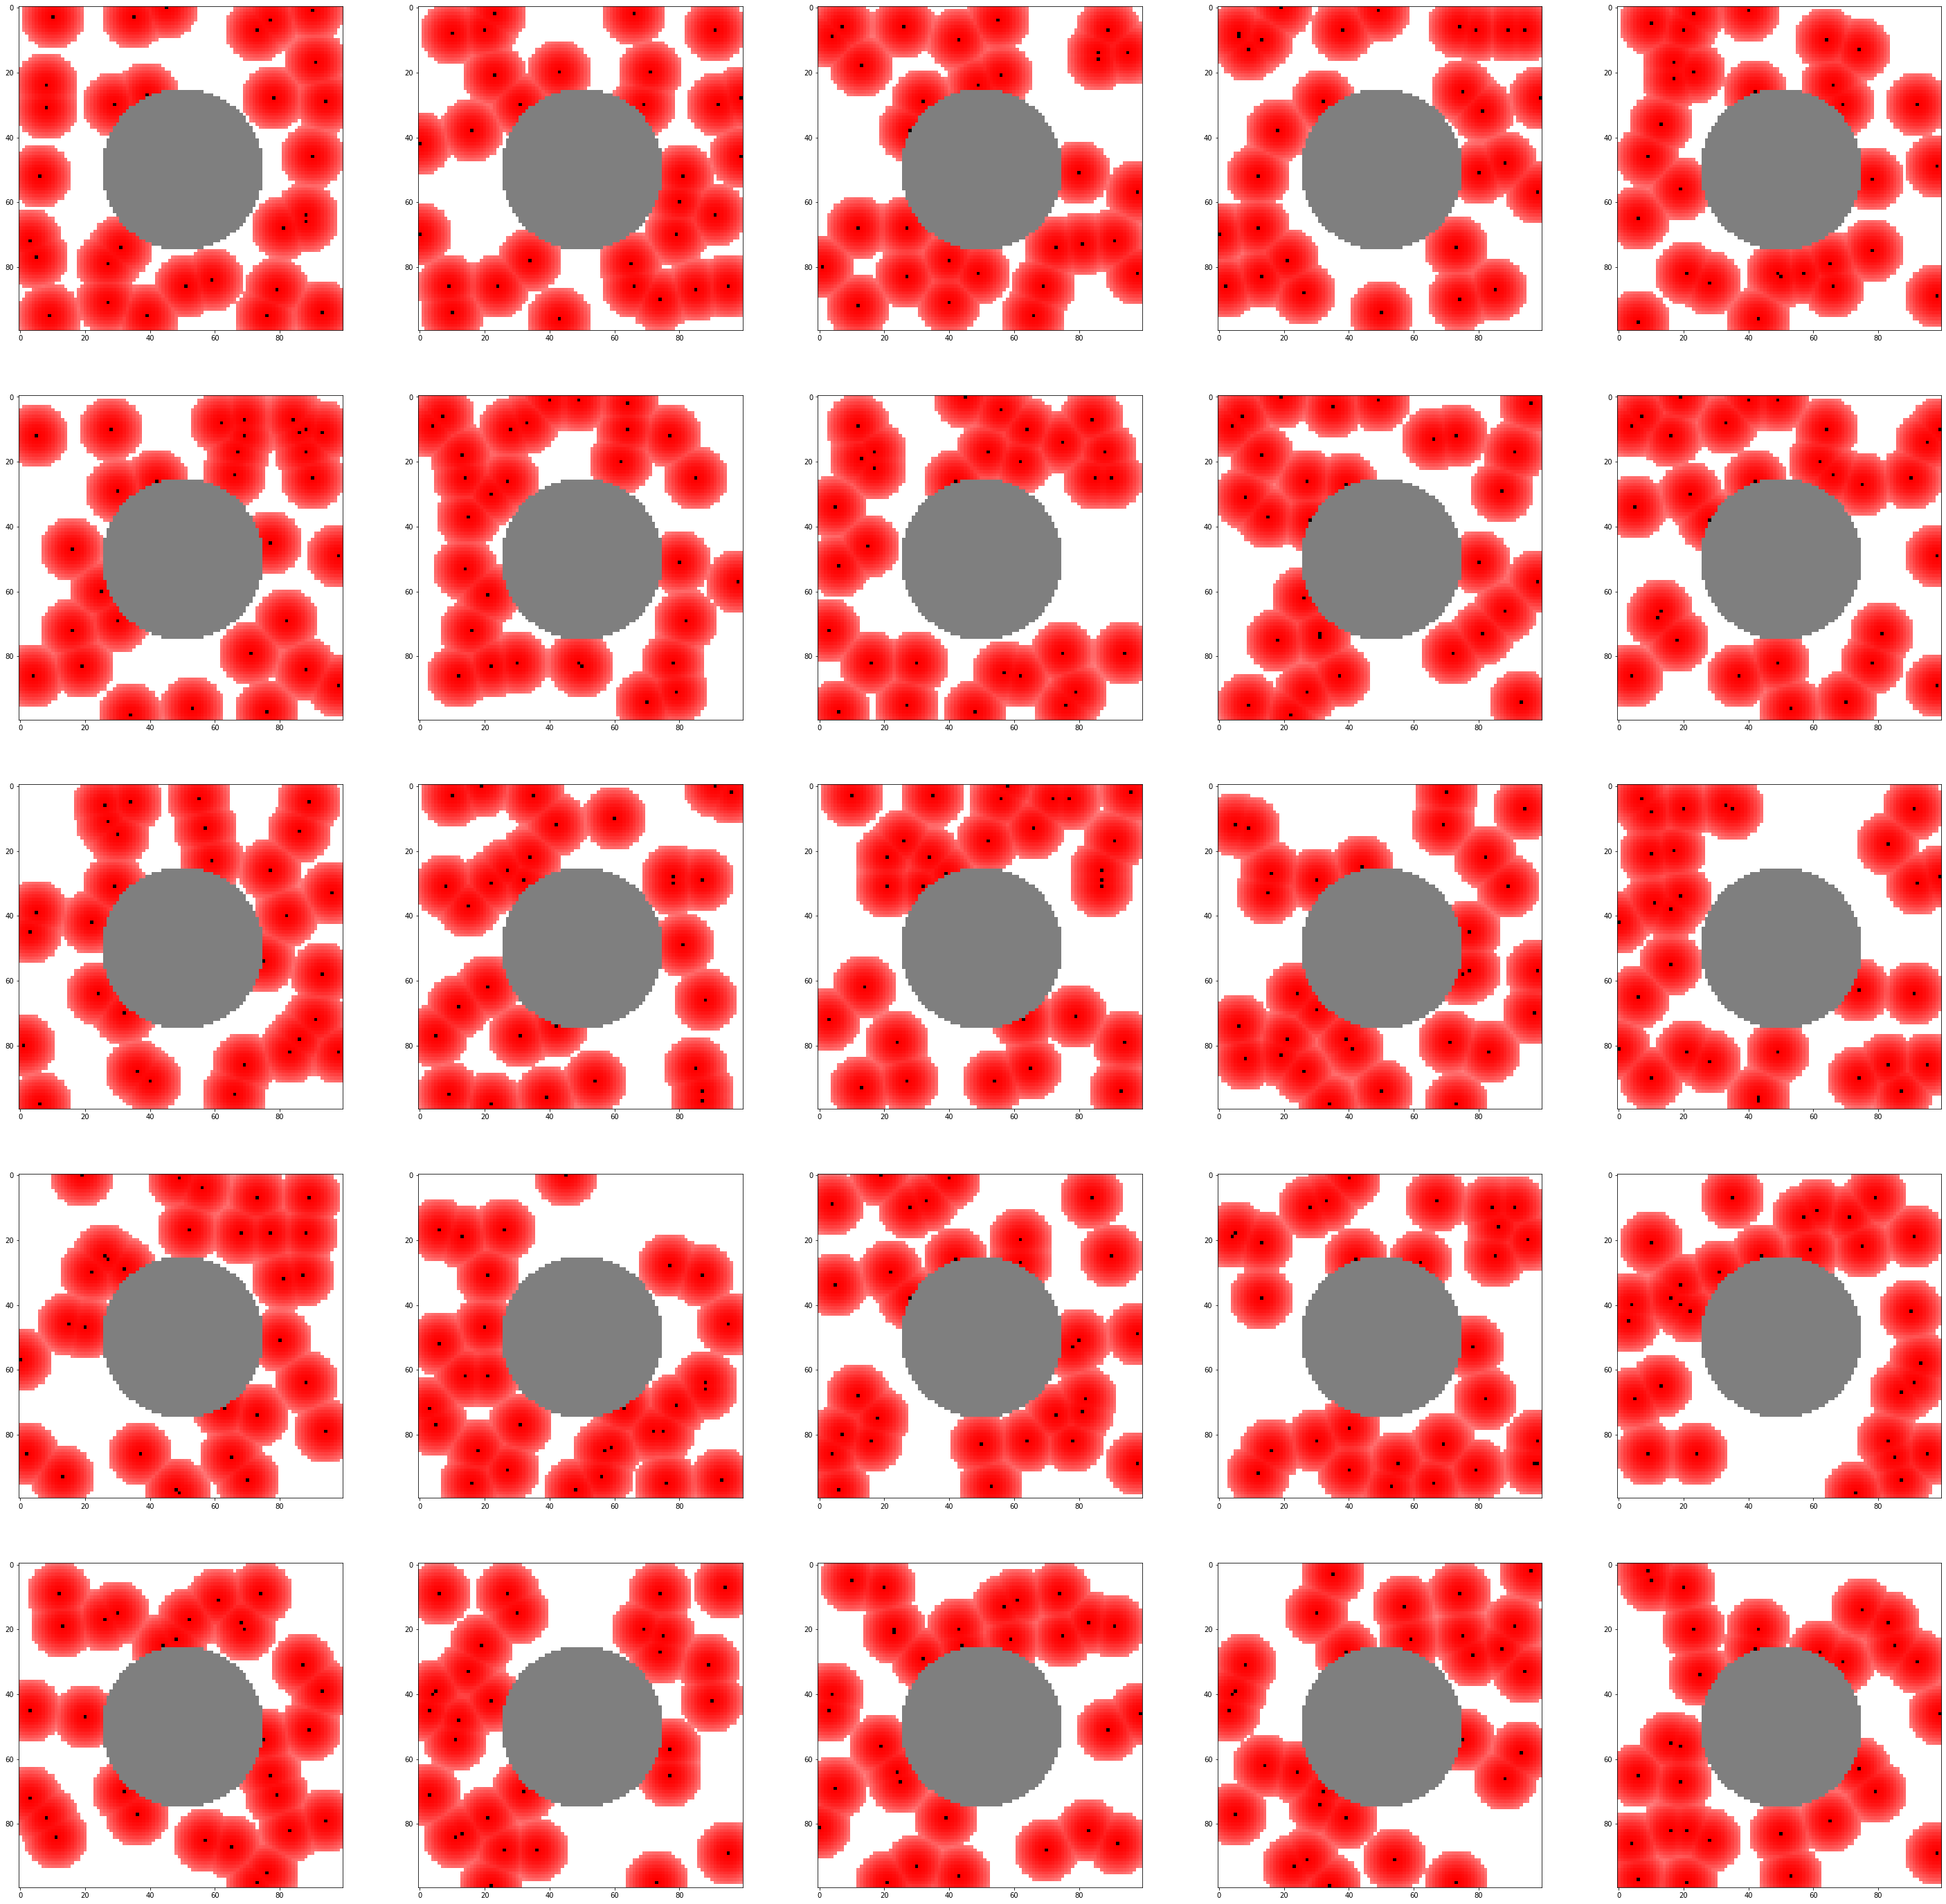

Generation 15
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2563. 2240.
 2073. 1930. 1793. 1746. 1713. 1711. 1684. 1632. 1592. 1514. 1432. 1334.
 1303.]
Previous generation score average 3221.6
[8.97270265e-02 8.84350906e-02 8.70806418e-02 8.65180246e-02
 8.63096478e-02 8.57678683e-02 8.51427381e-02 8.37882892e-02
 8.35382371e-02 8.34548864e-02 2.62763076e-02 1.95457387e-02
 1.60658471e-02 1.30860596e-02 1.02312982e-02 9.25192748e-03
 8.56428423e-03 8.52260888e-03 7.95999166e-03 6.87643259e-03
 6.04292561e-03 4.41758700e-03 2.70889769e-03 6.66805584e-04
 2.08376745e-05]


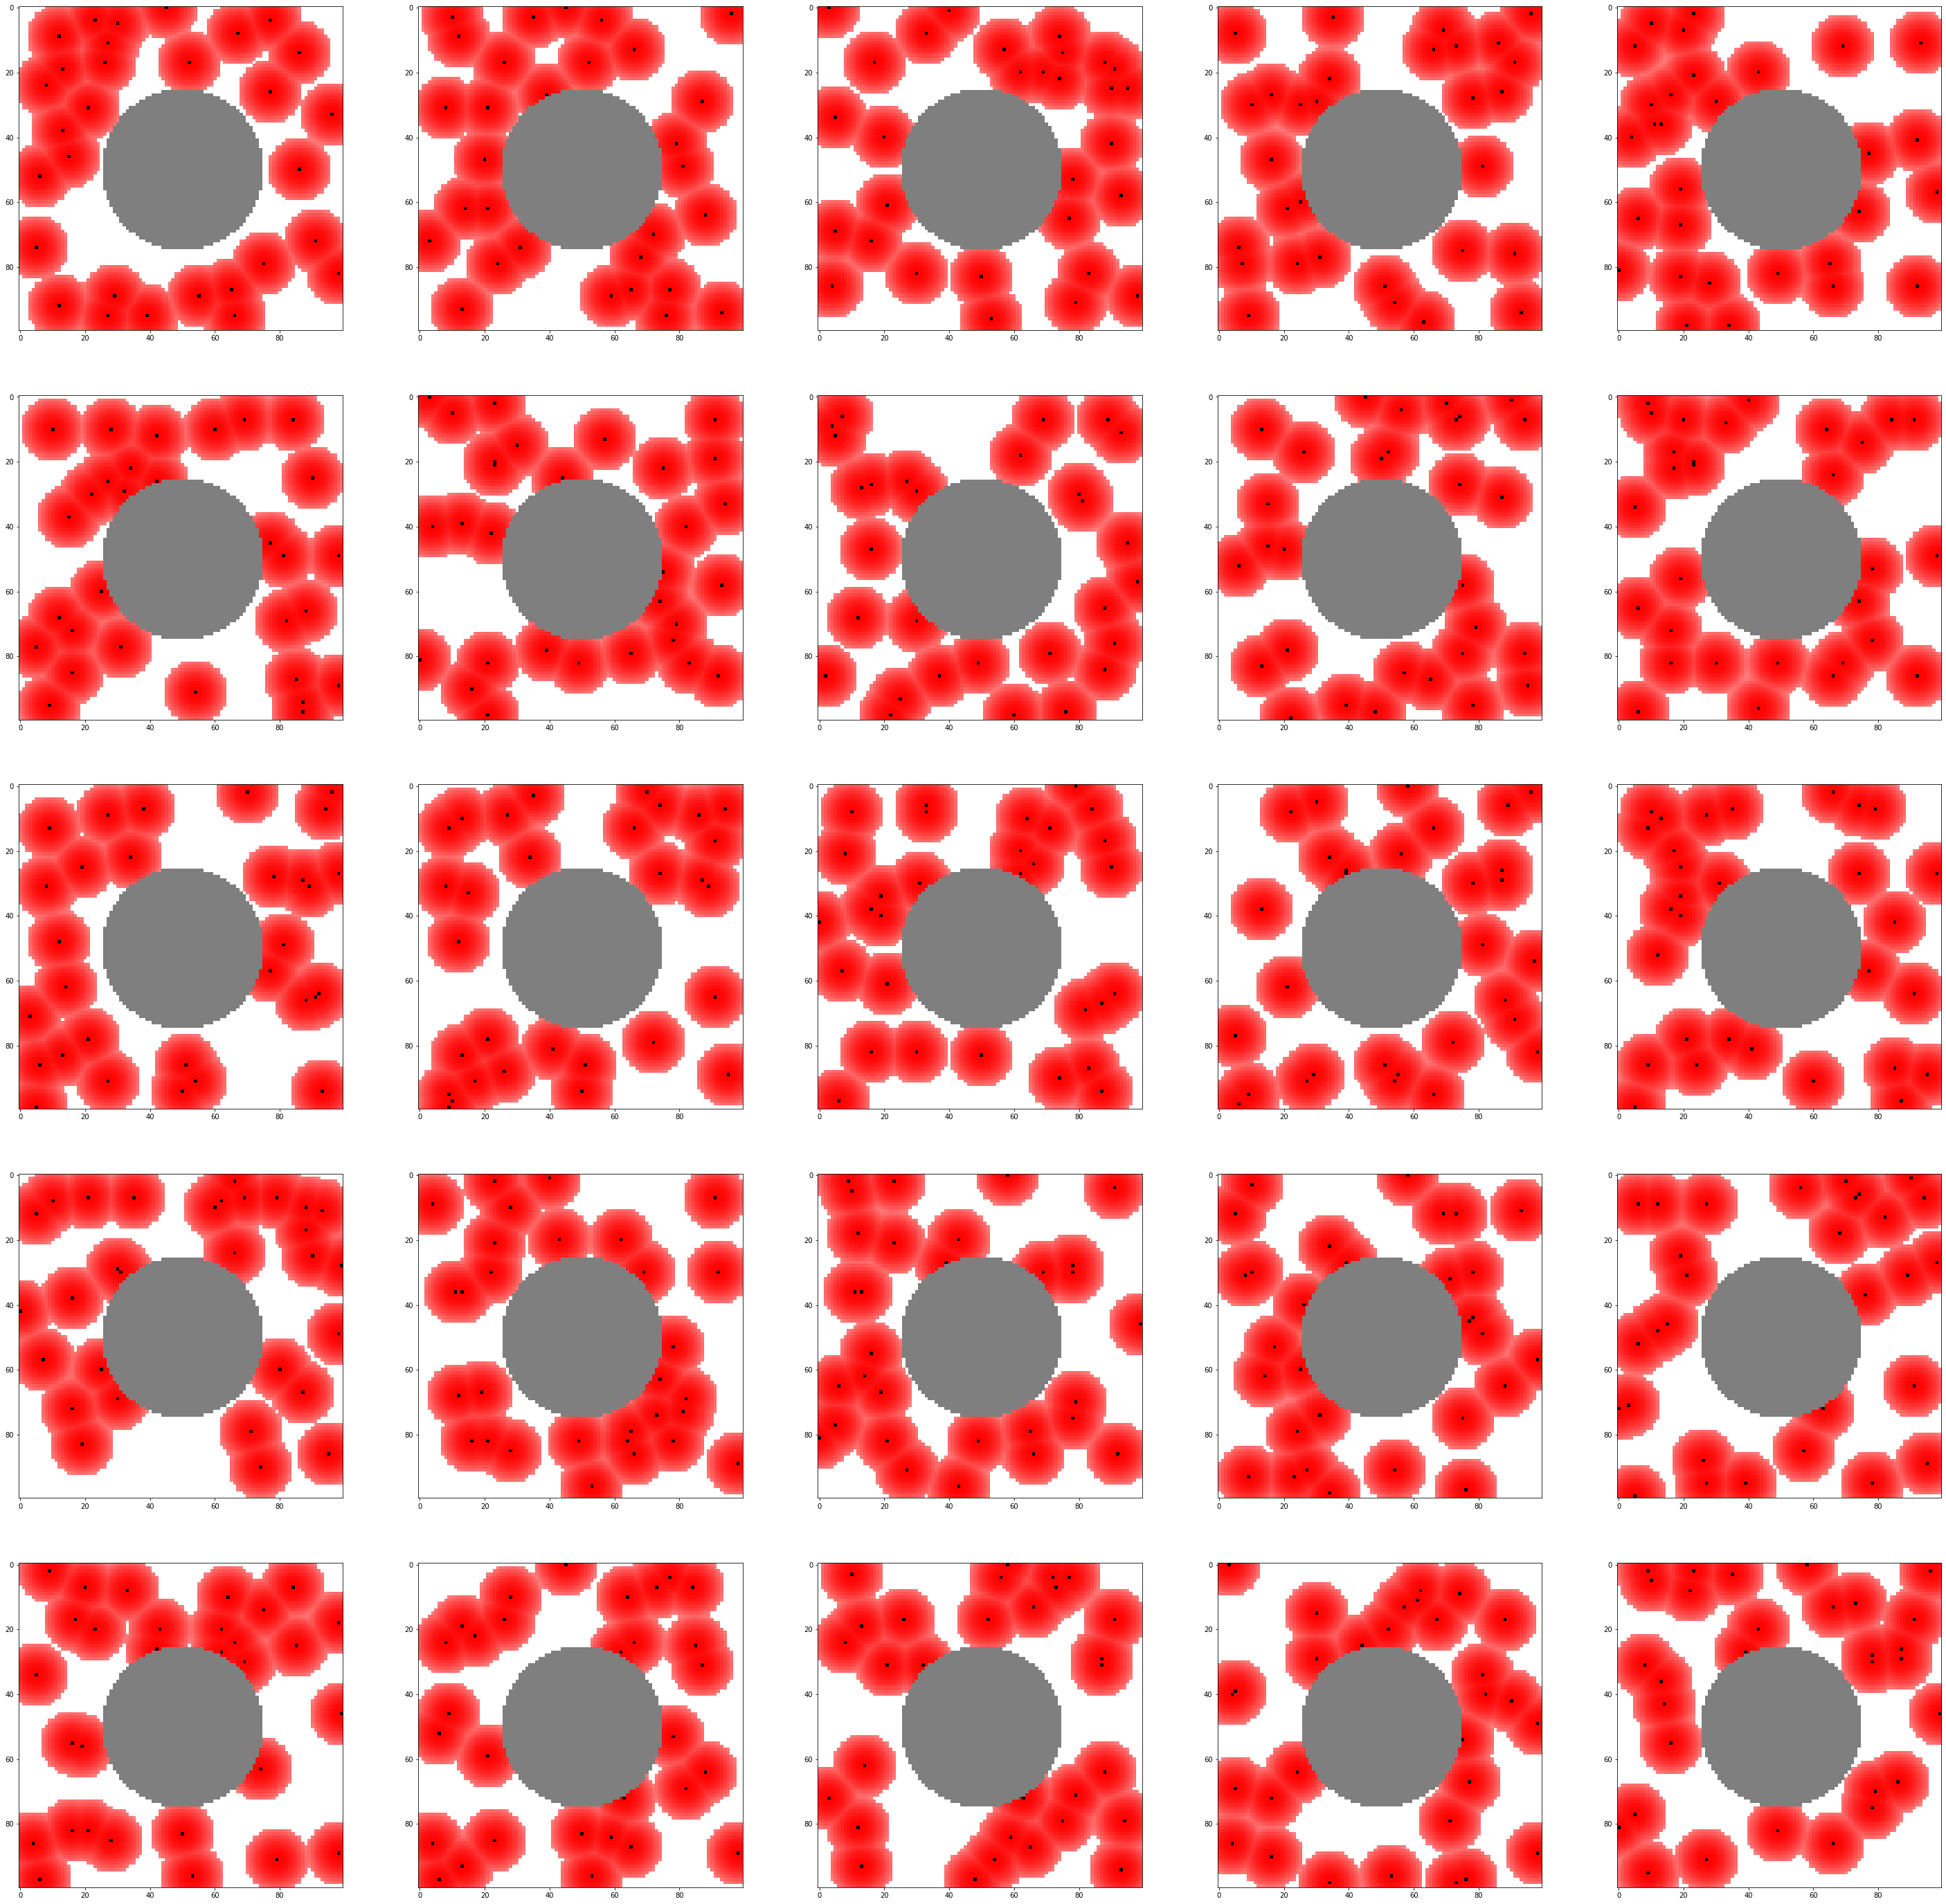

Generation 16
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2458. 2199.
 1980. 1921. 1783. 1619. 1528. 1524. 1511. 1475. 1475. 1436. 1420. 1409.
 1378.]
Previous generation score average 3175.84
[9.40828534e-02 9.27041871e-02 9.12588112e-02 9.06584243e-02
 9.04360588e-02 8.98579084e-02 8.91908119e-02 8.77454359e-02
 8.74785973e-02 8.73896511e-02 2.40377132e-02 1.82784461e-02
 1.34086411e-02 1.20966845e-02 9.02804029e-03 5.38124569e-03
 3.35771942e-03 3.26877321e-03 2.97969803e-03 2.17918214e-03
 2.17918214e-03 1.31195659e-03 9.56171755e-04 7.11569678e-04
 2.22365524e-05]


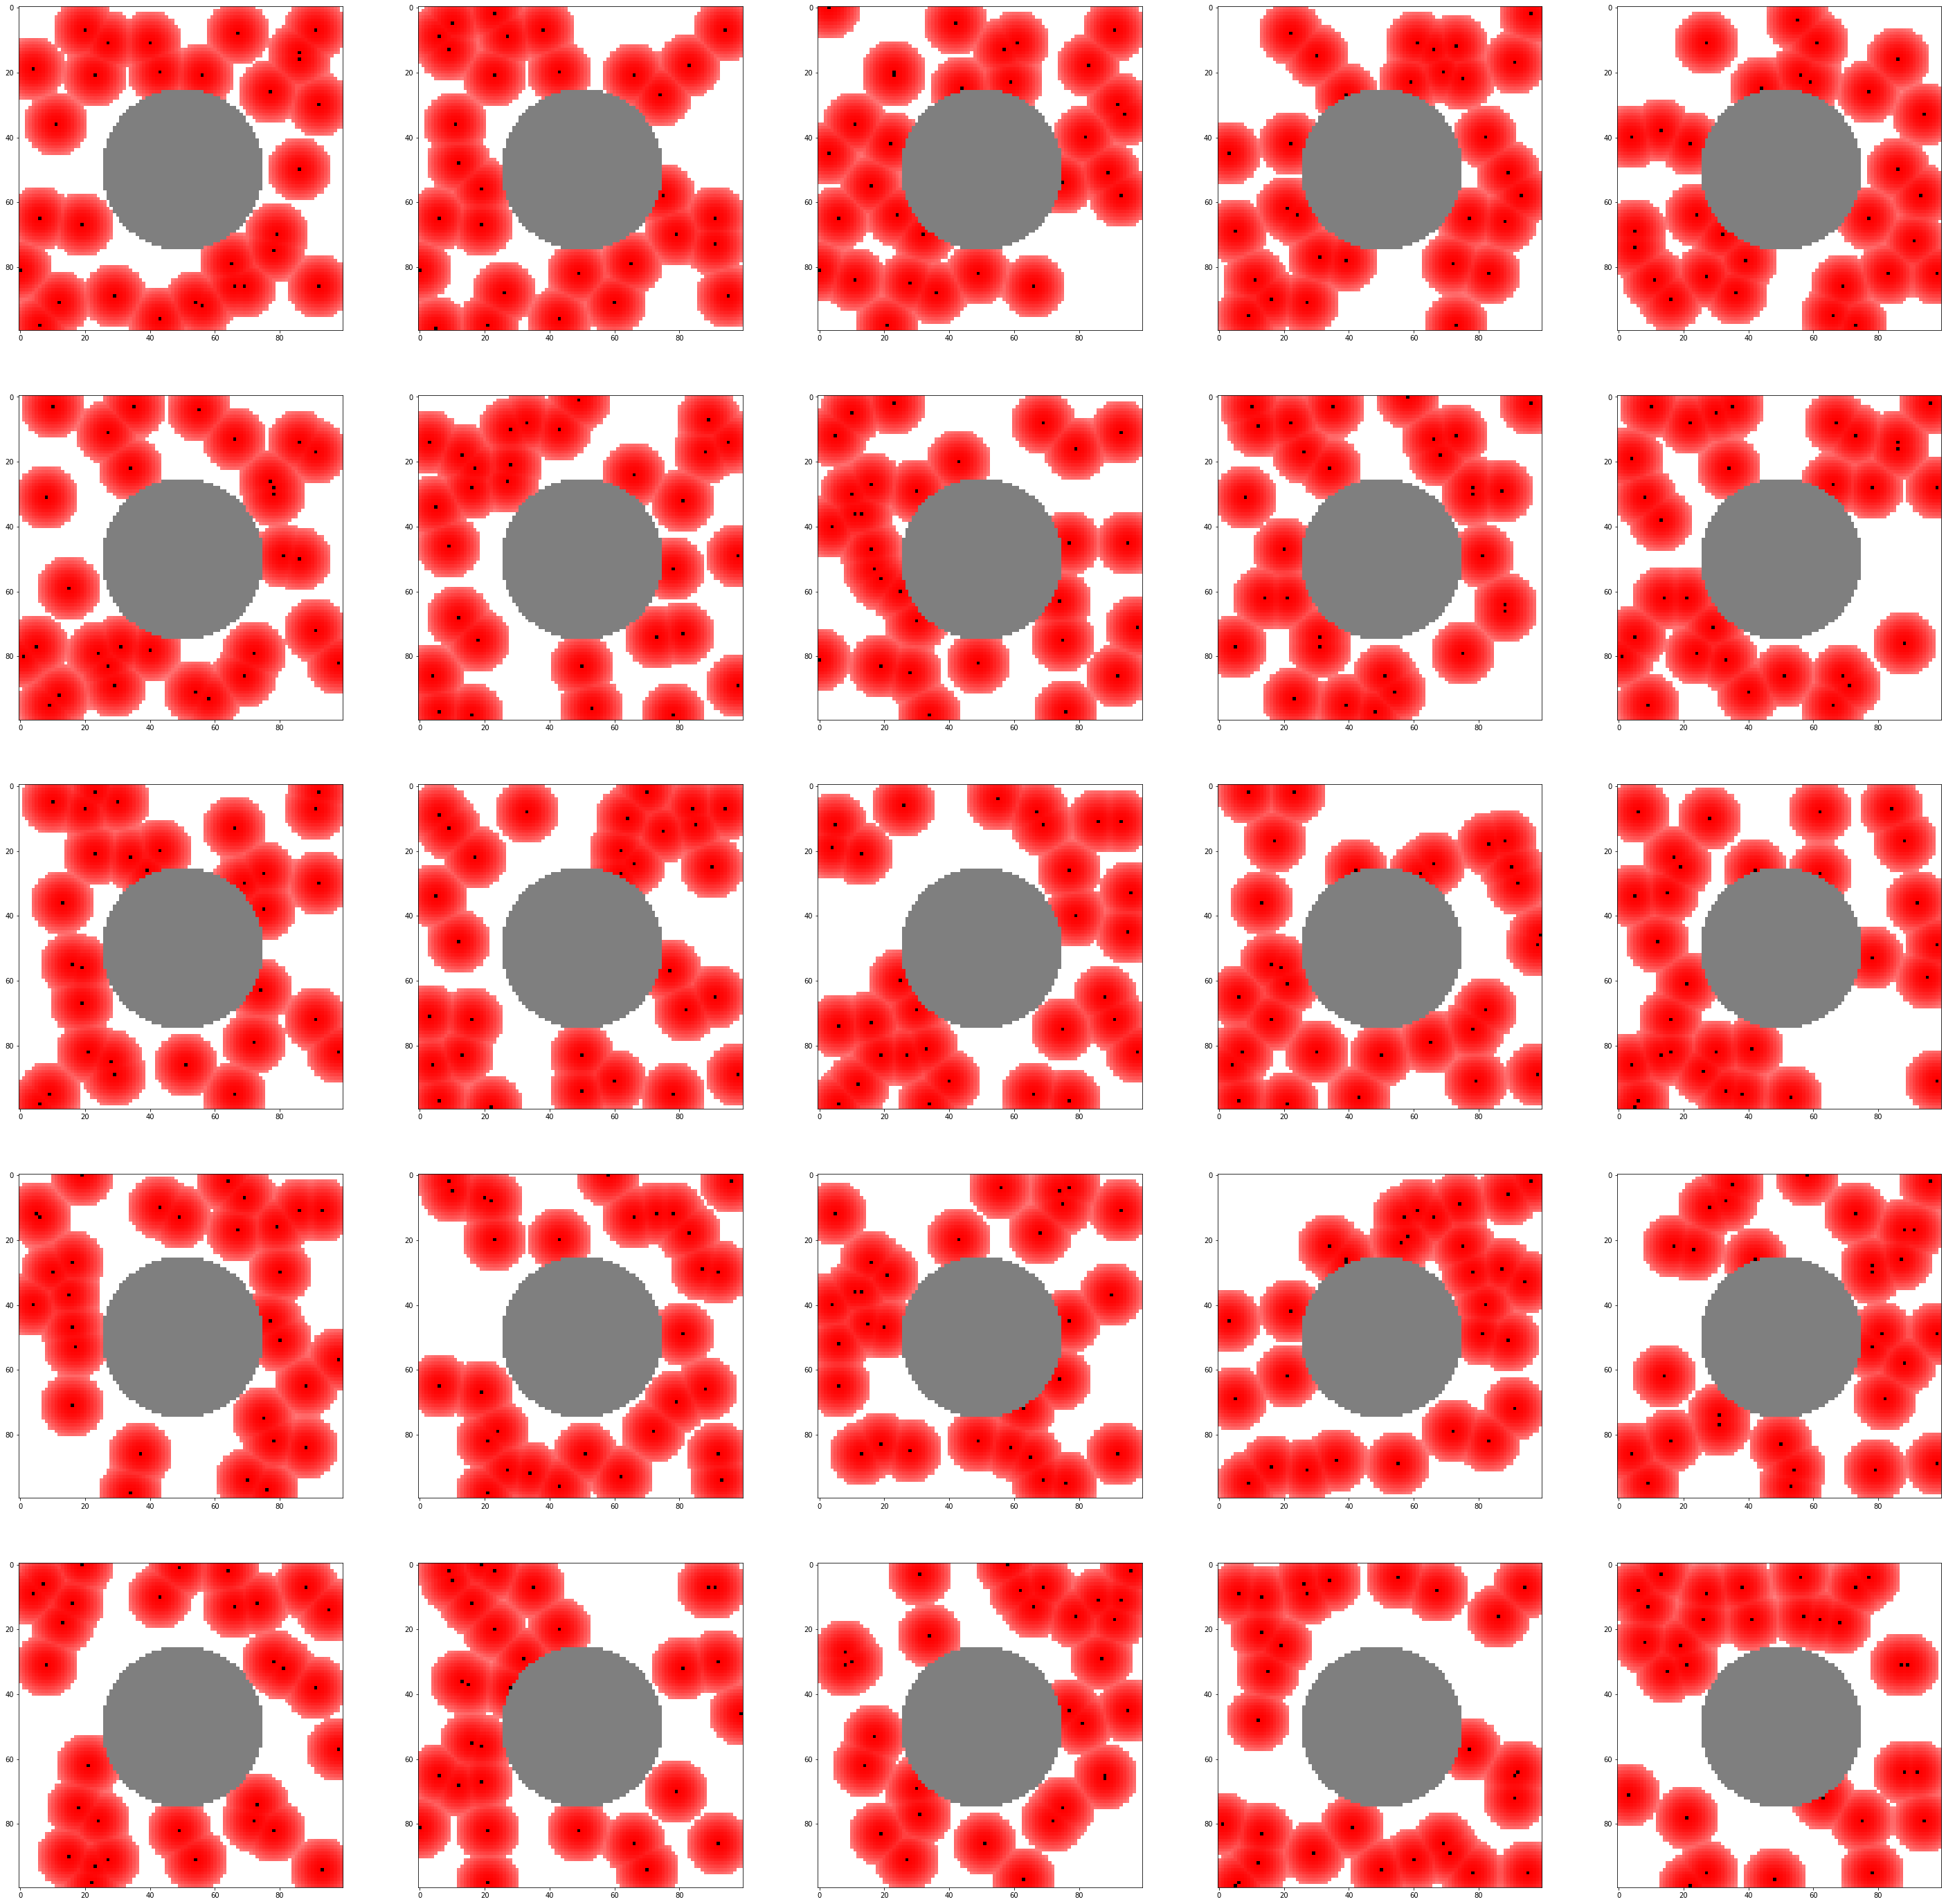

Generation 17
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2405. 2130.
 2031. 1874. 1821. 1608. 1542. 1493. 1484. 1475. 1449. 1311. 1130. 1056.
 1049.]
Previous generation score average 3125.52
[8.77969887e-02 8.66032577e-02 8.53517656e-02 8.48319150e-02
 8.46393777e-02 8.41387809e-02 8.35611691e-02 8.23096769e-02
 8.20786322e-02 8.20016173e-02 2.61273056e-02 2.08325311e-02
 1.89264123e-02 1.59035773e-02 1.48831299e-02 1.07820863e-02
 9.51134044e-03 8.56790789e-03 8.39462436e-03 8.22134083e-03
 7.72074396e-03 5.06372983e-03 1.57880550e-03 1.54029805e-04
 1.92537256e-05]


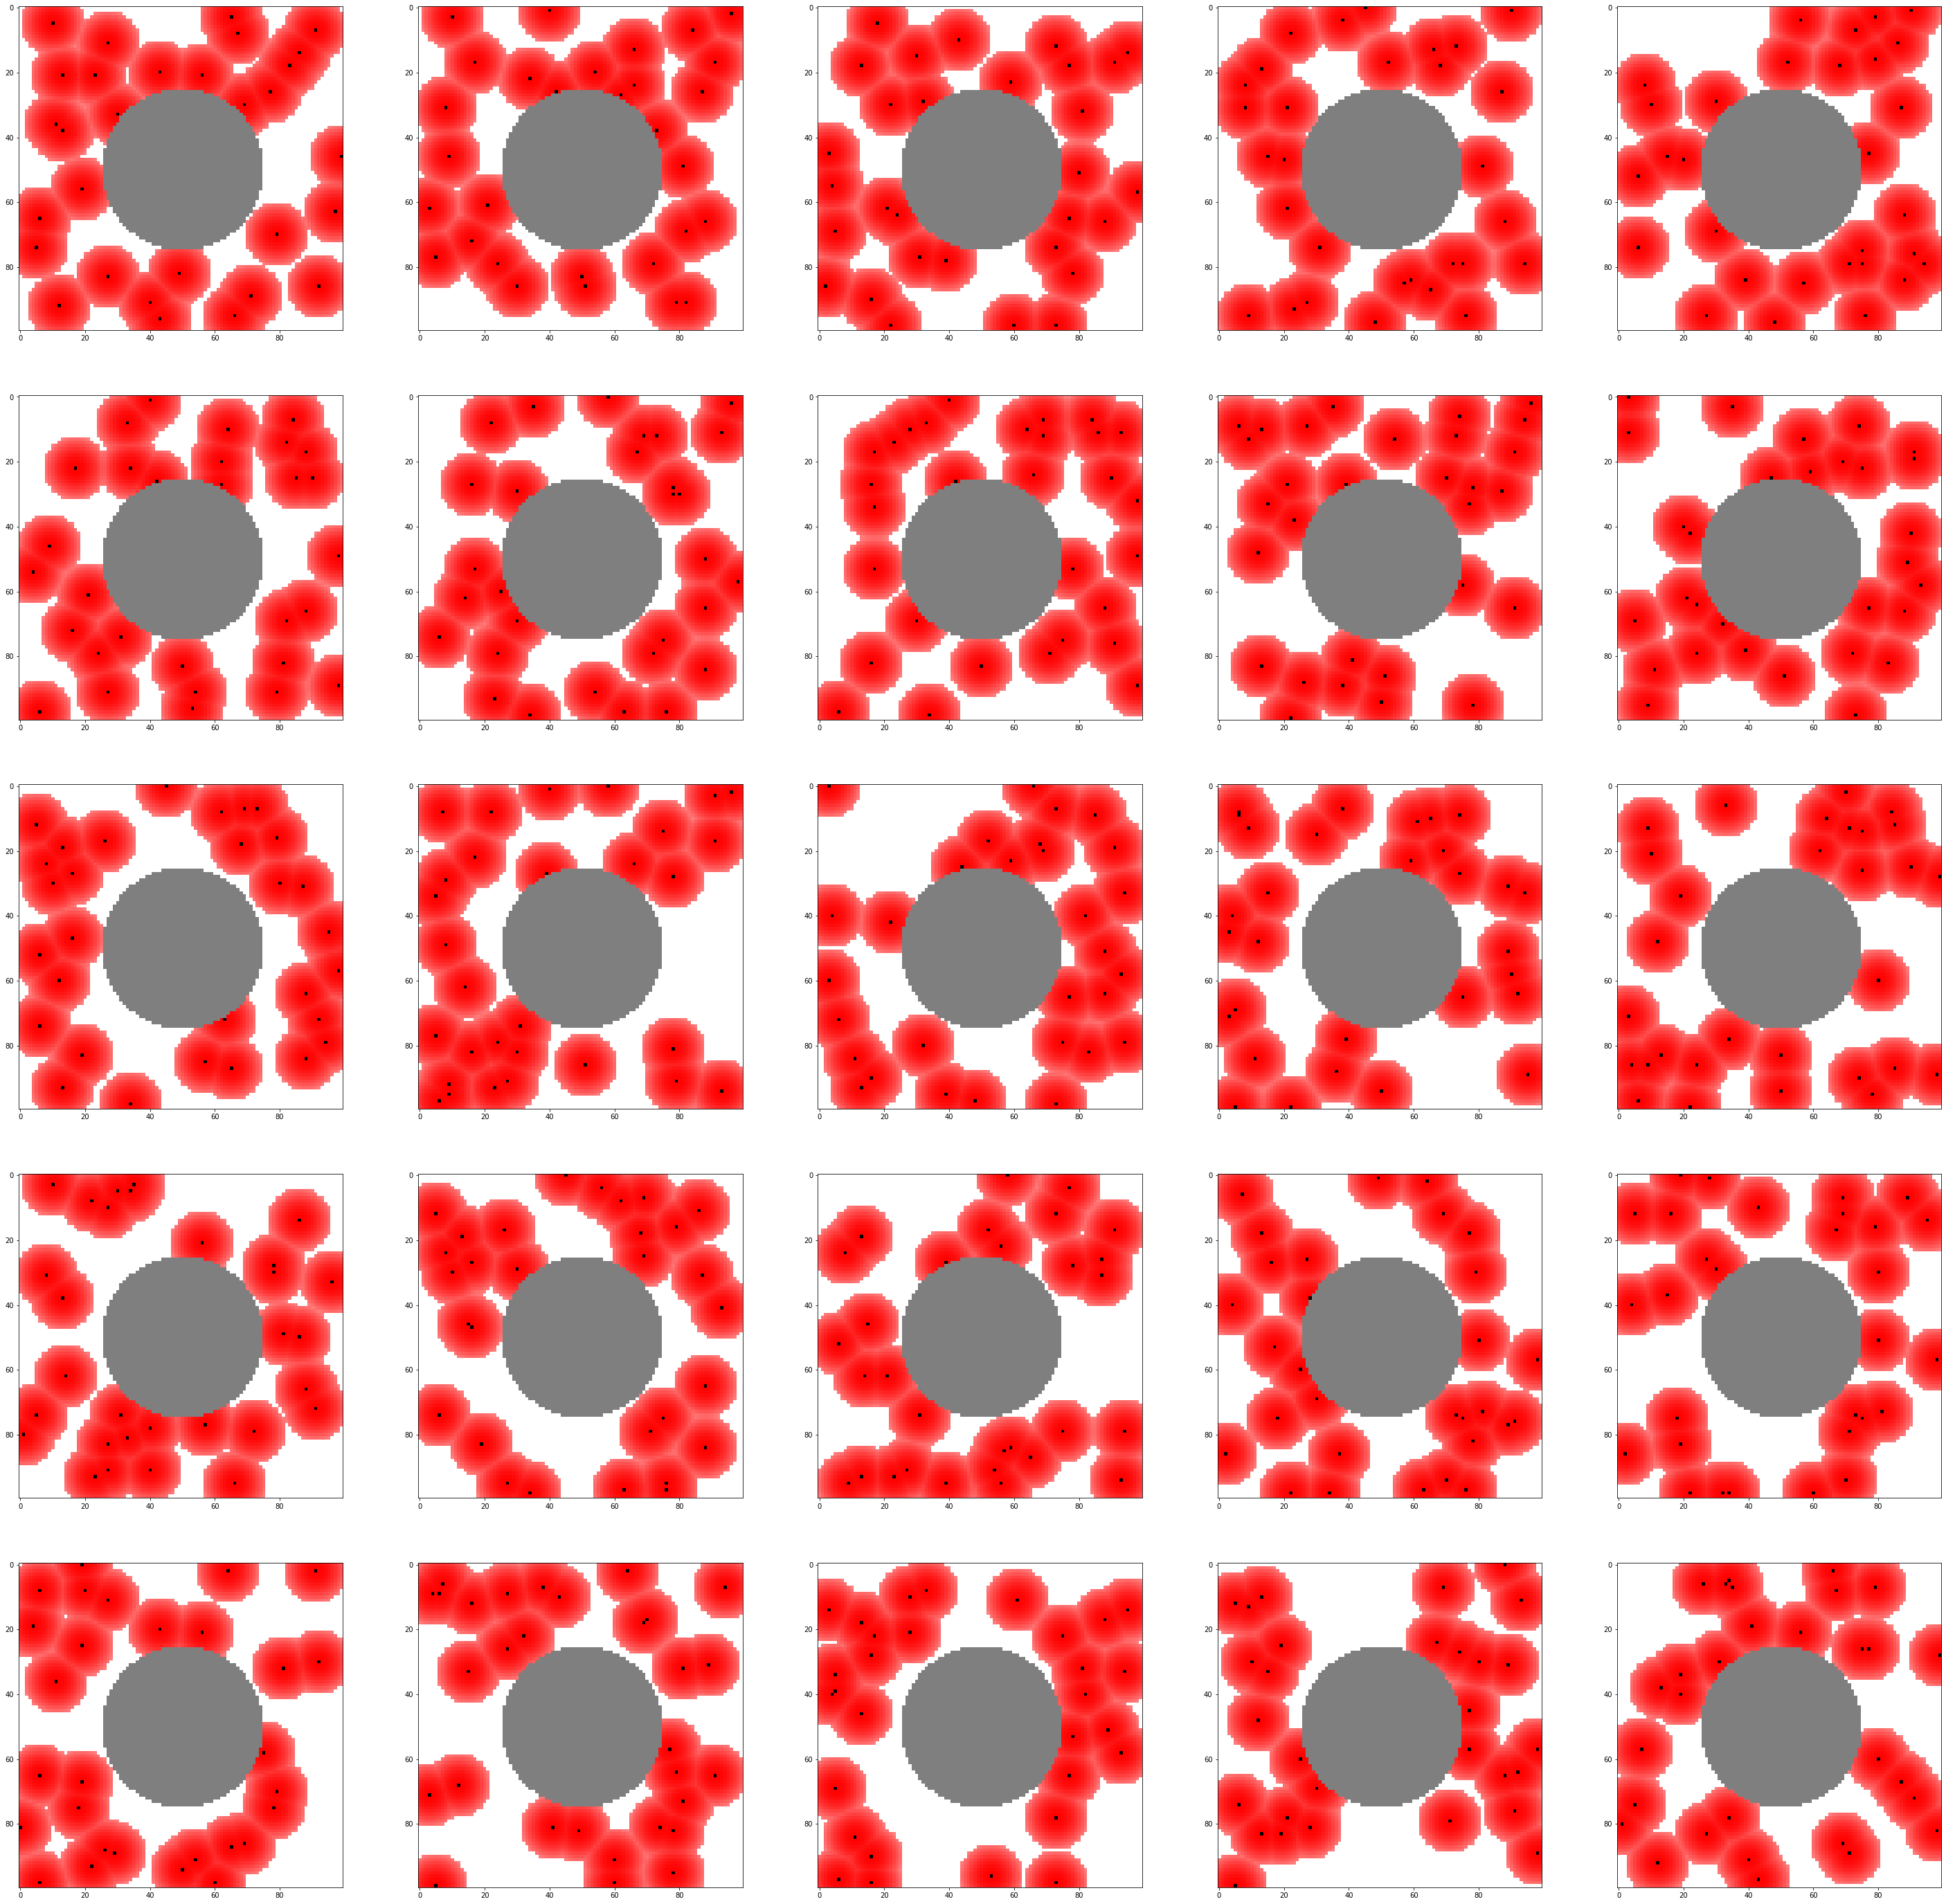

Generation 18
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 1969. 1749.
 1693. 1651. 1631. 1627. 1555. 1546. 1468. 1195. 1188. 1123. 1118. 1112.
 1082.]
Previous generation score average 3039.48
[9.24594584e-02 9.11931702e-02 8.98656101e-02 8.93141620e-02
 8.91099220e-02 8.85788979e-02 8.79661779e-02 8.66386177e-02
 8.63935297e-02 8.63118337e-02 1.81365140e-02 1.36432335e-02
 1.24994894e-02 1.16416813e-02 1.12332013e-02 1.11515052e-02
 9.68097708e-03 9.49716106e-03 7.90408889e-03 2.32833626e-03
 2.18536824e-03 8.57808096e-04 7.55688085e-04 6.33144071e-04
 2.04240023e-05]


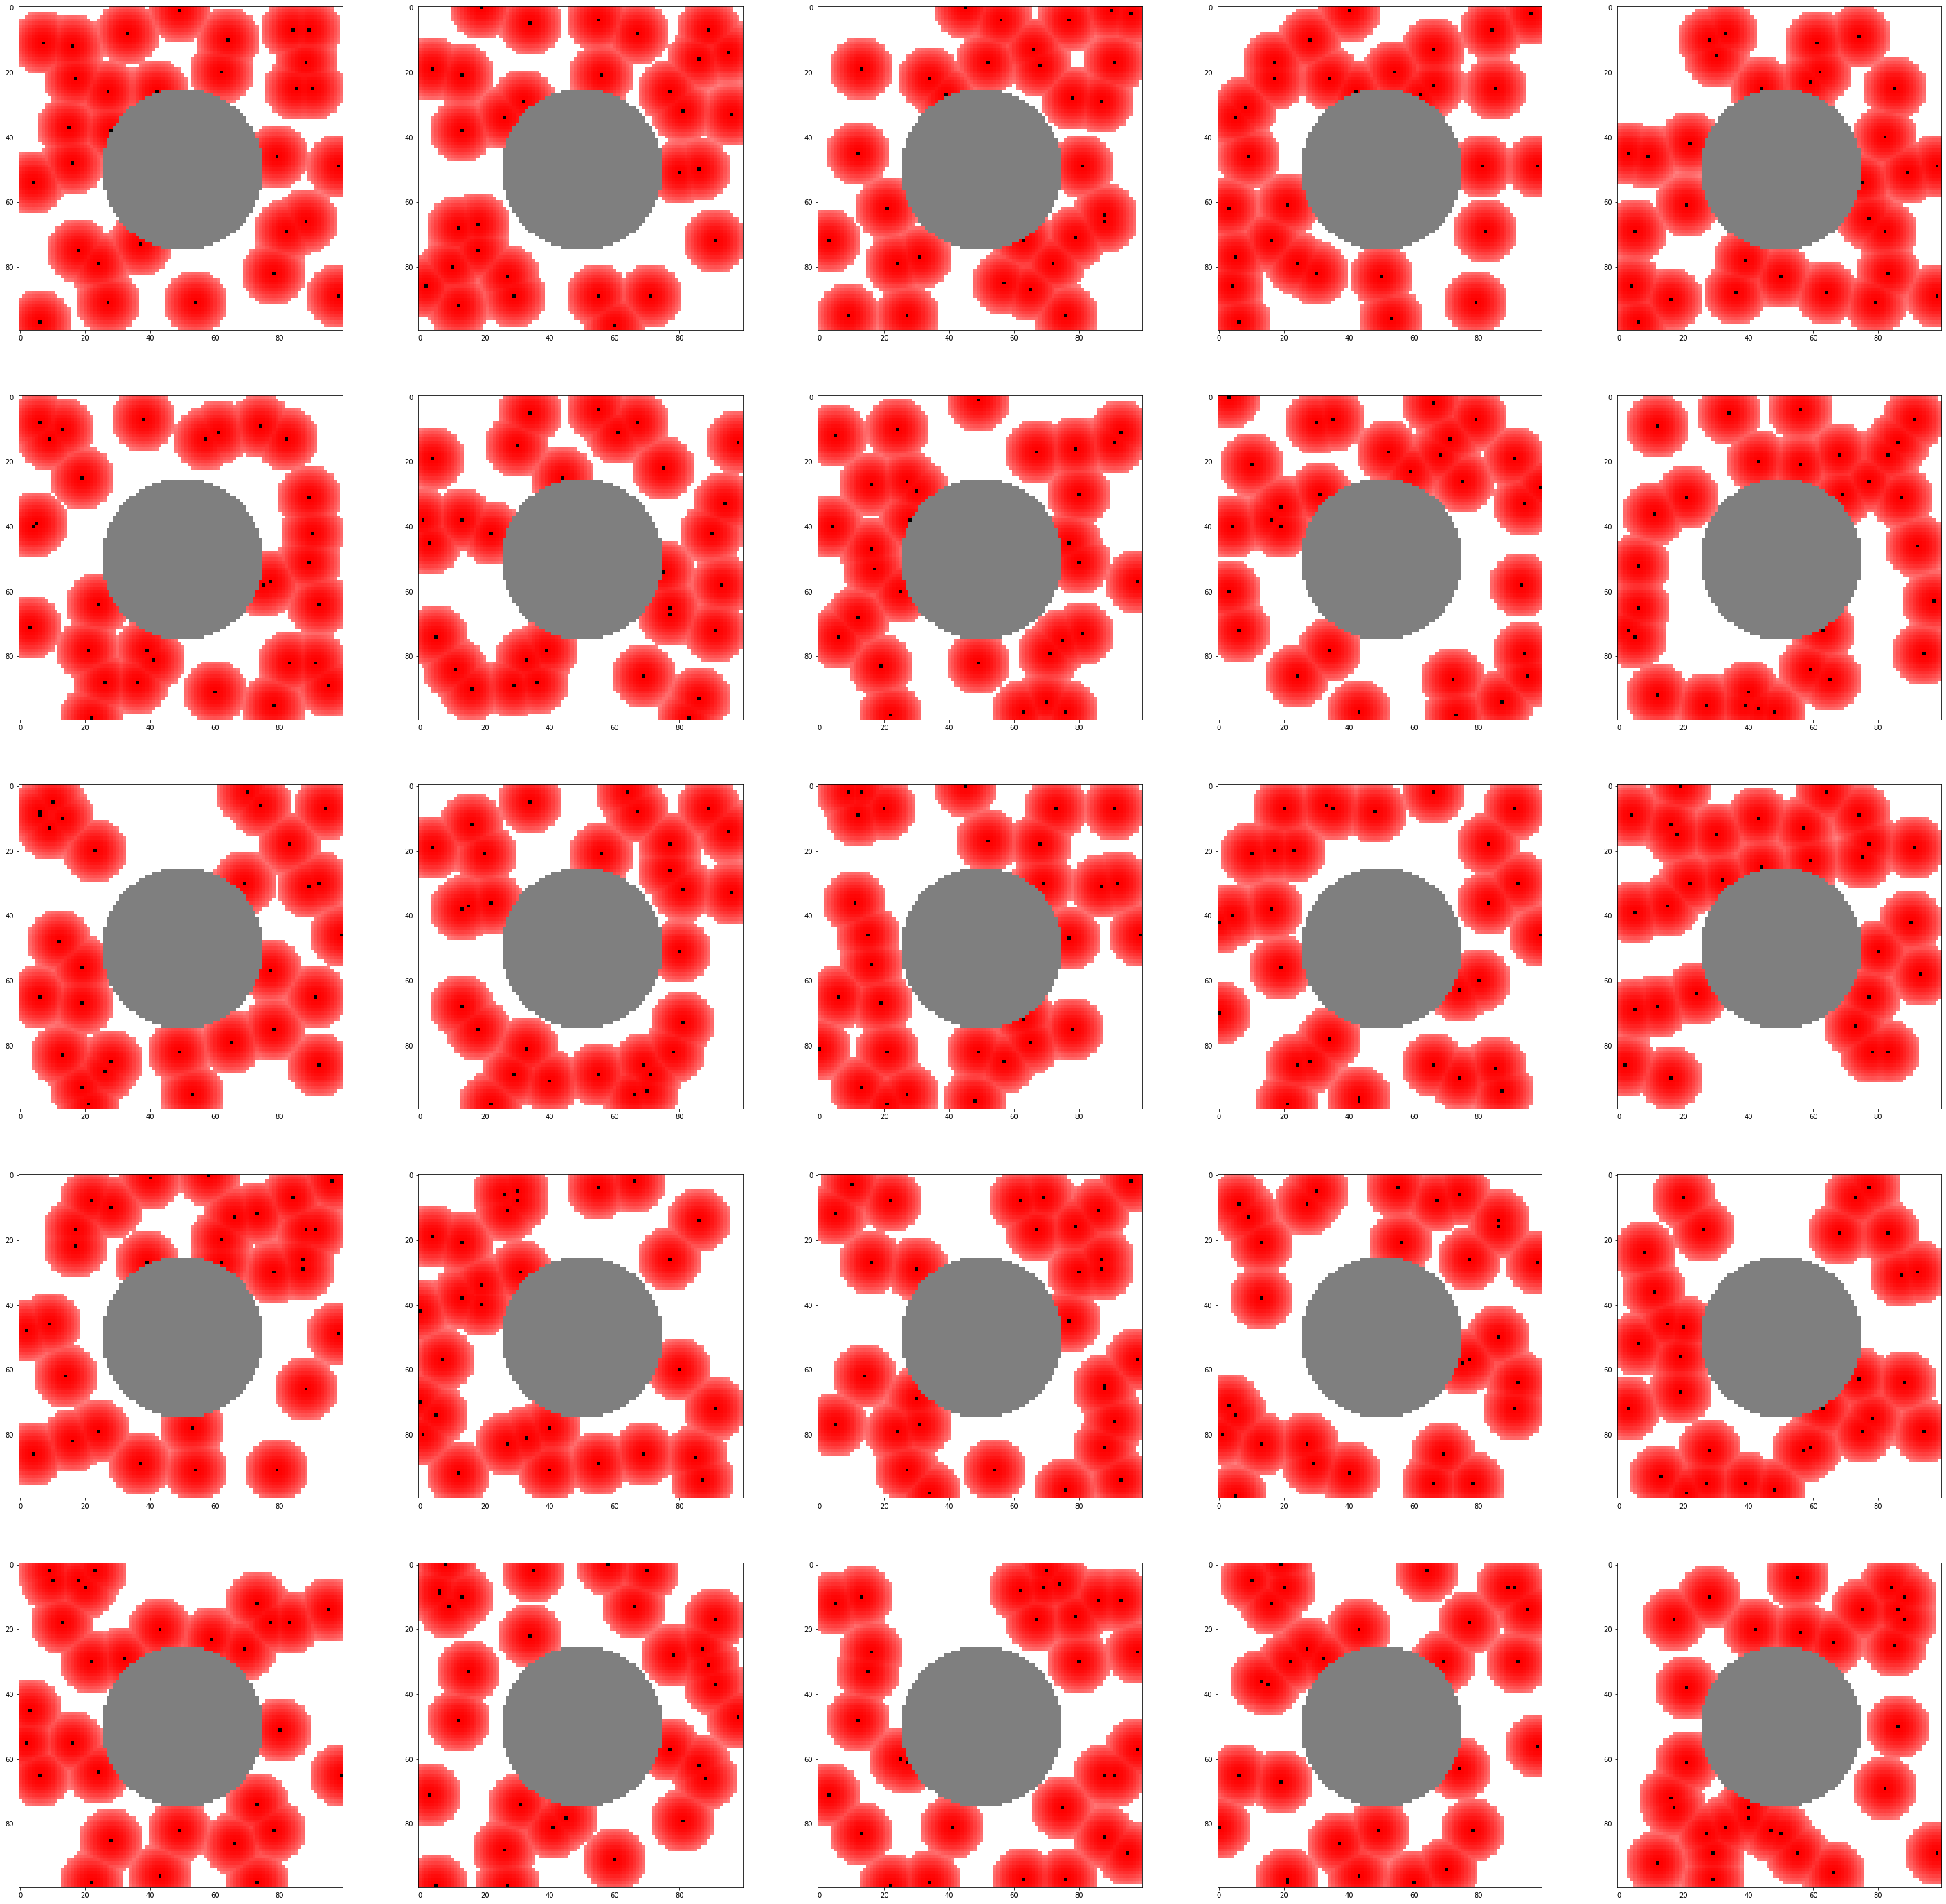

Generation 19
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2220. 1872.
 1796. 1750. 1742. 1730. 1725. 1708. 1625. 1589. 1587. 1575. 1529. 1476.
 1459.]
Previous generation score average 3186.52
[9.60359151e-02 9.46011617e-02 9.30969847e-02 9.24721727e-02
 9.22407609e-02 9.16390901e-02 9.09448546e-02 8.94406776e-02
 8.91629834e-02 8.90704186e-02 1.76335825e-02 9.58045033e-03
 7.82172032e-03 6.75722583e-03 6.57209636e-03 6.29440215e-03
 6.17869623e-03 5.78529609e-03 3.86457779e-03 3.03149515e-03
 2.98521278e-03 2.70751857e-03 1.64302409e-03 4.16541319e-04
 2.31411844e-05]


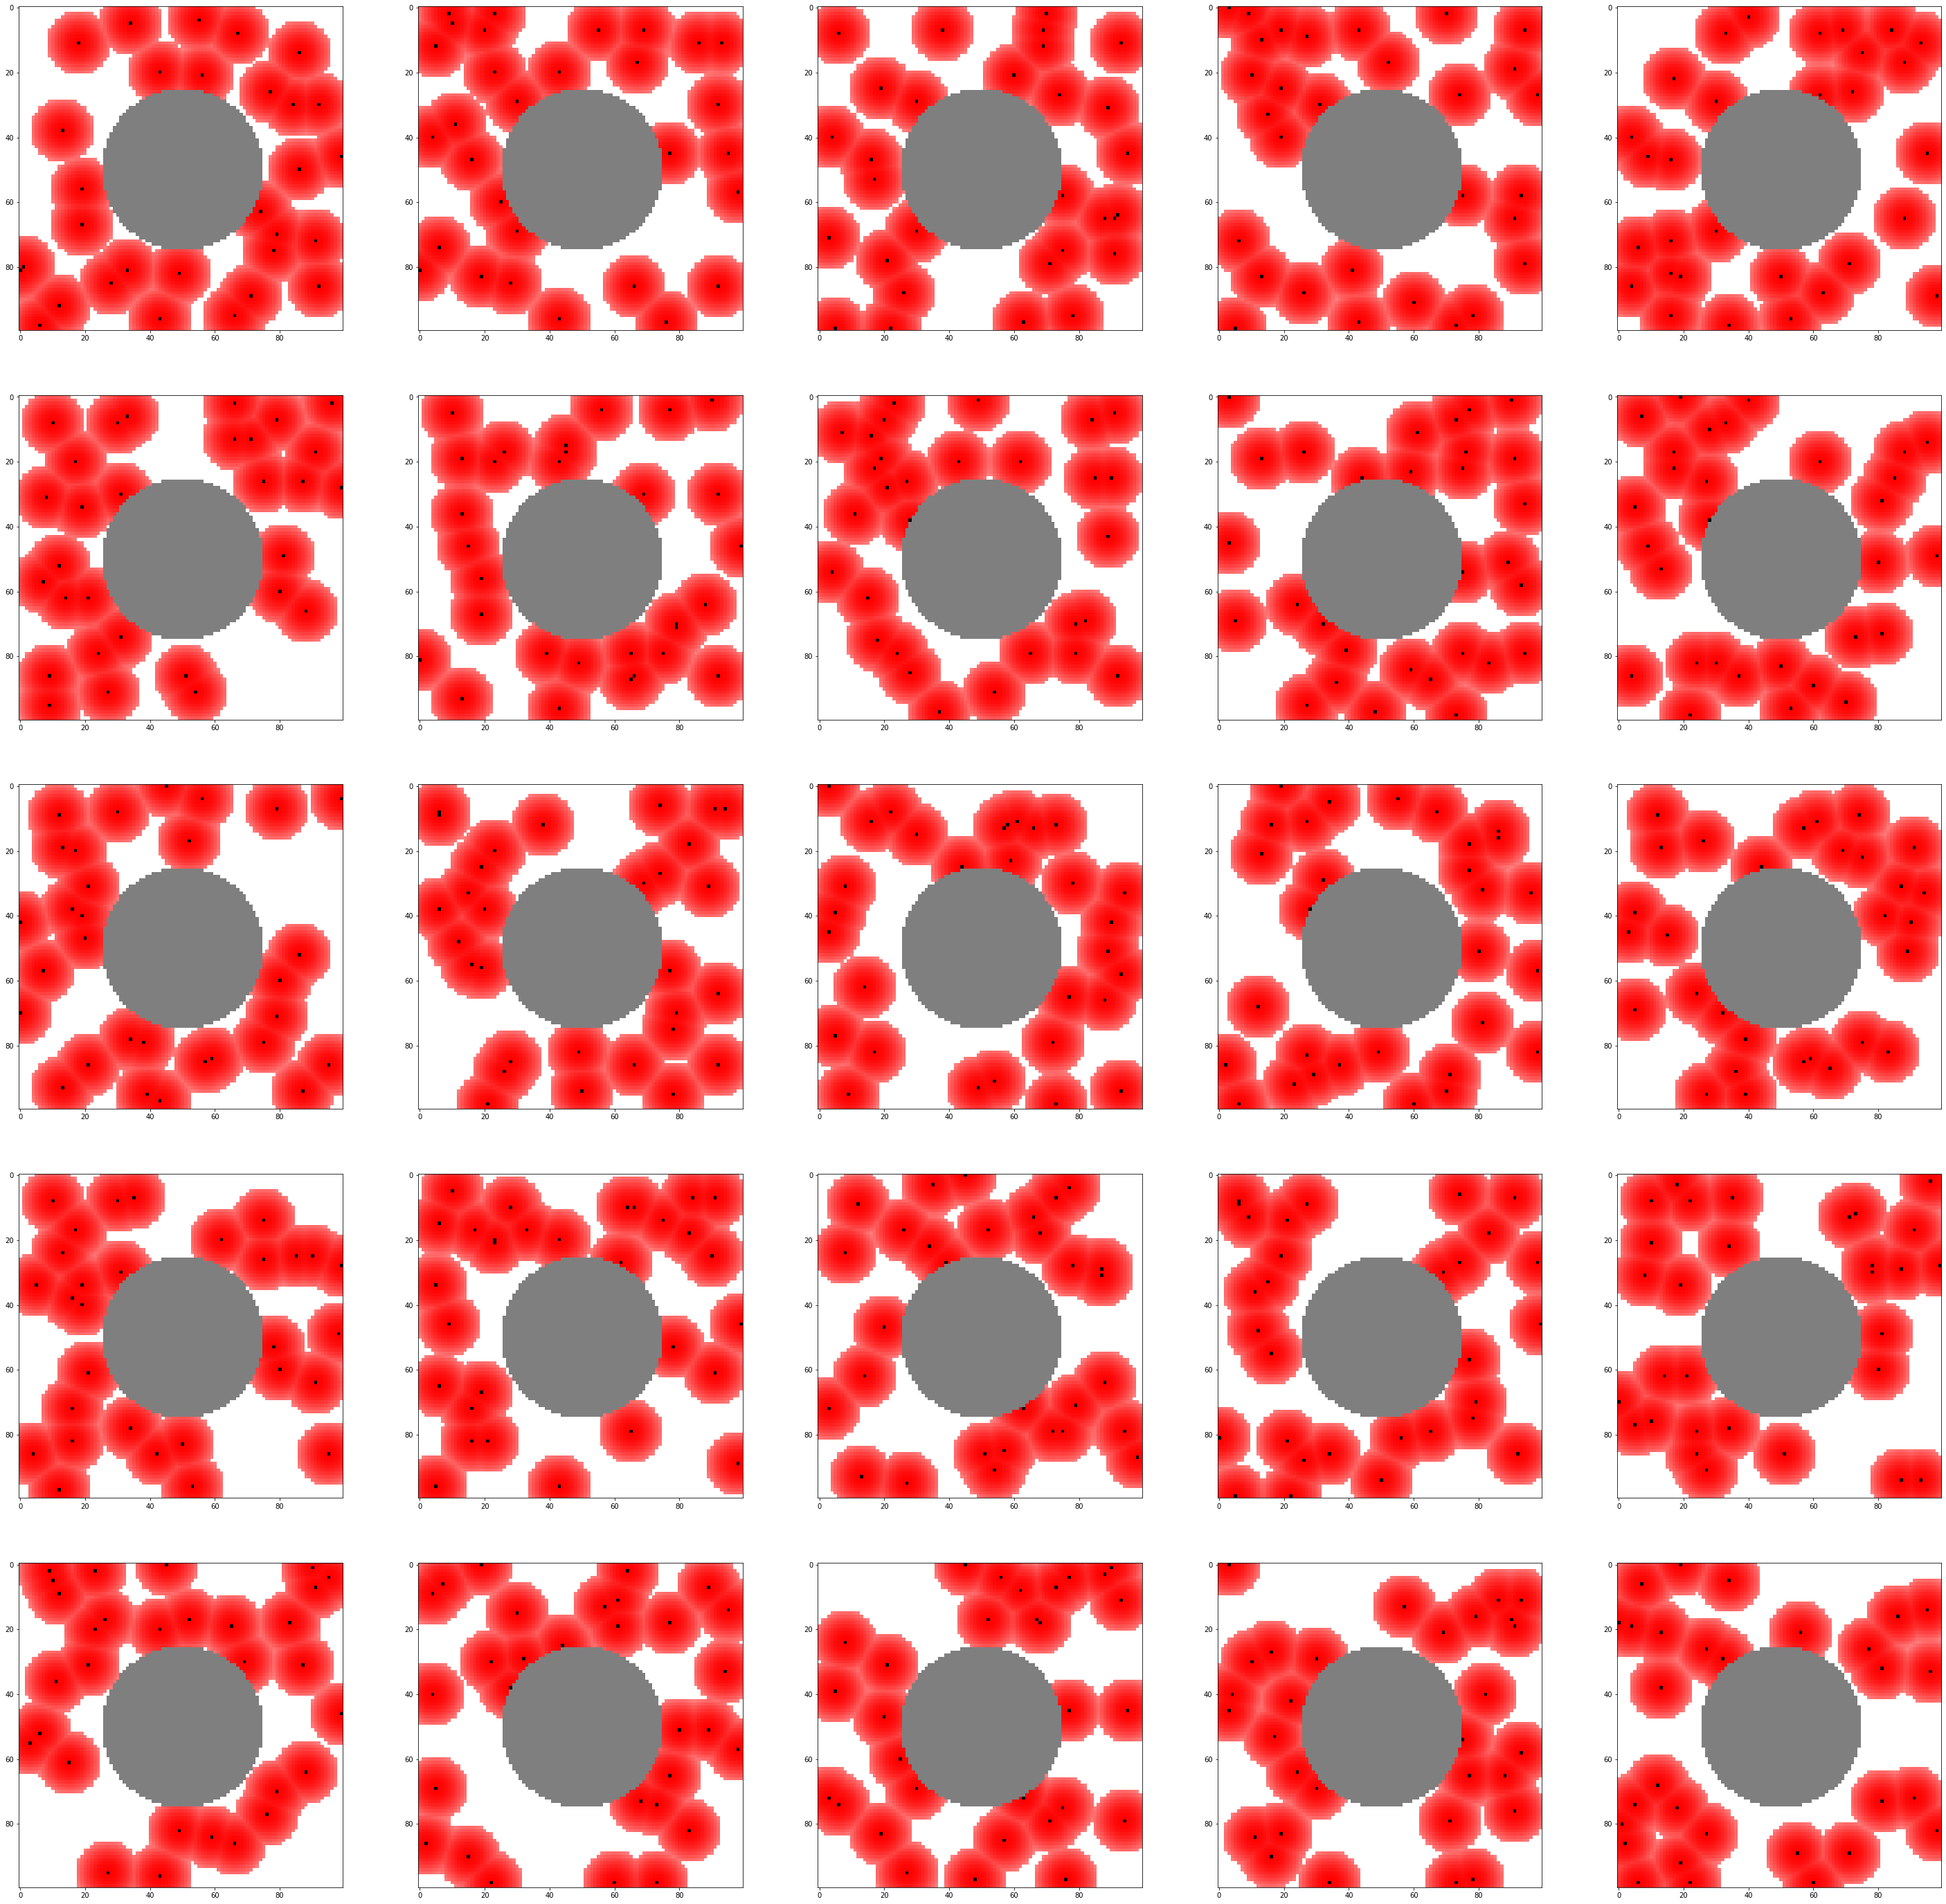

Generation 20
[5608. 5546. 5481. 5454. 5444. 5418. 5388. 5323. 5311. 5307. 2395. 2338.
 2314. 2175. 1792. 1766. 1691. 1655. 1558. 1549. 1514. 1500. 1370. 1162.
 1121.]
Previous generation score average 3207.2
[8.60099655e-02 8.48217708e-02 8.35760828e-02 8.30586432e-02
 8.28669989e-02 8.23687236e-02 8.17937907e-02 8.05481027e-02
 8.03181296e-02 8.02414718e-02 2.44346493e-02 2.33422767e-02
 2.28823304e-02 2.02184745e-02 1.28784975e-02 1.23802223e-02
 1.09428900e-02 1.02529705e-02 8.39402070e-03 8.22154082e-03
 7.55078574e-03 7.28248371e-03 4.79110770e-03 8.04906094e-04
 1.91644308e-05]


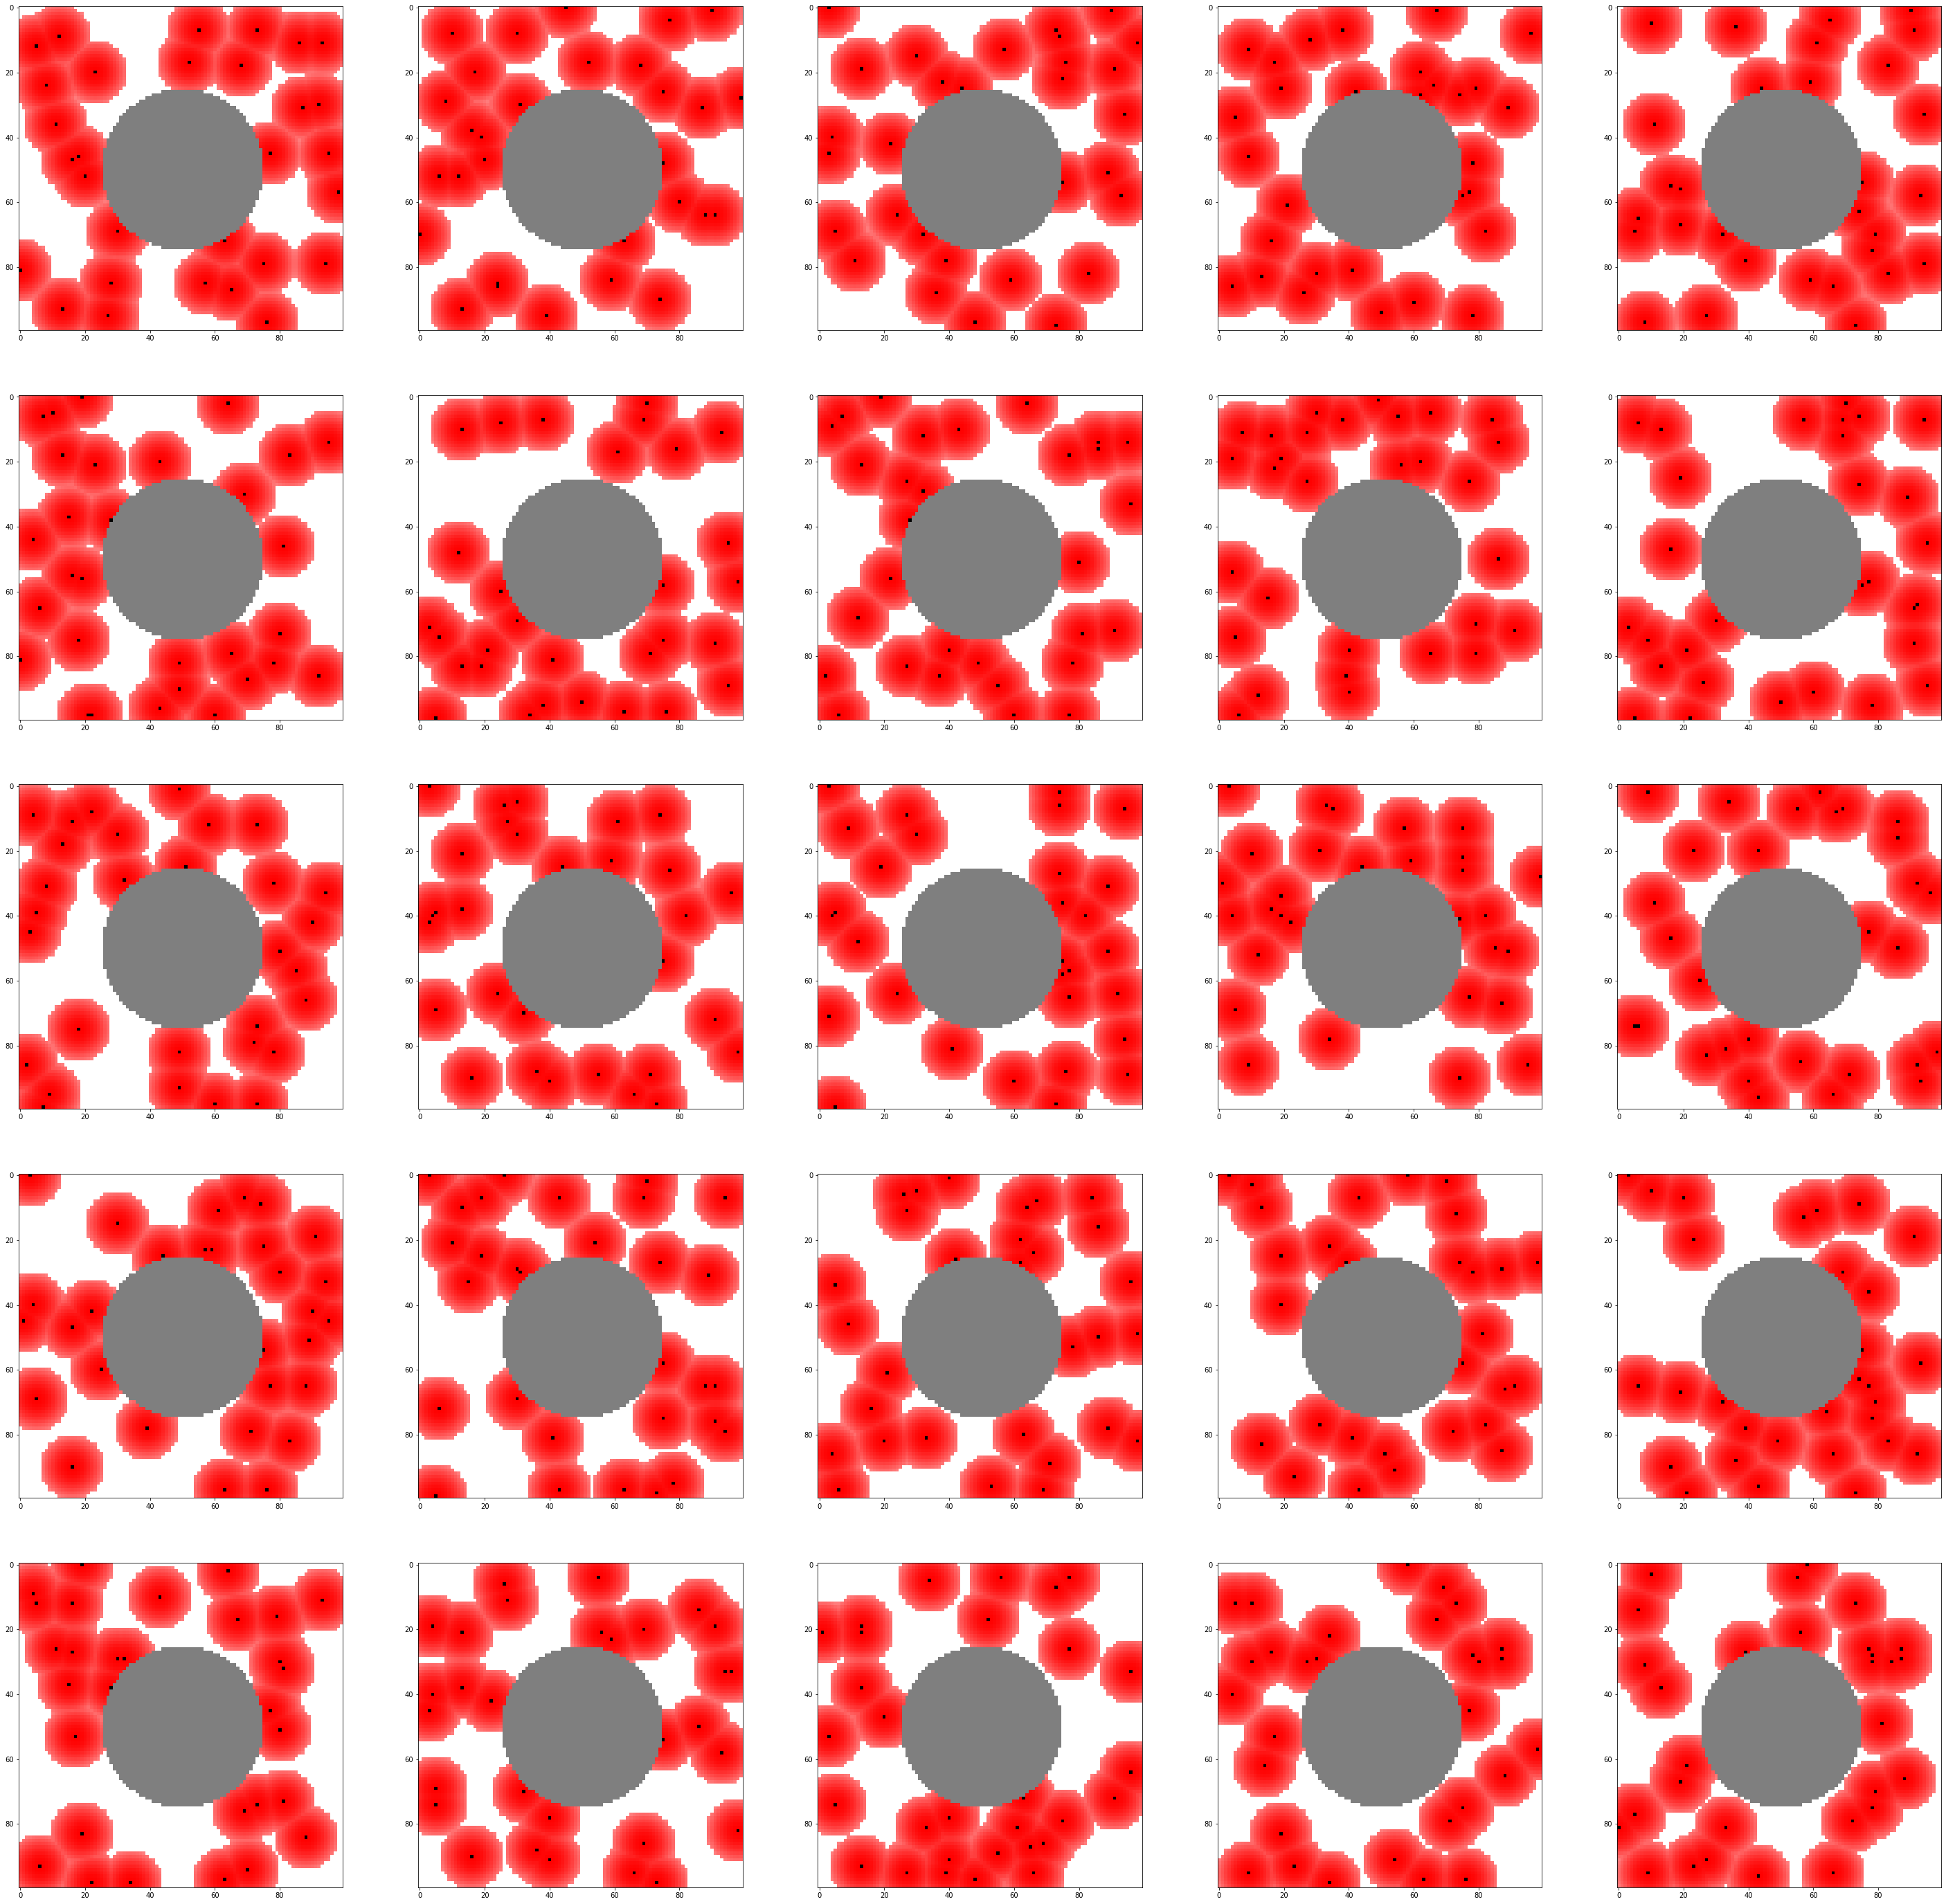

In [113]:
import numpy as np
import random

generation_pop = {}
generation_pop[0] = current_population
display_pop(current_population)
for g in range(1, GENERATIONS + 1):
    print("Generation", g)
    # Make a new population
    new_population = []
    
    # Sort by score
    sorted_population = sorted(current_population, key=lambda k:k['real_score'], reverse=True)[:DISMISS_WORSE]
    
    # Keep the best
    new_population += sorted_population[:KEEP_BEST]
    
    # Make picking probability
    scores = np.array([e['real_score'] for e in sorted_population])
    print(scores)
    print("Previous generation score average", scores.mean())
    
    scores -= scores.min() - 1
    probas = scores / scores.sum()
    print(probas)
    
    # Make childrens
    for i in range(POP_SIZE - KEEP_BEST):
        parents = np.random.choice(sorted_population, 2, p=probas, replace=False)
        child = combine_parents(parents[0], parents[1])
        child = mutate(child)
        while solution_in_list(child, new_population):
            parents = np.random.choice(sorted_population, 2, p=probas, replace=False)
            child = combine_parents(parents[0], parents[1])
            child = mutate(child)
        score, true_score, field = eval_solution_with_overlap(child)
        new_population.append({'solution' : child, 'real_score' : score, 'score_with_overlap': true_score, 'field': field})
    
    current_population = new_population
    display_pop(current_population)
    
    generation_pop[g] = current_population

In [114]:
sorted(eval_registry, key=lambda k:k['score_with_overlap'], reverse=True)[0]

{'real_score': 5852,
 'score_with_overlap': 2732.0,
 'index': 183,
 'solution': [{'x': 42, 'y': 22},
  {'x': 99, 'y': 22},
  {'x': 40, 'y': 82},
  {'x': 95, 'y': 78},
  {'x': 89, 'y': 95},
  {'x': 65, 'y': 91},
  {'x': 71, 'y': 3},
  {'x': 83, 'y': 13},
  {'x': 45, 'y': 3},
  {'x': 73, 'y': 90},
  {'x': 9, 'y': 27},
  {'x': 25, 'y': 74},
  {'x': 13, 'y': 57},
  {'x': 7, 'y': 38},
  {'x': 7, 'y': 94},
  {'x': 57, 'y': 77},
  {'x': 81, 'y': 32},
  {'x': 58, 'y': 75},
  {'x': 88, 'y': 53},
  {'x': 25, 'y': 19},
  {'x': 27, 'y': 98},
  {'x': 69, 'y': 5},
  {'x': 39, 'y': 5},
  {'x': 64, 'y': 24},
  {'x': 19, 'y': 91},
  {'x': 70, 'y': 32},
  {'x': 90, 'y': 75},
  {'x': 94, 'y': 70},
  {'x': 98, 'y': 73},
  {'x': 6, 'y': 74}]}

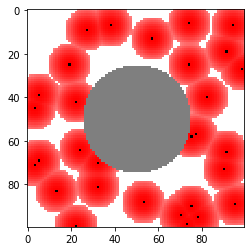

In [115]:
solution = sorted(eval_registry, key=lambda k:k['score_with_overlap'], reverse=True)[0]["solution"]
show_solution(solution)

In [116]:
best = sorted(eval_registry, key=lambda k:k['score_with_overlap'], reverse=True)[0]
save_solution(best["solution"], "./without_overlap_{}.txt".format(best["real_score"]))

1014.0

In [ ]:
session_info("genetic_algorithm")